In [1]:
import numpy as np
import random
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

In [2]:
SEED_VALUE = 42

random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED_VALUE)
    torch.cuda.manual_seed_all(SEED_VALUE)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Dataset

In [4]:
import os

dir_name = "dataset"
df = []
for _class in os.listdir(dir_name):
    df += [[os.path.join(dir_name, _class, img), _class] for img in os.listdir(os.path.join(dir_name, _class))]

df = pd.DataFrame(df, columns=['img_path', 'class'])

In [6]:
df['class'].value_counts()

class
E-3      1245
KC-10    1242
F-22     1231
B-52     1066
Name: count, dtype: int64

In [7]:
label_encoder = LabelEncoder().fit(df['class'])
df['class'] = label_encoder.transform(df['class'])

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(list(df['img_path']), list(df['class']), test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.3)

In [9]:
from dataset import AircraftDataset
from torch.utils.data import DataLoader

def get_loader(images,
               classes,
               transform,
               batch_size,
               num_workers=8,
               pin_memory=True, 
               ):
    tmp = AircraftDataset(images=images, classes=classes, transform=transform)
    loader = DataLoader(tmp, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=True)

    return loader

In [10]:
IMAGE_HEIGHT = 96
IMAGE_WIDTH = 96

transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

In [11]:
batch_size = 8

train_data_loader = get_loader(
    images=X_train,
    classes=y_train,
    transform=transform,
    batch_size=batch_size)
val_data_loader = get_loader(
    images=X_val,
    classes=y_val,
    transform=transform,
    batch_size=batch_size)
test_data_loader = get_loader(
    images=X_test,
    classes=y_test,
    transform=transform,
    batch_size=batch_size)


# Custom Layers

In [12]:
import math

class CustomLinearLayer(nn.Module):
    def __init__(self, _input, _output, bias=True):
        super().__init__()
        self.in_features = _input
        self.out_features = _input
        
        self.bias = bias
        self.weight = torch.nn.Parameter(torch.Tensor(_output, _input))
        
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(_output))
        else:
            self.register_parameter('bias', None)
        self.reset()

    def reset(self):
        torch.nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            torch.nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        output = input.matmul(self.weight.t())
        
        if self.bias is not None:
            output += self.bias
            
        ret = output
        return ret

In [13]:
class CustomReLULayer(nn.Module):
    def __init__(self):
        super(CustomReLULayer, self).__init__()

    def forward(self, input):
        return torch.max(torch.zeros_like(input), input)

In [14]:
from collections import OrderedDict

class AircraftNet(nn.Module):
    def __init__(self, _input, hidden_size, _output, batch_normalization=False):
        super(AircraftNet, self).__init__()
        self.model = nn.Sequential(OrderedDict([
            ('fc1', CustomLinearLayer(_input, hidden_size)),
            ('relu', CustomReLULayer()),
            ('fc2', CustomLinearLayer(hidden_size, _output))
        ])) if not batch_normalization else nn.Sequential(OrderedDict([
            ('fc1', CustomLinearLayer(_input, hidden_size)),
            ('bn1', nn.BatchNorm1d(hidden_size)),
            ('relu', CustomReLULayer()),
            ('fc2', CustomLinearLayer(hidden_size, _output)),
            ('bn2', nn.BatchNorm1d(_output)),
        ]))

    def forward(self, x):
        return self.model(x)

# Train

In [15]:
def check_gradients(model, input_data, target_data, loss_fn, epsilon=1e-5, num_params_to_check=10):
    input_data = input_data.view(-1, IMAGE_HEIGHT*IMAGE_WIDTH*3).to(device)
    target_data = target_data.to(device)
    model.zero_grad()
    loss = loss_fn(model(input_data), target_data)
    loss.backward()

    params_to_check = list(model.named_parameters())
    num_params = sum(p[1].numel() for p in params_to_check if p[1].requires_grad)
    if num_params_to_check > num_params:
        num_params_to_check = num_params

    indices = torch.randperm(num_params)[:num_params_to_check]

    for param_name, param in params_to_check: 
        if param.requires_grad:
            print(f"Checking gradient for parameter: {param_name}")
            
            grad = param.grad
            param_flat = param.data.view(-1)
            grad_flat = grad.view(-1)

            for idx in indices:
                if idx >= param_flat.size(0):
                    break

                param_flat[idx] += epsilon
                loss_plus = loss_fn(model(input_data), target_data)
                param_flat[idx] -= 2 * epsilon
                loss_minus = loss_fn(model(input_data), target_data)
                param_flat[idx] += epsilon

                numerical_grad = (loss_plus - loss_minus) / (2 * epsilon)
                diff = torch.abs(numerical_grad - grad_flat[idx]).item()

                if diff > epsilon:
                    print(f'Gradient check failed for parameter {param_name}')
                    return False

    print('Gradients check passed!')
    return True

In [16]:
from generic_adam import WeightDecay

def train_model(model, optimizer, train_loader, val_loader, num_epochs, learning_rate, weight_decay, df):
    criterion = nn.CrossEntropyLoss().to(device)

    optimizer = optimizer(model.parameters(),
                          lr=learning_rate,
                          weight_decay=weight_decay)

    train_losses = []
    val_losses = []
    best_acc = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (images, labels) in enumerate(tqdm(train_loader)):
            images = images.view(-1, IMAGE_HEIGHT * IMAGE_WIDTH * 3).to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracy = correct_train / total_train

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(tqdm(val_loader)):
                images = images.view(-1, IMAGE_HEIGHT * IMAGE_WIDTH * 3).to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct_val / total_val

        print(f'Epoch [{epoch + 1} out of {num_epochs}], '
              f'Train --> loss: {train_losses[-1]:.4f} & accuracy: {train_accuracy * 100:.2f}%, '
              f'Validation --> loss: {val_losses[-1]:.4f} & accuracy: {val_accuracy * 100:.2f}%')

        best_acc = max(best_acc, val_accuracy)
        check_gradients(model, *next(iter(train_data_loader)), loss_fn=criterion)

    return train_losses, val_losses, pd.concat(
        [df, pd.DataFrame({"opt": [str(optimizer).split('(')[0].replace(' ', '')],
                           "best_accuracy": [best_acc],
                           "lr": [lr],
                           "weight_decay": [weight_decay],
                           })])

In [21]:
res = pd.DataFrame(columns=['opt', 'best_acc', 'lr', 'weight_decay'])

Params lr=0.0001, w=0.001, str(opt).split('(')[0].replace(' ', '')="<class'torch.optim.sgd.SGD'>"


100%|██████████| 126/126 [00:02<00:00, 45.76it/s]

Epoch [1 out of 15], Train --> loss: 1.3730 & accuracy: 30.32%, Validation --> loss: 1.3589 & accuracy: 37.31%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 42.16it/s]

Epoch [2 out of 15], Train --> loss: 1.3509 & accuracy: 36.08%, Validation --> loss: 1.3438 & accuracy: 38.51%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 41.33it/s]

Epoch [3 out of 15], Train --> loss: 1.3363 & accuracy: 40.32%, Validation --> loss: 1.3269 & accuracy: 42.19%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 31.63it/s]

Epoch [4 out of 15], Train --> loss: 1.3220 & accuracy: 42.95%, Validation --> loss: 1.3138 & accuracy: 39.50%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 40.30it/s]

Epoch [5 out of 15], Train --> loss: 1.3067 & accuracy: 42.17%, Validation --> loss: 1.3046 & accuracy: 44.68%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.56it/s]

Epoch [6 out of 15], Train --> loss: 1.2944 & accuracy: 44.74%, Validation --> loss: 1.2899 & accuracy: 40.60%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.13it/s]

Epoch [7 out of 15], Train --> loss: 1.2799 & accuracy: 44.30%, Validation --> loss: 1.2811 & accuracy: 39.90%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 40.92it/s]

Epoch [8 out of 15], Train --> loss: 1.2679 & accuracy: 46.15%, Validation --> loss: 1.2789 & accuracy: 47.26%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.05it/s]

Epoch [9 out of 15], Train --> loss: 1.2582 & accuracy: 46.80%, Validation --> loss: 1.2582 & accuracy: 46.77%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.68it/s]

Epoch [10 out of 15], Train --> loss: 1.2469 & accuracy: 47.13%, Validation --> loss: 1.2554 & accuracy: 47.96%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 39.28it/s]

Epoch [11 out of 15], Train --> loss: 1.2358 & accuracy: 48.24%, Validation --> loss: 1.2397 & accuracy: 47.56%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 31.42it/s]

Epoch [12 out of 15], Train --> loss: 1.2263 & accuracy: 49.97%, Validation --> loss: 1.2352 & accuracy: 41.69%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.83it/s]

Epoch [13 out of 15], Train --> loss: 1.2173 & accuracy: 50.00%, Validation --> loss: 1.2228 & accuracy: 48.46%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.93it/s]

Epoch [14 out of 15], Train --> loss: 1.2062 & accuracy: 51.05%, Validation --> loss: 1.2153 & accuracy: 48.96%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 40.63it/s]

Epoch [15 out of 15], Train --> loss: 1.1993 & accuracy: 51.79%, Validation --> loss: 1.2112 & accuracy: 49.55%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 42.75it/s]


Test Accuracy: 51.28%


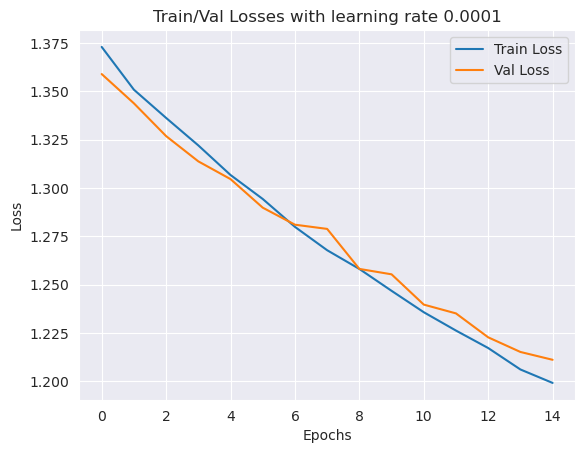

train_losses=[1.3729610707708646, 1.3508506586557356, 1.3362529112786268, 1.3220446522309843, 1.3067468282431007, 1.2943560573536912, 1.2799335703929455, 1.2678621976074, 1.2581869830379622, 1.246873030799101, 1.2358107202661919, 1.2263238994773646, 1.2172996031925047, 1.2062188217634233, 1.1992630641329545]
[1.3589323456325229, 1.3437980621580095, 1.3268623115524414, 1.3137966668795025, 1.3046272387580267, 1.289865357535226, 1.281059801105469, 1.2788812243749226, 1.2581970800483038, 1.2554021884524633, 1.2397487168274228, 1.2352005536594088, 1.2228324446413252, 1.2152713144582414, 1.2112179781709398]
Params lr=0.0001, w=0.01, str(opt).split('(')[0].replace(' ', '')="<class'torch.optim.sgd.SGD'>"


100%|██████████| 126/126 [00:03<00:00, 37.73it/s]

Epoch [1 out of 15], Train --> loss: 1.3744 & accuracy: 30.70%, Validation --> loss: 1.3728 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 43.99it/s]

Epoch [2 out of 15], Train --> loss: 1.3570 & accuracy: 35.27%, Validation --> loss: 1.3477 & accuracy: 46.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 36.86it/s]

Epoch [3 out of 15], Train --> loss: 1.3392 & accuracy: 39.96%, Validation --> loss: 1.3374 & accuracy: 47.16%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.81it/s]

Epoch [4 out of 15], Train --> loss: 1.3241 & accuracy: 42.59%, Validation --> loss: 1.3233 & accuracy: 51.34%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.05it/s]

Epoch [5 out of 15], Train --> loss: 1.3105 & accuracy: 43.70%, Validation --> loss: 1.3104 & accuracy: 39.90%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.48it/s]

Epoch [6 out of 15], Train --> loss: 1.2975 & accuracy: 45.58%, Validation --> loss: 1.2945 & accuracy: 47.06%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.78it/s]

Epoch [7 out of 15], Train --> loss: 1.2842 & accuracy: 45.91%, Validation --> loss: 1.2839 & accuracy: 46.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.74it/s]

Epoch [8 out of 15], Train --> loss: 1.2728 & accuracy: 46.92%, Validation --> loss: 1.2740 & accuracy: 42.59%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.64it/s]

Epoch [9 out of 15], Train --> loss: 1.2604 & accuracy: 47.37%, Validation --> loss: 1.2623 & accuracy: 46.17%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 35.96it/s]

Epoch [10 out of 15], Train --> loss: 1.2505 & accuracy: 48.21%, Validation --> loss: 1.2546 & accuracy: 48.76%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 43.77it/s]

Epoch [11 out of 15], Train --> loss: 1.2380 & accuracy: 48.89%, Validation --> loss: 1.2482 & accuracy: 48.46%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.25it/s]

Epoch [12 out of 15], Train --> loss: 1.2302 & accuracy: 50.39%, Validation --> loss: 1.2383 & accuracy: 45.67%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 40.04it/s]

Epoch [13 out of 15], Train --> loss: 1.2189 & accuracy: 51.58%, Validation --> loss: 1.2320 & accuracy: 43.58%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 41.33it/s]

Epoch [14 out of 15], Train --> loss: 1.2103 & accuracy: 50.81%, Validation --> loss: 1.2207 & accuracy: 49.75%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 41.55it/s]

Epoch [15 out of 15], Train --> loss: 1.2011 & accuracy: 51.52%, Validation --> loss: 1.2180 & accuracy: 49.05%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 37.36it/s]


Test Accuracy: 52.20%


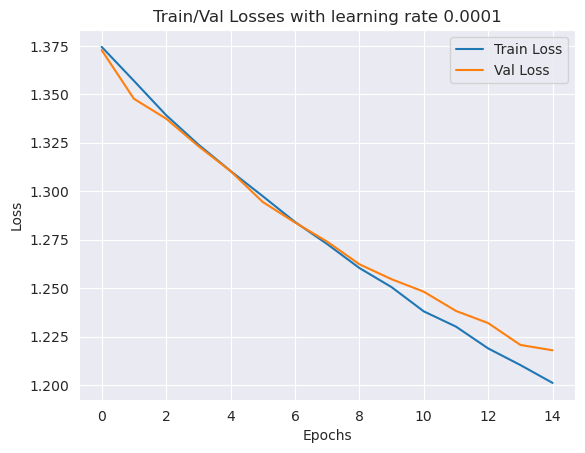

train_losses=[1.3744367369603996, 1.3569660175387217, 1.3392456761407967, 1.3241179805951357, 1.3104545614884406, 1.297459010861654, 1.2841726621181697, 1.272750510520753, 1.2604169700481442, 1.2505366133619322, 1.2380363528654512, 1.2301649089929312, 1.218916018709078, 1.2103408952032466, 1.2011293693487854]
[1.3727829995609464, 1.3476881640298026, 1.3374391056242443, 1.3232949527483138, 1.310386594325777, 1.2944689005140275, 1.283878697289361, 1.2740149829122756, 1.2623383516357058, 1.2546220587359533, 1.2481857897743347, 1.2382640559521934, 1.23199467384626, 1.2207138803270128, 1.2179549024218606]
Params lr=0.001, w=0.001, str(opt).split('(')[0].replace(' ', '')="<class'torch.optim.sgd.SGD'>"


100%|██████████| 126/126 [00:02<00:00, 45.51it/s]

Epoch [1 out of 15], Train --> loss: 1.3491 & accuracy: 33.45%, Validation --> loss: 1.2962 & accuracy: 46.87%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.77it/s]

Epoch [2 out of 15], Train --> loss: 1.2787 & accuracy: 41.70%, Validation --> loss: 1.2629 & accuracy: 38.51%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 43.77it/s]

Epoch [3 out of 15], Train --> loss: 1.2214 & accuracy: 47.13%, Validation --> loss: 1.2002 & accuracy: 45.37%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 37.87it/s]

Epoch [4 out of 15], Train --> loss: 1.1733 & accuracy: 50.39%, Validation --> loss: 1.1951 & accuracy: 42.59%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 35.26it/s]

Epoch [5 out of 15], Train --> loss: 1.1287 & accuracy: 53.23%, Validation --> loss: 1.1240 & accuracy: 56.72%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 32.37it/s]

Epoch [6 out of 15], Train --> loss: 1.0808 & accuracy: 56.36%, Validation --> loss: 1.1373 & accuracy: 52.44%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.27it/s]

Epoch [7 out of 15], Train --> loss: 1.0514 & accuracy: 57.68%, Validation --> loss: 1.1354 & accuracy: 51.64%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.73it/s]

Epoch [8 out of 15], Train --> loss: 1.0172 & accuracy: 60.57%, Validation --> loss: 1.0910 & accuracy: 53.13%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 42.65it/s]

Epoch [9 out of 15], Train --> loss: 0.9837 & accuracy: 62.51%, Validation --> loss: 1.0041 & accuracy: 62.29%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.99it/s]

Epoch [10 out of 15], Train --> loss: 0.9752 & accuracy: 62.07%, Validation --> loss: 1.0769 & accuracy: 59.00%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 36.40it/s]

Epoch [11 out of 15], Train --> loss: 0.9423 & accuracy: 64.07%, Validation --> loss: 1.0180 & accuracy: 56.92%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.85it/s]

Epoch [12 out of 15], Train --> loss: 0.9281 & accuracy: 64.10%, Validation --> loss: 1.2104 & accuracy: 50.15%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.54it/s]

Epoch [13 out of 15], Train --> loss: 0.8980 & accuracy: 65.47%, Validation --> loss: 1.0429 & accuracy: 58.21%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.66it/s]

Epoch [14 out of 15], Train --> loss: 0.8882 & accuracy: 66.04%, Validation --> loss: 1.2199 & accuracy: 46.87%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 38.30it/s]

Epoch [15 out of 15], Train --> loss: 0.8714 & accuracy: 67.17%, Validation --> loss: 0.9624 & accuracy: 62.79%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 41.34it/s]


Test Accuracy: 71.69%


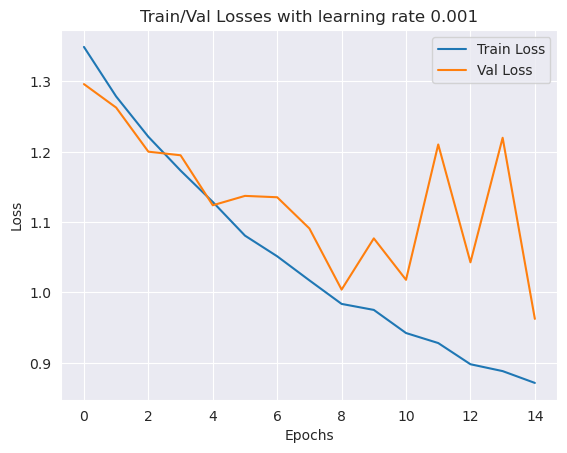

train_losses=[1.3491097557800766, 1.2786516183031487, 1.2213792180673604, 1.173305874792659, 1.1287299188338487, 1.0808045768083423, 1.051409932337968, 1.0172222768776742, 0.9837310313467195, 0.9751955026089434, 0.9423332015199137, 0.9280801546317581, 0.897951262378465, 0.8881929406900679, 0.8713967553684421]
[1.2962397128816634, 1.2628512306818886, 1.2001935082768638, 1.1950597862402599, 1.1239740337644304, 1.1373134468282973, 1.1353745176678611, 1.0909835095443423, 1.004072138241359, 1.0768856011212817, 1.0179793527202001, 1.210412467282916, 1.0428848164895224, 1.2199377412833865, 0.9624351286698901]
Params lr=0.001, w=0.01, str(opt).split('(')[0].replace(' ', '')="<class'torch.optim.sgd.SGD'>"


100%|██████████| 126/126 [00:02<00:00, 46.61it/s]

Epoch [1 out of 15], Train --> loss: 1.3617 & accuracy: 32.95%, Validation --> loss: 1.3195 & accuracy: 38.31%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.93it/s]

Epoch [2 out of 15], Train --> loss: 1.2872 & accuracy: 42.14%, Validation --> loss: 1.2449 & accuracy: 51.84%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.37it/s]

Epoch [3 out of 15], Train --> loss: 1.2280 & accuracy: 46.51%, Validation --> loss: 1.2106 & accuracy: 50.75%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.98it/s]

Epoch [4 out of 15], Train --> loss: 1.1746 & accuracy: 51.05%, Validation --> loss: 1.1888 & accuracy: 43.18%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.58it/s]

Epoch [5 out of 15], Train --> loss: 1.1298 & accuracy: 54.00%, Validation --> loss: 1.1778 & accuracy: 45.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.62it/s]

Epoch [6 out of 15], Train --> loss: 1.0934 & accuracy: 56.15%, Validation --> loss: 1.2300 & accuracy: 41.69%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.94it/s]

Epoch [7 out of 15], Train --> loss: 1.0515 & accuracy: 58.36%, Validation --> loss: 1.1257 & accuracy: 48.56%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.36it/s]

Epoch [8 out of 15], Train --> loss: 1.0299 & accuracy: 59.50%, Validation --> loss: 1.1426 & accuracy: 46.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.99it/s]

Epoch [9 out of 15], Train --> loss: 0.9917 & accuracy: 61.17%, Validation --> loss: 1.0777 & accuracy: 56.02%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.58it/s]

Epoch [10 out of 15], Train --> loss: 0.9720 & accuracy: 62.01%, Validation --> loss: 1.0321 & accuracy: 55.92%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.45it/s]

Epoch [11 out of 15], Train --> loss: 0.9416 & accuracy: 63.83%, Validation --> loss: 1.1492 & accuracy: 46.77%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.41it/s]

Epoch [12 out of 15], Train --> loss: 0.9336 & accuracy: 64.10%, Validation --> loss: 0.9653 & accuracy: 62.19%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.33it/s]

Epoch [13 out of 15], Train --> loss: 0.9061 & accuracy: 66.16%, Validation --> loss: 1.0980 & accuracy: 50.15%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.97it/s]

Epoch [14 out of 15], Train --> loss: 0.8966 & accuracy: 65.95%, Validation --> loss: 1.0040 & accuracy: 62.29%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.41it/s]

Epoch [15 out of 15], Train --> loss: 0.8751 & accuracy: 66.55%, Validation --> loss: 1.0885 & accuracy: 55.12%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 43.32it/s]


Test Accuracy: 55.22%


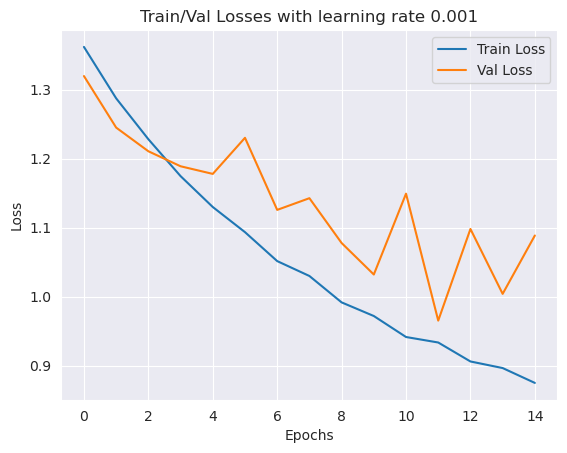

train_losses=[1.3616693049740394, 1.2872248522421625, 1.2280073953983608, 1.174553054329319, 1.1298196066819968, 1.0934125451028773, 1.0514908896710253, 1.0299413712041758, 0.9916941947470417, 0.9719634905350806, 0.9415550603217897, 0.9335945119152206, 0.9061346588954151, 0.8965973347638843, 0.8750634560437077]
[1.3194821197835227, 1.244851266107862, 1.2105564451406872, 1.1888270647752852, 1.1777650477394226, 1.2300412125057645, 1.1256571308014884, 1.1425901426682397, 1.0776886845391893, 1.0320520840940022, 1.1491538939021884, 0.9653077669559963, 1.0980050800338623, 1.004041691857671, 1.0885410095964159]
Params lr=0.01, w=0.001, str(opt).split('(')[0].replace(' ', '')="<class'torch.optim.sgd.SGD'>"


100%|██████████| 126/126 [00:02<00:00, 45.93it/s]

Epoch [1 out of 15], Train --> loss: 1.3654 & accuracy: 30.38%, Validation --> loss: 1.3498 & accuracy: 34.23%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.84it/s]

Epoch [2 out of 15], Train --> loss: 1.3231 & accuracy: 38.26%, Validation --> loss: 1.3375 & accuracy: 41.89%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.36it/s]

Epoch [3 out of 15], Train --> loss: 1.2719 & accuracy: 42.26%, Validation --> loss: 1.2524 & accuracy: 43.58%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.95it/s]

Epoch [4 out of 15], Train --> loss: 1.2550 & accuracy: 42.26%, Validation --> loss: 1.2516 & accuracy: 40.30%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.35it/s]

Epoch [5 out of 15], Train --> loss: 1.2188 & accuracy: 43.55%, Validation --> loss: 1.2015 & accuracy: 43.78%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.37it/s]

Epoch [6 out of 15], Train --> loss: 1.1776 & accuracy: 46.62%, Validation --> loss: 1.1739 & accuracy: 46.97%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.77it/s]

Epoch [7 out of 15], Train --> loss: 1.1685 & accuracy: 49.28%, Validation --> loss: 1.1898 & accuracy: 43.88%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.93it/s]

Epoch [8 out of 15], Train --> loss: 1.1024 & accuracy: 53.49%, Validation --> loss: 1.1034 & accuracy: 52.94%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.36it/s]

Epoch [9 out of 15], Train --> loss: 1.0685 & accuracy: 54.99%, Validation --> loss: 1.3749 & accuracy: 43.18%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.29it/s]

Epoch [10 out of 15], Train --> loss: 1.0367 & accuracy: 57.50%, Validation --> loss: 1.0616 & accuracy: 51.94%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.76it/s]

Epoch [11 out of 15], Train --> loss: 1.0145 & accuracy: 58.87%, Validation --> loss: 1.0379 & accuracy: 56.52%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.74it/s]

Epoch [12 out of 15], Train --> loss: 0.9931 & accuracy: 59.77%, Validation --> loss: 1.4550 & accuracy: 41.09%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.49it/s]

Epoch [13 out of 15], Train --> loss: 0.9751 & accuracy: 61.74%, Validation --> loss: 1.0326 & accuracy: 52.24%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.01it/s]

Epoch [14 out of 15], Train --> loss: 0.9416 & accuracy: 62.54%, Validation --> loss: 1.0176 & accuracy: 56.22%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.79it/s]

Epoch [15 out of 15], Train --> loss: 0.9188 & accuracy: 64.13%, Validation --> loss: 0.9881 & accuracy: 62.39%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 41.69it/s]


Test Accuracy: 64.04%


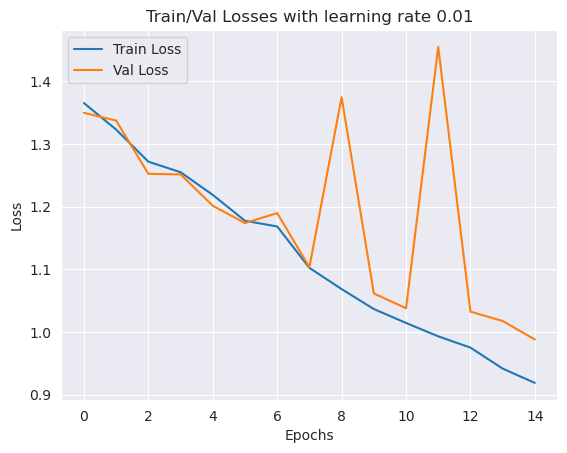

train_losses=[1.3653917164677367, 1.3231121569089503, 1.271877702067746, 1.255029925014068, 1.21883850436222, 1.1775629319837384, 1.1684599539402845, 1.102399785293884, 1.068503711559323, 1.0367328275644125, 1.014464812162099, 0.9931146351705018, 0.9751385659121671, 0.9416298949490868, 0.9187654624904255]
[1.3497745669077312, 1.3374728986195155, 1.2524295411412678, 1.251568848651553, 1.2015298037301927, 1.173922112063756, 1.1898334310168313, 1.103431161906984, 1.3748867890191456, 1.0616389910380046, 1.0378762537997865, 1.455014682478375, 1.0325683222876654, 1.017573395182216, 0.9881308369693302]
Params lr=0.01, w=0.01, str(opt).split('(')[0].replace(' ', '')="<class'torch.optim.sgd.SGD'>"


100%|██████████| 126/126 [00:02<00:00, 47.66it/s]

Epoch [1 out of 15], Train --> loss: 1.3856 & accuracy: 28.35%, Validation --> loss: 1.3643 & accuracy: 40.50%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.39it/s]

Epoch [2 out of 15], Train --> loss: 1.3458 & accuracy: 34.83%, Validation --> loss: 1.3507 & accuracy: 33.73%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.10it/s]

Epoch [3 out of 15], Train --> loss: 1.3193 & accuracy: 38.23%, Validation --> loss: 1.3865 & accuracy: 27.46%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.24it/s]

Epoch [4 out of 15], Train --> loss: 1.2874 & accuracy: 40.92%, Validation --> loss: 1.3681 & accuracy: 31.74%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.91it/s]

Epoch [5 out of 15], Train --> loss: 1.2761 & accuracy: 41.55%, Validation --> loss: 1.3218 & accuracy: 35.52%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.03it/s]

Epoch [6 out of 15], Train --> loss: 1.2483 & accuracy: 43.67%, Validation --> loss: 1.2074 & accuracy: 47.86%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.26it/s]

Epoch [7 out of 15], Train --> loss: 1.2266 & accuracy: 44.27%, Validation --> loss: 1.2343 & accuracy: 42.29%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.74it/s]

Epoch [8 out of 15], Train --> loss: 1.2017 & accuracy: 46.92%, Validation --> loss: 1.1914 & accuracy: 48.96%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.43it/s]

Epoch [9 out of 15], Train --> loss: 1.1936 & accuracy: 47.37%, Validation --> loss: 1.2439 & accuracy: 41.59%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.21it/s]

Epoch [10 out of 15], Train --> loss: 1.1911 & accuracy: 47.52%, Validation --> loss: 1.1492 & accuracy: 52.04%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.53it/s]

Epoch [11 out of 15], Train --> loss: 1.1512 & accuracy: 50.96%, Validation --> loss: 1.3024 & accuracy: 36.22%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.38it/s]

Epoch [12 out of 15], Train --> loss: 1.1475 & accuracy: 50.36%, Validation --> loss: 1.3817 & accuracy: 39.20%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.50it/s]

Epoch [13 out of 15], Train --> loss: 1.1335 & accuracy: 51.43%, Validation --> loss: 2.9611 & accuracy: 26.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.51it/s]

Epoch [14 out of 15], Train --> loss: 1.1280 & accuracy: 53.38%, Validation --> loss: 1.2378 & accuracy: 45.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.55it/s]

Epoch [15 out of 15], Train --> loss: 1.1198 & accuracy: 52.48%, Validation --> loss: 1.0939 & accuracy: 48.86%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 44.18it/s]


Test Accuracy: 49.65%


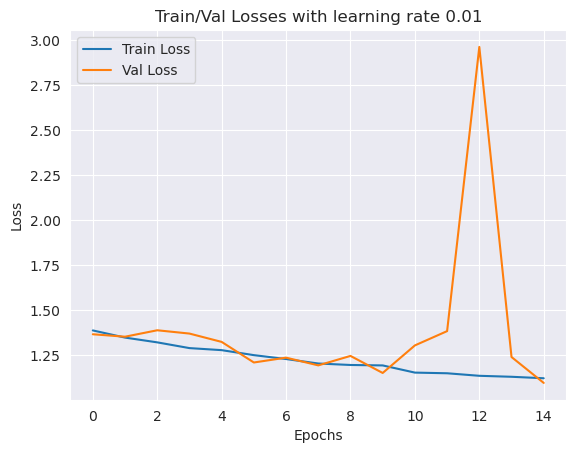

train_losses=[1.3856353520778029, 1.3458177039048553, 1.319274863366011, 1.2873755258136832, 1.2760518196090025, 1.248265877259375, 1.2266442576569987, 1.2017412804476117, 1.1935818057356131, 1.191126749595196, 1.1512087089207406, 1.1475289594871048, 1.1334572141381039, 1.1280144980812983, 1.1198285670155272]
[1.364286085915944, 1.3506858925970773, 1.386464168155004, 1.368134017028506, 1.3218219507308233, 1.2074264652199216, 1.234302268141792, 1.1913770664305914, 1.2439401849867806, 1.1491940106664384, 1.3024002635289753, 1.3817388514677684, 2.9610666642113337, 1.2378118113865928, 1.093884908017658]
Params lr=0.0001, w=0.001, str(opt).split('(')[0].replace(' ', '')="<class'custom_adam.Adam'>"


100%|██████████| 126/126 [00:02<00:00, 48.79it/s]

Epoch [1 out of 15], Train --> loss: 1.3741 & accuracy: 35.10%, Validation --> loss: 1.2128 & accuracy: 43.58%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.68it/s]

Epoch [2 out of 15], Train --> loss: 1.2233 & accuracy: 45.88%, Validation --> loss: 1.2003 & accuracy: 53.03%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.22it/s]

Epoch [3 out of 15], Train --> loss: 1.1680 & accuracy: 49.85%, Validation --> loss: 1.1632 & accuracy: 52.74%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.48it/s]

Epoch [4 out of 15], Train --> loss: 1.1156 & accuracy: 53.70%, Validation --> loss: 1.1393 & accuracy: 52.34%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 42.04it/s]

Epoch [5 out of 15], Train --> loss: 1.0564 & accuracy: 57.68%, Validation --> loss: 1.2217 & accuracy: 43.58%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 42.95it/s]

Epoch [6 out of 15], Train --> loss: 1.0227 & accuracy: 58.66%, Validation --> loss: 1.0522 & accuracy: 53.63%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.49it/s]

Epoch [7 out of 15], Train --> loss: 0.9740 & accuracy: 61.71%, Validation --> loss: 1.0496 & accuracy: 54.53%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.32it/s]

Epoch [8 out of 15], Train --> loss: 0.9625 & accuracy: 63.41%, Validation --> loss: 1.2425 & accuracy: 47.36%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.17it/s]

Epoch [9 out of 15], Train --> loss: 0.9418 & accuracy: 63.71%, Validation --> loss: 0.9792 & accuracy: 59.80%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 27.91it/s]

Epoch [10 out of 15], Train --> loss: 0.9127 & accuracy: 64.49%, Validation --> loss: 1.0032 & accuracy: 59.60%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.50it/s]

Epoch [11 out of 15], Train --> loss: 0.9010 & accuracy: 65.77%, Validation --> loss: 1.0250 & accuracy: 56.52%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.32it/s]

Epoch [12 out of 15], Train --> loss: 0.8651 & accuracy: 67.38%, Validation --> loss: 0.9761 & accuracy: 63.68%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.12it/s]

Epoch [13 out of 15], Train --> loss: 0.8340 & accuracy: 68.73%, Validation --> loss: 1.0165 & accuracy: 60.10%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 32.90it/s]

Epoch [14 out of 15], Train --> loss: 0.8396 & accuracy: 68.28%, Validation --> loss: 0.9682 & accuracy: 64.68%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 32.76it/s]


Epoch [15 out of 15], Train --> loss: 0.8082 & accuracy: 69.47%, Validation --> loss: 0.9297 & accuracy: 63.38%
Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 28.56it/s]


Test Accuracy: 68.45%


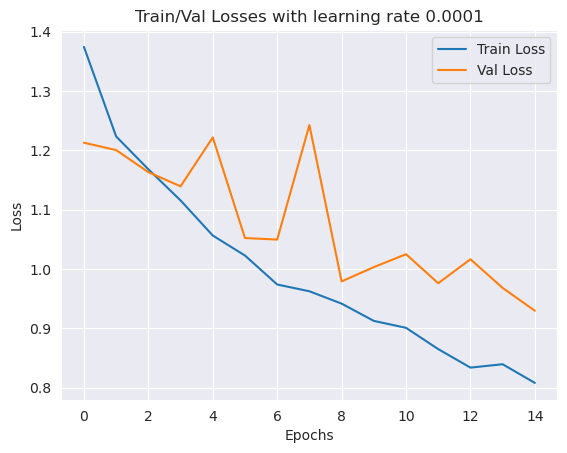

train_losses=[1.37407909344375, 1.2232628419177345, 1.1680127473321336, 1.1155750798439354, 1.0564341434146454, 1.0227278847256254, 0.9739682849381022, 0.9625307119547041, 0.9417500030738357, 0.9126651858230764, 0.9009822089233944, 0.8651402259072142, 0.8339816897325129, 0.8396496250692017, 0.8081924066054224]
[1.2127530943779719, 1.2003406248395405, 1.1631860785068027, 1.1392873539811088, 1.2217053009404077, 1.0522048364556025, 1.0496081279383764, 1.2424607863501897, 0.9791783321471441, 1.003192355944997, 1.0249905917379591, 0.976080107546988, 1.0164538692860376, 0.9681820370375164, 0.9297489954365624]
Params lr=0.0001, w=0.01, str(opt).split('(')[0].replace(' ', '')="<class'custom_adam.Adam'>"


100%|██████████| 126/126 [00:02<00:00, 44.68it/s]

Epoch [1 out of 15], Train --> loss: 1.3544 & accuracy: 35.36%, Validation --> loss: 1.3088 & accuracy: 46.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.55it/s]

Epoch [2 out of 15], Train --> loss: 1.1991 & accuracy: 48.45%, Validation --> loss: 1.1708 & accuracy: 49.95%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.67it/s]

Epoch [3 out of 15], Train --> loss: 1.1249 & accuracy: 54.57%, Validation --> loss: 1.1804 & accuracy: 52.14%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.72it/s]

Epoch [4 out of 15], Train --> loss: 1.0747 & accuracy: 57.77%, Validation --> loss: 1.0696 & accuracy: 57.71%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.51it/s]

Epoch [5 out of 15], Train --> loss: 1.0185 & accuracy: 60.01%, Validation --> loss: 1.0441 & accuracy: 56.62%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.14it/s]

Epoch [6 out of 15], Train --> loss: 0.9701 & accuracy: 61.38%, Validation --> loss: 1.0055 & accuracy: 62.09%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.50it/s]

Epoch [7 out of 15], Train --> loss: 0.9414 & accuracy: 63.05%, Validation --> loss: 1.0676 & accuracy: 58.01%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 42.79it/s]

Epoch [8 out of 15], Train --> loss: 0.9254 & accuracy: 64.40%, Validation --> loss: 0.9832 & accuracy: 63.98%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.40it/s]

Epoch [9 out of 15], Train --> loss: 0.9333 & accuracy: 63.47%, Validation --> loss: 1.1024 & accuracy: 51.24%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.62it/s]

Epoch [10 out of 15], Train --> loss: 0.8707 & accuracy: 66.19%, Validation --> loss: 1.1805 & accuracy: 53.03%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.55it/s]

Epoch [11 out of 15], Train --> loss: 0.8666 & accuracy: 66.97%, Validation --> loss: 1.1593 & accuracy: 54.63%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 32.59it/s]

Epoch [12 out of 15], Train --> loss: 0.8405 & accuracy: 67.74%, Validation --> loss: 1.0304 & accuracy: 62.39%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.36it/s]

Epoch [13 out of 15], Train --> loss: 0.8212 & accuracy: 69.47%, Validation --> loss: 1.0919 & accuracy: 56.82%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.68it/s]

Epoch [14 out of 15], Train --> loss: 0.8121 & accuracy: 68.94%, Validation --> loss: 0.9901 & accuracy: 61.39%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.59it/s]

Epoch [15 out of 15], Train --> loss: 0.7797 & accuracy: 70.73%, Validation --> loss: 0.9030 & accuracy: 64.08%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 28.30it/s]


Test Accuracy: 70.77%


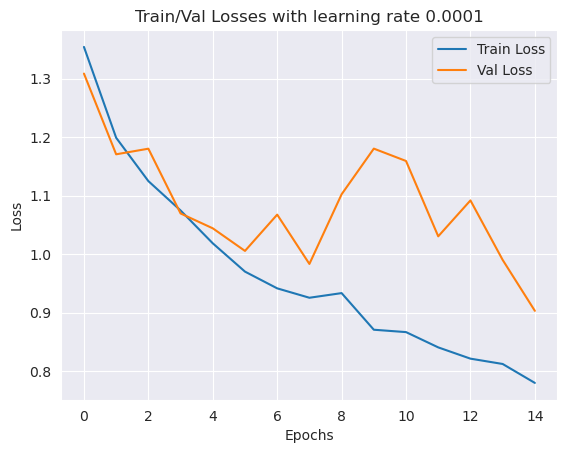

train_losses=[1.3544474574148229, 1.1990569882574968, 1.1249220119455834, 1.0747007067562002, 1.0184753291788988, 0.9700673016984025, 0.9414489752921967, 0.9253613302275219, 0.93331326007274, 0.870662341467805, 0.866595287667254, 0.8404578582199206, 0.821188098348695, 0.8120868486976851, 0.7796718849487123]
[1.3088461827664148, 1.1707509907465132, 1.1803503164223261, 1.0695819173540388, 1.0441388357726356, 1.005490515913282, 1.0675685930819738, 0.9831931075406453, 1.1023523916327764, 1.1804690013329189, 1.1593289533777842, 1.030443214471378, 1.0918785352555533, 0.9901291309368043, 0.902987616875815]
Params lr=0.001, w=0.001, str(opt).split('(')[0].replace(' ', '')="<class'custom_adam.Adam'>"


100%|██████████| 126/126 [00:02<00:00, 47.09it/s]

Epoch [1 out of 15], Train --> loss: 1.9145 & accuracy: 36.59%, Validation --> loss: 1.5945 & accuracy: 35.62%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.88it/s]

Epoch [2 out of 15], Train --> loss: 1.2563 & accuracy: 43.25%, Validation --> loss: 1.2811 & accuracy: 38.61%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.96it/s]

Epoch [3 out of 15], Train --> loss: 1.2699 & accuracy: 37.75%, Validation --> loss: 1.3091 & accuracy: 35.72%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 42.87it/s]

Epoch [4 out of 15], Train --> loss: 1.3178 & accuracy: 31.39%, Validation --> loss: 1.3873 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.03it/s]

Epoch [5 out of 15], Train --> loss: 1.3863 & accuracy: 25.81%, Validation --> loss: 1.3853 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.47it/s]

Epoch [6 out of 15], Train --> loss: 1.3846 & accuracy: 25.39%, Validation --> loss: 1.3849 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.19it/s]

Epoch [7 out of 15], Train --> loss: 1.3842 & accuracy: 26.28%, Validation --> loss: 1.3849 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.68it/s]

Epoch [8 out of 15], Train --> loss: 1.3841 & accuracy: 26.28%, Validation --> loss: 1.3849 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.52it/s]

Epoch [9 out of 15], Train --> loss: 1.3841 & accuracy: 24.82%, Validation --> loss: 1.3850 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.00it/s]

Epoch [10 out of 15], Train --> loss: 1.3841 & accuracy: 26.28%, Validation --> loss: 1.3851 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.30it/s]

Epoch [11 out of 15], Train --> loss: 1.3840 & accuracy: 26.28%, Validation --> loss: 1.3850 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.79it/s]

Epoch [12 out of 15], Train --> loss: 1.3840 & accuracy: 25.81%, Validation --> loss: 1.3851 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.41it/s]

Epoch [13 out of 15], Train --> loss: 1.3841 & accuracy: 25.24%, Validation --> loss: 1.3849 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.61it/s]

Epoch [14 out of 15], Train --> loss: 1.3840 & accuracy: 25.33%, Validation --> loss: 1.3851 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.68it/s]

Epoch [15 out of 15], Train --> loss: 1.3840 & accuracy: 25.27%, Validation --> loss: 1.3851 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 43.04it/s]


Test Accuracy: 25.06%


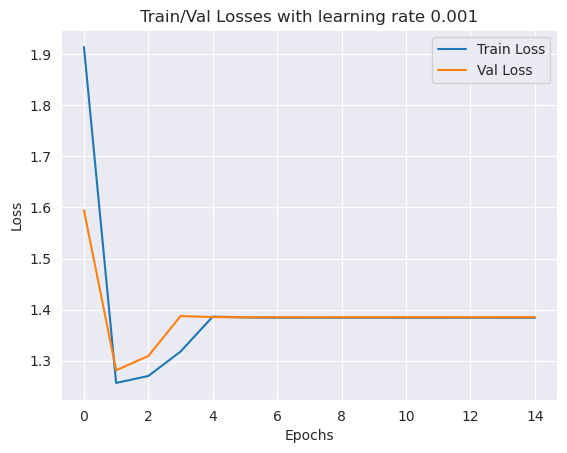

train_losses=[1.914538889198713, 1.2563262748263047, 1.2699087179646003, 1.3178101406746092, 1.3862724344030486, 1.3845823391525158, 1.384151256738813, 1.3840539261947669, 1.3841054604559924, 1.3841319380056887, 1.3840008553001932, 1.3840346703381414, 1.384133958019903, 1.3840351164483227, 1.3840474405265935]
[1.594549680039996, 1.2811333811472332, 1.3090882112109472, 1.3872835711827354, 1.3853045664136372, 1.3848512418686398, 1.3849364064988636, 1.3848784055028642, 1.3850175795100985, 1.385104463213966, 1.3850493289175487, 1.3851482489752391, 1.384933935271369, 1.385072890728239, 1.3851190190466622]
Params lr=0.001, w=0.01, str(opt).split('(')[0].replace(' ', '')="<class'custom_adam.Adam'>"


100%|██████████| 126/126 [00:02<00:00, 49.86it/s]

Epoch [1 out of 15], Train --> loss: 1.8173 & accuracy: 35.84%, Validation --> loss: 1.2657 & accuracy: 37.31%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.25it/s]

Epoch [2 out of 15], Train --> loss: 1.2771 & accuracy: 40.35%, Validation --> loss: 1.3360 & accuracy: 37.01%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.36it/s]

Epoch [3 out of 15], Train --> loss: 1.2747 & accuracy: 42.80%, Validation --> loss: 1.2657 & accuracy: 44.18%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.58it/s]

Epoch [4 out of 15], Train --> loss: 1.2518 & accuracy: 42.98%, Validation --> loss: 1.4260 & accuracy: 25.67%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.90it/s]

Epoch [5 out of 15], Train --> loss: 1.2470 & accuracy: 42.00%, Validation --> loss: 1.2139 & accuracy: 45.77%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.40it/s]

Epoch [6 out of 15], Train --> loss: 1.1818 & accuracy: 45.91%, Validation --> loss: 1.2469 & accuracy: 41.39%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.15it/s]

Epoch [7 out of 15], Train --> loss: 1.1699 & accuracy: 46.65%, Validation --> loss: 1.1809 & accuracy: 45.37%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.76it/s]

Epoch [8 out of 15], Train --> loss: 1.1362 & accuracy: 48.33%, Validation --> loss: 1.1827 & accuracy: 46.07%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.68it/s]

Epoch [9 out of 15], Train --> loss: 1.1405 & accuracy: 48.00%, Validation --> loss: 1.2083 & accuracy: 44.38%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.73it/s]

Epoch [10 out of 15], Train --> loss: 1.1247 & accuracy: 49.58%, Validation --> loss: 1.1586 & accuracy: 47.26%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.37it/s]

Epoch [11 out of 15], Train --> loss: 1.1025 & accuracy: 50.96%, Validation --> loss: 1.1776 & accuracy: 48.06%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.35it/s]

Epoch [12 out of 15], Train --> loss: 1.1039 & accuracy: 50.33%, Validation --> loss: 1.2398 & accuracy: 47.36%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 36.14it/s]

Epoch [13 out of 15], Train --> loss: 1.1141 & accuracy: 49.61%, Validation --> loss: 1.1510 & accuracy: 47.26%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.92it/s]

Epoch [14 out of 15], Train --> loss: 1.0812 & accuracy: 51.43%, Validation --> loss: 1.1928 & accuracy: 44.88%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.17it/s]

Epoch [15 out of 15], Train --> loss: 1.0936 & accuracy: 51.64%, Validation --> loss: 1.1647 & accuracy: 47.86%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 44.51it/s]


Test Accuracy: 47.33%


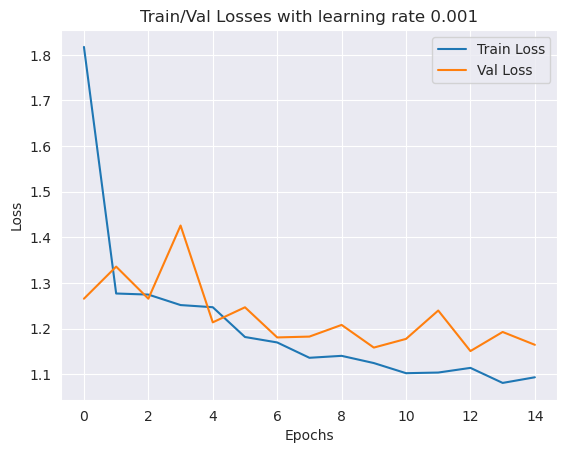

train_losses=[1.8173194529048582, 1.2770833052997088, 1.2747164954718087, 1.2517506865726735, 1.2470386715379136, 1.1817797907496979, 1.1698512247183441, 1.136247986825383, 1.1405018868195982, 1.1247009070221166, 1.1025027092146134, 1.1039064382169583, 1.114120596064019, 1.0811795639252038, 1.0935573294083087]
[1.2656641607246701, 1.3359934356477525, 1.2657066952614557, 1.4259848414905487, 1.2138899952646285, 1.246882847850285, 1.1808514945090762, 1.1826876132261186, 1.2082504682124606, 1.1586077350472648, 1.177607669243737, 1.239784220617915, 1.1509701089253501, 1.1928222605160304, 1.1646789506314292]
Params lr=0.01, w=0.001, str(opt).split('(')[0].replace(' ', '')="<class'custom_adam.Adam'>"


100%|██████████| 126/126 [00:03<00:00, 41.50it/s]

Epoch [1 out of 15], Train --> loss: 5.0880 & accuracy: 24.76%, Validation --> loss: 1.3849 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.26it/s]

Epoch [2 out of 15], Train --> loss: 1.3860 & accuracy: 24.82%, Validation --> loss: 1.3860 & accuracy: 26.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.41it/s]

Epoch [3 out of 15], Train --> loss: 1.3859 & accuracy: 25.09%, Validation --> loss: 1.3855 & accuracy: 26.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.12it/s]

Epoch [4 out of 15], Train --> loss: 1.3854 & accuracy: 25.57%, Validation --> loss: 1.3851 & accuracy: 26.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.87it/s]

Epoch [5 out of 15], Train --> loss: 1.3861 & accuracy: 25.45%, Validation --> loss: 1.3852 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.94it/s]

Epoch [6 out of 15], Train --> loss: 1.3861 & accuracy: 25.33%, Validation --> loss: 1.3853 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.39it/s]

Epoch [7 out of 15], Train --> loss: 1.3859 & accuracy: 25.78%, Validation --> loss: 1.3868 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.71it/s]

Epoch [8 out of 15], Train --> loss: 1.3858 & accuracy: 25.03%, Validation --> loss: 1.3861 & accuracy: 26.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.01it/s]

Epoch [9 out of 15], Train --> loss: 1.3849 & accuracy: 25.33%, Validation --> loss: 1.3891 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.31it/s]

Epoch [10 out of 15], Train --> loss: 1.3864 & accuracy: 25.30%, Validation --> loss: 1.3859 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.09it/s]

Epoch [11 out of 15], Train --> loss: 1.3857 & accuracy: 25.78%, Validation --> loss: 1.3878 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.53it/s]

Epoch [12 out of 15], Train --> loss: 1.3861 & accuracy: 26.40%, Validation --> loss: 1.3853 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.84it/s]

Epoch [13 out of 15], Train --> loss: 1.3856 & accuracy: 25.66%, Validation --> loss: 1.3853 & accuracy: 26.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 42.63it/s]

Epoch [14 out of 15], Train --> loss: 1.3848 & accuracy: 26.91%, Validation --> loss: 1.3887 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.10it/s]

Epoch [15 out of 15], Train --> loss: 1.3864 & accuracy: 25.03%, Validation --> loss: 1.3850 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 43.94it/s]


Test Accuracy: 25.06%


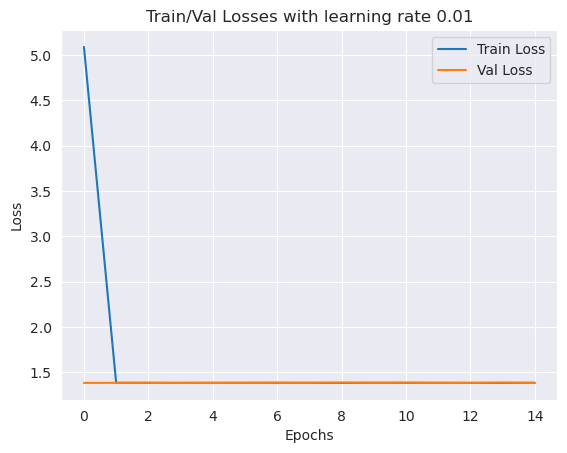

train_losses=[5.0880476557838605, 1.3860310896484265, 1.3859353415436848, 1.3853856726307288, 1.3861408902238832, 1.3861311455046077, 1.3859252306612693, 1.385791623507024, 1.3849115198153585, 1.3863534605872945, 1.3857012332766039, 1.3860612000941093, 1.3855832963114991, 1.3848272291743386, 1.3864092641912382]
[1.3848698527093917, 1.385951300462087, 1.3855080982995411, 1.3850624949213057, 1.3851654737714738, 1.3852819336785211, 1.386794608736795, 1.3861061467064753, 1.3890837043050737, 1.3859496778912015, 1.3878271399982391, 1.3853395619089641, 1.3852881817590623, 1.388692733787355, 1.3850082755088806]
Params lr=0.01, w=0.01, str(opt).split('(')[0].replace(' ', '')="<class'custom_adam.Adam'>"


100%|██████████| 126/126 [00:02<00:00, 47.29it/s]

Epoch [1 out of 15], Train --> loss: 6.0409 & accuracy: 24.73%, Validation --> loss: 1.3859 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.20it/s]

Epoch [2 out of 15], Train --> loss: 1.3856 & accuracy: 26.28%, Validation --> loss: 1.3865 & accuracy: 26.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.36it/s]

Epoch [3 out of 15], Train --> loss: 1.3850 & accuracy: 25.90%, Validation --> loss: 1.3858 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.63it/s]

Epoch [4 out of 15], Train --> loss: 1.3856 & accuracy: 25.78%, Validation --> loss: 1.3862 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.44it/s]

Epoch [5 out of 15], Train --> loss: 1.3855 & accuracy: 25.99%, Validation --> loss: 1.3851 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.30it/s]

Epoch [6 out of 15], Train --> loss: 1.3862 & accuracy: 25.24%, Validation --> loss: 1.3852 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.86it/s]

Epoch [7 out of 15], Train --> loss: 1.3855 & accuracy: 26.02%, Validation --> loss: 1.3851 & accuracy: 26.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.55it/s]

Epoch [8 out of 15], Train --> loss: 1.3858 & accuracy: 25.54%, Validation --> loss: 1.3850 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.92it/s]

Epoch [9 out of 15], Train --> loss: 1.3854 & accuracy: 26.19%, Validation --> loss: 1.3859 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 42.85it/s]

Epoch [10 out of 15], Train --> loss: 1.3865 & accuracy: 25.84%, Validation --> loss: 1.3852 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.99it/s]

Epoch [11 out of 15], Train --> loss: 1.3854 & accuracy: 25.63%, Validation --> loss: 1.3869 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.92it/s]

Epoch [12 out of 15], Train --> loss: 1.3853 & accuracy: 25.96%, Validation --> loss: 1.3866 & accuracy: 26.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 33.08it/s]

Epoch [13 out of 15], Train --> loss: 1.3858 & accuracy: 25.54%, Validation --> loss: 1.3851 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 30.73it/s]

Epoch [14 out of 15], Train --> loss: 1.3845 & accuracy: 26.46%, Validation --> loss: 1.3863 & accuracy: 26.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.09it/s]

Epoch [15 out of 15], Train --> loss: 1.3854 & accuracy: 26.25%, Validation --> loss: 1.3866 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 44.10it/s]


Test Accuracy: 24.13%


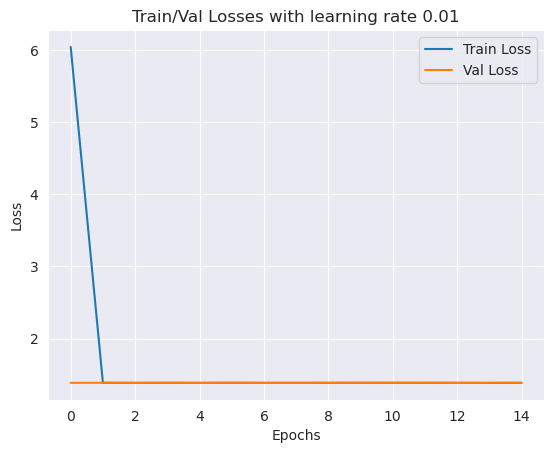

train_losses=[6.040902681168622, 1.3855991005043995, 1.385036221552009, 1.3855500835791976, 1.3854927308235077, 1.3862485336517663, 1.3855445393514518, 1.3857739480981395, 1.3853729326002353, 1.3865233025289094, 1.385434331643553, 1.3853213252201855, 1.3858017005328631, 1.3845335623529476, 1.3854356901742393]
[1.3858621943564642, 1.3864712279940408, 1.3858110327569266, 1.386193767426506, 1.3851325171334403, 1.3852388849334112, 1.3850553168190851, 1.385031162746369, 1.385896330788022, 1.385187718603346, 1.386920313986521, 1.3865571485625372, 1.3850924069919284, 1.3862847553359137, 1.3866115136752053]
Params lr=0.0001, w=0.001, str(opt).split('(')[0].replace(' ', '')="<class'torch.optim.rmsprop.RMSprop'>"


100%|██████████| 126/126 [00:02<00:00, 47.75it/s]

Epoch [1 out of 15], Train --> loss: 1.7521 & accuracy: 34.38%, Validation --> loss: 2.1531 & accuracy: 26.67%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.92it/s]

Epoch [2 out of 15], Train --> loss: 1.3330 & accuracy: 43.82%, Validation --> loss: 1.1110 & accuracy: 52.34%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.60it/s]

Epoch [3 out of 15], Train --> loss: 1.2176 & accuracy: 49.04%, Validation --> loss: 1.1862 & accuracy: 47.26%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.90it/s]

Epoch [4 out of 15], Train --> loss: 1.2111 & accuracy: 48.66%, Validation --> loss: 1.4371 & accuracy: 41.99%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.78it/s]

Epoch [5 out of 15], Train --> loss: 1.1604 & accuracy: 51.73%, Validation --> loss: 1.1853 & accuracy: 51.74%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:05<00:00, 23.54it/s]

Epoch [6 out of 15], Train --> loss: 1.0882 & accuracy: 55.05%, Validation --> loss: 1.2764 & accuracy: 43.38%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 25.54it/s]

Epoch [7 out of 15], Train --> loss: 1.0568 & accuracy: 56.03%, Validation --> loss: 1.1085 & accuracy: 55.02%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 29.39it/s]

Epoch [8 out of 15], Train --> loss: 1.0166 & accuracy: 58.66%, Validation --> loss: 1.0220 & accuracy: 60.10%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 36.46it/s]

Epoch [9 out of 15], Train --> loss: 0.9803 & accuracy: 60.19%, Validation --> loss: 1.1310 & accuracy: 50.15%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 36.32it/s]

Epoch [10 out of 15], Train --> loss: 0.9543 & accuracy: 61.62%, Validation --> loss: 1.6013 & accuracy: 34.13%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 31.89it/s]

Epoch [11 out of 15], Train --> loss: 0.9336 & accuracy: 62.93%, Validation --> loss: 1.2221 & accuracy: 48.46%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 30.82it/s]

Epoch [12 out of 15], Train --> loss: 0.9219 & accuracy: 62.57%, Validation --> loss: 1.1432 & accuracy: 51.04%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 25.33it/s]

Epoch [13 out of 15], Train --> loss: 0.8912 & accuracy: 64.55%, Validation --> loss: 1.1348 & accuracy: 52.94%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 29.45it/s]

Epoch [14 out of 15], Train --> loss: 0.8924 & accuracy: 65.74%, Validation --> loss: 0.9382 & accuracy: 63.28%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 31.68it/s]

Epoch [15 out of 15], Train --> loss: 0.8721 & accuracy: 65.44%, Validation --> loss: 1.0930 & accuracy: 56.62%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 54/54 [00:02<00:00, 24.45it/s]


Test Accuracy: 58.00%


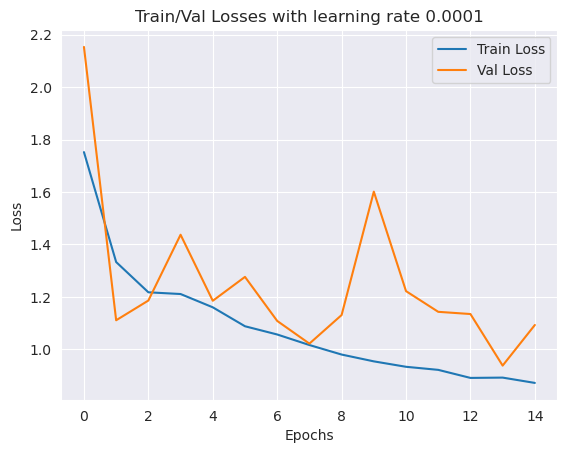

train_losses=[1.7521041677220055, 1.3329808869908135, 1.2176284115752627, 1.2110539782872347, 1.1603804207929278, 1.0881593506205338, 1.0567883859813072, 1.0166055327525856, 0.9802910794363955, 0.9543302584092771, 0.9336329542793921, 0.9219267116526146, 0.8912331335299909, 0.8924102933992919, 0.8721419485343669]
[2.1530842672264767, 1.111017454238165, 1.1862362235311479, 1.4370922999722617, 1.1853078315182337, 1.2763951364017667, 1.1085020403067272, 1.0219575176163325, 1.1309570005488774, 1.6013292854740506, 1.2220932590583014, 1.1431819583688463, 1.1347891553526832, 0.9381775565090633, 1.093034310355073]
Params lr=0.0001, w=0.01, str(opt).split('(')[0].replace(' ', '')="<class'torch.optim.rmsprop.RMSprop'>"


100%|██████████| 126/126 [00:04<00:00, 30.00it/s]

Epoch [1 out of 15], Train --> loss: 1.7200 & accuracy: 35.07%, Validation --> loss: 1.7117 & accuracy: 27.46%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 27.41it/s]

Epoch [2 out of 15], Train --> loss: 1.3783 & accuracy: 42.26%, Validation --> loss: 1.4423 & accuracy: 32.34%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 32.44it/s]

Epoch [3 out of 15], Train --> loss: 1.2608 & accuracy: 46.74%, Validation --> loss: 1.7100 & accuracy: 28.36%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:05<00:00, 22.25it/s]

Epoch [4 out of 15], Train --> loss: 1.1831 & accuracy: 50.00%, Validation --> loss: 1.2408 & accuracy: 49.55%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:05<00:00, 23.34it/s]

Epoch [5 out of 15], Train --> loss: 1.1617 & accuracy: 50.48%, Validation --> loss: 2.3401 & accuracy: 27.56%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 31.80it/s]

Epoch [6 out of 15], Train --> loss: 1.1181 & accuracy: 52.93%, Validation --> loss: 1.3817 & accuracy: 35.92%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:05<00:00, 23.06it/s]

Epoch [7 out of 15], Train --> loss: 1.0831 & accuracy: 54.99%, Validation --> loss: 1.1486 & accuracy: 56.92%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 28.64it/s]

Epoch [8 out of 15], Train --> loss: 1.0733 & accuracy: 55.38%, Validation --> loss: 1.3760 & accuracy: 43.18%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 27.38it/s]

Epoch [9 out of 15], Train --> loss: 1.0409 & accuracy: 57.77%, Validation --> loss: 1.5882 & accuracy: 33.83%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 30.99it/s]

Epoch [10 out of 15], Train --> loss: 1.0273 & accuracy: 58.06%, Validation --> loss: 1.2053 & accuracy: 43.18%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 28.59it/s]

Epoch [11 out of 15], Train --> loss: 1.0054 & accuracy: 59.14%, Validation --> loss: 1.0931 & accuracy: 52.34%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:06<00:00, 20.45it/s]

Epoch [12 out of 15], Train --> loss: 0.9941 & accuracy: 61.11%, Validation --> loss: 1.1258 & accuracy: 51.34%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:05<00:00, 23.62it/s]

Epoch [13 out of 15], Train --> loss: 0.9710 & accuracy: 61.68%, Validation --> loss: 0.9666 & accuracy: 63.78%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:05<00:00, 23.14it/s]

Epoch [14 out of 15], Train --> loss: 0.9675 & accuracy: 60.96%, Validation --> loss: 1.0360 & accuracy: 60.00%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 25.24it/s]

Epoch [15 out of 15], Train --> loss: 0.9518 & accuracy: 61.71%, Validation --> loss: 1.2517 & accuracy: 47.46%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 28.32it/s]


Test Accuracy: 48.72%


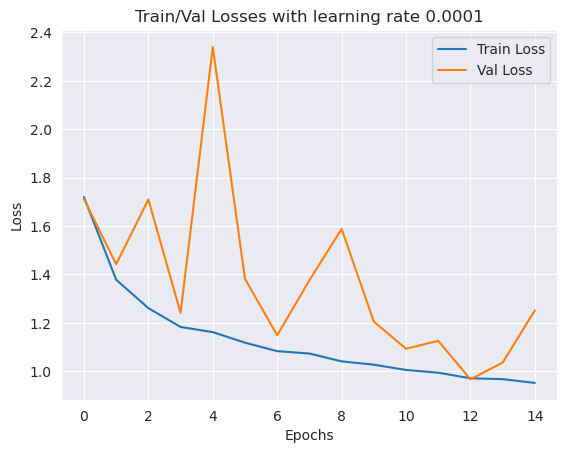

train_losses=[1.7199933416519073, 1.3782817910565397, 1.2608353612246548, 1.1830984612922395, 1.1616857760276886, 1.1181489963235605, 1.0830650919234839, 1.0732783532939265, 1.040856552863747, 1.027252609448103, 1.0053950252993864, 0.9941206065524449, 0.9709599470466305, 0.9675286543113235, 0.9518408862816121]
[1.7116864640561362, 1.442278752251277, 1.7099739502346705, 1.2407791323605037, 2.3400610770498003, 1.3817165593306224, 1.1485698488023546, 1.3759881101903462, 1.5881529171315452, 1.205280573122085, 1.09305068803212, 1.1257990688558608, 0.9666198820821823, 1.0359595872107006, 1.2516710464916532]
Params lr=0.001, w=0.001, str(opt).split('(')[0].replace(' ', '')="<class'torch.optim.rmsprop.RMSprop'>"


100%|██████████| 126/126 [00:04<00:00, 31.28it/s]

Epoch [1 out of 15], Train --> loss: 4.4744 & accuracy: 34.29%, Validation --> loss: 1.2247 & accuracy: 50.35%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 31.94it/s]

Epoch [2 out of 15], Train --> loss: 1.3946 & accuracy: 34.44%, Validation --> loss: 1.3064 & accuracy: 35.42%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 30.38it/s]

Epoch [3 out of 15], Train --> loss: 1.4492 & accuracy: 37.75%, Validation --> loss: 1.2278 & accuracy: 41.89%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 30.29it/s]

Epoch [4 out of 15], Train --> loss: 1.3619 & accuracy: 39.31%, Validation --> loss: 1.3098 & accuracy: 36.92%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 31.47it/s]

Epoch [5 out of 15], Train --> loss: 1.2548 & accuracy: 43.61%, Validation --> loss: 1.2898 & accuracy: 34.93%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 28.17it/s]


Epoch [6 out of 15], Train --> loss: 1.1800 & accuracy: 45.49%, Validation --> loss: 1.1388 & accuracy: 44.08%
Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 31.45it/s]

Epoch [7 out of 15], Train --> loss: 1.1708 & accuracy: 48.03%, Validation --> loss: 1.2489 & accuracy: 40.90%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 28.36it/s]

Epoch [8 out of 15], Train --> loss: 1.1392 & accuracy: 49.25%, Validation --> loss: 1.3145 & accuracy: 37.41%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 28.79it/s]

Epoch [9 out of 15], Train --> loss: 1.1123 & accuracy: 49.94%, Validation --> loss: 1.1485 & accuracy: 48.16%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 27.27it/s]

Epoch [10 out of 15], Train --> loss: 1.1240 & accuracy: 48.54%, Validation --> loss: 1.1111 & accuracy: 50.55%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 31.07it/s]

Epoch [11 out of 15], Train --> loss: 1.1100 & accuracy: 50.63%, Validation --> loss: 1.2749 & accuracy: 45.87%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 31.52it/s]

Epoch [12 out of 15], Train --> loss: 1.0896 & accuracy: 51.52%, Validation --> loss: 1.0674 & accuracy: 49.85%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 31.61it/s]

Epoch [13 out of 15], Train --> loss: 1.0811 & accuracy: 51.70%, Validation --> loss: 1.1713 & accuracy: 47.06%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 30.68it/s]

Epoch [14 out of 15], Train --> loss: 1.0885 & accuracy: 51.34%, Validation --> loss: 1.0580 & accuracy: 52.14%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:05<00:00, 25.12it/s]

Epoch [15 out of 15], Train --> loss: 1.0707 & accuracy: 52.63%, Validation --> loss: 1.2591 & accuracy: 42.49%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 29.61it/s]


Test Accuracy: 44.32%


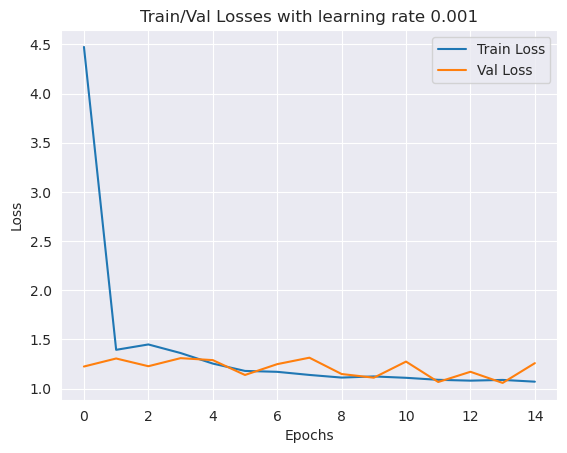

train_losses=[4.474353689282492, 1.3945799386017648, 1.449161986818177, 1.3618752337583209, 1.2547910342922075, 1.1799882562177562, 1.1708277610435123, 1.1392471273218532, 1.1122812596738765, 1.123985498716837, 1.1100080722413939, 1.0895629296154852, 1.0811140710101208, 1.0884915034782345, 1.07066278831771]
[1.2247396565618969, 1.3063883317841425, 1.2278207819613198, 1.3098170937053741, 1.289808751571746, 1.1388325837869493, 1.2488923318802365, 1.3144517025304219, 1.1484832716366602, 1.1111432285535903, 1.2748715089900153, 1.0673648814360301, 1.171300483128381, 1.0579924933494083, 1.2590953199163315]
Params lr=0.001, w=0.01, str(opt).split('(')[0].replace(' ', '')="<class'torch.optim.rmsprop.RMSprop'>"


100%|██████████| 126/126 [00:03<00:00, 32.13it/s]

Epoch [1 out of 15], Train --> loss: 8.4041 & accuracy: 30.79%, Validation --> loss: 1.7907 & accuracy: 27.26%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 31.77it/s]

Epoch [2 out of 15], Train --> loss: 1.5512 & accuracy: 32.41%, Validation --> loss: 1.3858 & accuracy: 25.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 31.76it/s]

Epoch [3 out of 15], Train --> loss: 1.5234 & accuracy: 26.11%, Validation --> loss: 1.3850 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 30.75it/s]

Epoch [4 out of 15], Train --> loss: 1.4094 & accuracy: 25.87%, Validation --> loss: 1.3850 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 29.74it/s]

Epoch [5 out of 15], Train --> loss: 1.4074 & accuracy: 25.18%, Validation --> loss: 1.3849 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 30.44it/s]

Epoch [6 out of 15], Train --> loss: 1.3924 & accuracy: 23.63%, Validation --> loss: 1.3848 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:05<00:00, 23.22it/s]

Epoch [7 out of 15], Train --> loss: 1.3944 & accuracy: 25.42%, Validation --> loss: 1.3851 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:05<00:00, 24.29it/s]

Epoch [8 out of 15], Train --> loss: 1.3842 & accuracy: 25.78%, Validation --> loss: 1.3849 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 30.66it/s]

Epoch [9 out of 15], Train --> loss: 1.3842 & accuracy: 26.02%, Validation --> loss: 1.3850 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:05<00:00, 24.61it/s]

Epoch [10 out of 15], Train --> loss: 1.3841 & accuracy: 25.87%, Validation --> loss: 1.3850 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:05<00:00, 21.11it/s]

Epoch [11 out of 15], Train --> loss: 1.3841 & accuracy: 26.19%, Validation --> loss: 1.3850 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:05<00:00, 24.13it/s]

Epoch [12 out of 15], Train --> loss: 1.3841 & accuracy: 25.54%, Validation --> loss: 1.3849 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 27.12it/s]

Epoch [13 out of 15], Train --> loss: 1.3841 & accuracy: 25.90%, Validation --> loss: 1.3850 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 28.66it/s]

Epoch [14 out of 15], Train --> loss: 1.3841 & accuracy: 25.99%, Validation --> loss: 1.3849 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 28.79it/s]

Epoch [15 out of 15], Train --> loss: 1.3841 & accuracy: 25.78%, Validation --> loss: 1.3850 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 29.47it/s]


Test Accuracy: 25.06%


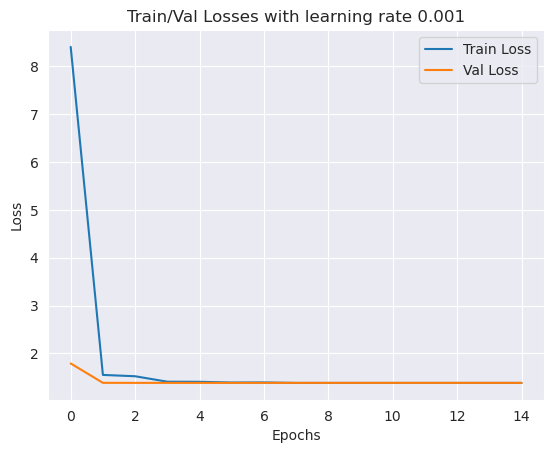

train_losses=[8.404120574987589, 1.5511677565324278, 1.5234420501531452, 1.4093594036125057, 1.4073885181354167, 1.3924182744470017, 1.3944183804254828, 1.3841518963151445, 1.3841514209005314, 1.3840591270200961, 1.3841218680925755, 1.384121362520004, 1.3840547401751424, 1.3841475666565086, 1.38405714626813]
[1.7907327687929546, 1.3858043929887196, 1.38503226590535, 1.3849570628196475, 1.3849475024238465, 1.3848491140774317, 1.3850695973350888, 1.3849093601817177, 1.3849920583149744, 1.384974982057299, 1.3850105187249562, 1.3849160775305733, 1.3850375972096882, 1.3849142458703783, 1.3849863220774938]
Params lr=0.01, w=0.001, str(opt).split('(')[0].replace(' ', '')="<class'torch.optim.rmsprop.RMSprop'>"


100%|██████████| 126/126 [00:03<00:00, 31.68it/s]

Epoch [1 out of 15], Train --> loss: 76.9257 & accuracy: 26.49%, Validation --> loss: 1.3854 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 30.82it/s]

Epoch [2 out of 15], Train --> loss: 4.2263 & accuracy: 24.64%, Validation --> loss: 1.3864 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 32.50it/s]

Epoch [3 out of 15], Train --> loss: 11.8130 & accuracy: 26.58%, Validation --> loss: 1.3863 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 30.86it/s]

Epoch [4 out of 15], Train --> loss: 3.1701 & accuracy: 25.33%, Validation --> loss: 1.3854 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 32.05it/s]

Epoch [5 out of 15], Train --> loss: 2.2856 & accuracy: 25.45%, Validation --> loss: 1.3862 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 31.37it/s]

Epoch [6 out of 15], Train --> loss: 2.0973 & accuracy: 25.39%, Validation --> loss: 1.3883 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:05<00:00, 23.06it/s]

Epoch [7 out of 15], Train --> loss: 1.3848 & accuracy: 25.96%, Validation --> loss: 1.3852 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:05<00:00, 23.80it/s]

Epoch [8 out of 15], Train --> loss: 1.3860 & accuracy: 24.67%, Validation --> loss: 1.3869 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 31.51it/s]

Epoch [9 out of 15], Train --> loss: 1.3857 & accuracy: 25.21%, Validation --> loss: 1.3863 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:05<00:00, 23.35it/s]

Epoch [10 out of 15], Train --> loss: 1.3849 & accuracy: 26.91%, Validation --> loss: 1.3869 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 31.59it/s]

Epoch [11 out of 15], Train --> loss: 1.3860 & accuracy: 25.96%, Validation --> loss: 1.3854 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 31.40it/s]

Epoch [12 out of 15], Train --> loss: 1.3857 & accuracy: 25.36%, Validation --> loss: 1.3856 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 30.85it/s]

Epoch [13 out of 15], Train --> loss: 1.3855 & accuracy: 26.43%, Validation --> loss: 1.3868 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 29.97it/s]

Epoch [14 out of 15], Train --> loss: 1.3863 & accuracy: 25.54%, Validation --> loss: 1.3855 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 31.09it/s]

Epoch [15 out of 15], Train --> loss: 1.3860 & accuracy: 24.79%, Validation --> loss: 1.3854 & accuracy: 26.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 28.86it/s]


Test Accuracy: 27.38%


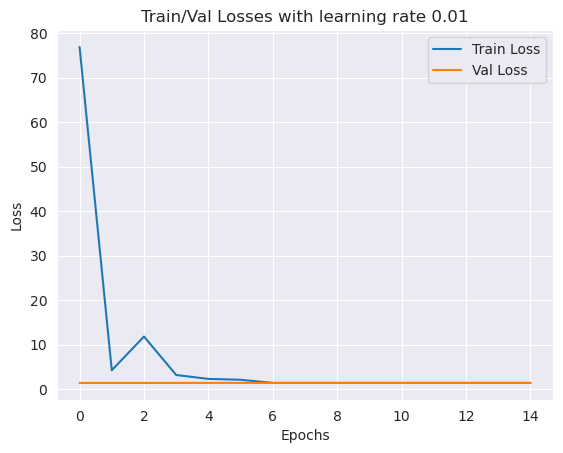

train_losses=[76.92566103923862, 4.226289458946282, 11.812987866151305, 3.1700819457629983, 2.285578182887348, 2.0973109809197217, 1.3847659004047548, 1.3859878013128313, 1.385739584526754, 1.3848916701883576, 1.3860472349676711, 1.3857309516688234, 1.3854738123946087, 1.3863389506260364, 1.3859979693815645]
[1.3854467471440632, 1.3864383404217069, 1.38629749937663, 1.3854006491010151, 1.3861553933885362, 1.3882660194048806, 1.385197713261559, 1.3868518831237915, 1.3862543569670782, 1.3868613299869357, 1.3853736595501975, 1.3856330040901426, 1.386753243113321, 1.38552588224411, 1.3853893601705158]
Params lr=0.01, w=0.01, str(opt).split('(')[0].replace(' ', '')="<class'torch.optim.rmsprop.RMSprop'>"


100%|██████████| 126/126 [00:03<00:00, 31.51it/s]

Epoch [1 out of 15], Train --> loss: 81.7436 & accuracy: 25.75%, Validation --> loss: 1.3884 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 32.27it/s]

Epoch [2 out of 15], Train --> loss: 7.0940 & accuracy: 25.36%, Validation --> loss: 1.3865 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 29.94it/s]

Epoch [3 out of 15], Train --> loss: 7.5664 & accuracy: 24.91%, Validation --> loss: 1.3868 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 31.81it/s]

Epoch [4 out of 15], Train --> loss: 1.3859 & accuracy: 25.51%, Validation --> loss: 1.3859 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 31.85it/s]

Epoch [5 out of 15], Train --> loss: 1.5268 & accuracy: 25.75%, Validation --> loss: 1.3884 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 26.74it/s]

Epoch [6 out of 15], Train --> loss: 1.3855 & accuracy: 27.15%, Validation --> loss: 1.3861 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 31.07it/s]

Epoch [7 out of 15], Train --> loss: 1.3860 & accuracy: 25.63%, Validation --> loss: 1.3853 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 29.20it/s]

Epoch [8 out of 15], Train --> loss: 1.3858 & accuracy: 25.30%, Validation --> loss: 1.3863 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 30.31it/s]

Epoch [9 out of 15], Train --> loss: 1.3856 & accuracy: 25.24%, Validation --> loss: 1.3855 & accuracy: 26.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 31.88it/s]

Epoch [10 out of 15], Train --> loss: 1.3859 & accuracy: 25.54%, Validation --> loss: 1.3855 & accuracy: 26.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 29.78it/s]

Epoch [11 out of 15], Train --> loss: 1.3855 & accuracy: 25.99%, Validation --> loss: 1.3870 & accuracy: 26.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 30.68it/s]

Epoch [12 out of 15], Train --> loss: 1.3859 & accuracy: 25.99%, Validation --> loss: 1.3882 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:05<00:00, 23.24it/s]

Epoch [13 out of 15], Train --> loss: 1.3853 & accuracy: 25.21%, Validation --> loss: 1.3901 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 31.23it/s]

Epoch [14 out of 15], Train --> loss: 1.3864 & accuracy: 24.37%, Validation --> loss: 1.3855 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 31.29it/s]

Epoch [15 out of 15], Train --> loss: 1.3856 & accuracy: 24.67%, Validation --> loss: 1.3855 & accuracy: 26.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 28.27it/s]


Test Accuracy: 27.38%


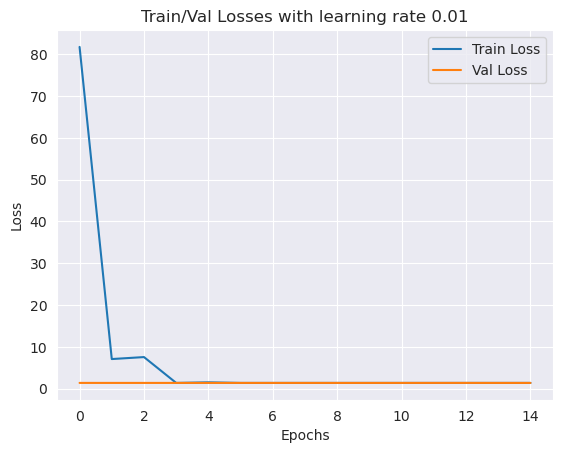

train_losses=[81.74362184551849, 7.094004825362158, 7.5664256648971815, 1.3859363424465025, 1.5268217911299202, 1.3854819339897866, 1.38600909539225, 1.3857736487946248, 1.3856102919521651, 1.3859273283464528, 1.385488046951112, 1.385884281559036, 1.3853084210279734, 1.3863698033558156, 1.385630592241492]
[1.3884433337620325, 1.3864633885640947, 1.3867727414010063, 1.385878769178239, 1.3884095653655038, 1.3861239912017944, 1.3853018719052512, 1.3862535196637351, 1.385503884345766, 1.3855134693403093, 1.3870236268119207, 1.388247769976419, 1.3900924816964164, 1.3855269958102514, 1.3854632330319239]


In [22]:
import torch
import matplotlib.pyplot as plt
from custom_adam import Adam

num_epochs = 15
weight_decay_list = [0.001, 0.01]
learning_rates = [0.0001, 0.001, 0.01] 
optimizers = [optim.SGD, Adam, optim.RMSprop]  

for opt in optimizers:
    for lr in learning_rates:
        for w in weight_decay_list:
            model = AircraftNet(_input=IMAGE_HEIGHT*IMAGE_WIDTH*3, 
                                hidden_size=256, 
                                _output=4).to(device)
        
            print(f"Params {lr=}, {w=}, {str(opt).split('(')[0].replace(' ', '')=}")
            train_losses, val_losses, res = train_model(model, opt, train_data_loader, val_data_loader, num_epochs, lr, weight_decay=w, df=res)
        
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for batch_idx, (images, labels) in enumerate(tqdm(test_data_loader)):
                    images = images.view(-1, IMAGE_HEIGHT*IMAGE_WIDTH*3).to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            accuracy = correct / total
            print(f"Test Accuracy: {100 * accuracy:.2f}%")
        
            plt.plot(range(num_epochs), train_losses, label='Train Loss')
            plt.plot(range(num_epochs), val_losses, label='Val Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title(f'Train/Val Losses with learning rate {lr}')
            plt.legend()
            plt.show()
            
            print(f"{train_losses=}\n{val_losses}")

In [23]:
res

,opt,best_acc,lr,weight_decay,best_accuracy
0,SGD,NaN,0.0001,0.001,0.495522
0,SGD,NaN,0.0001,0.010,0.513433
0,SGD,NaN,0.0010,0.001,0.627861
0,SGD,NaN,0.0010,0.010,0.622886
0,SGD,NaN,0.0100,0.001,0.623881
0,SGD,NaN,0.0100,0.010,0.520398
0,Adam,NaN,0.0001,0.001,0.646766
0,Adam,NaN,0.0001,0.010,0.640796
0,Adam,NaN,0.0010,0.001,0.386070
0,Adam,NaN,0.0010,0.010,0.480597


## Fine Tuning

Давайте обучим модели с топ-5 лучшими параметрами и возьмем лучший из них. Мы видим на графике потерь train/val, эта нейронная сеть может достичь лучших результатов.

Params lr=0.0001, w=0.001, opt=<class 'custom_adam.Adam'>


100%|██████████| 126/126 [00:03<00:00, 40.23it/s]

Epoch [1 out of 50], Train --> loss: 1.3834 & accuracy: 36.47%, Validation --> loss: 1.3251 & accuracy: 35.92%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.67it/s]

Epoch [2 out of 50], Train --> loss: 1.2545 & accuracy: 45.04%, Validation --> loss: 1.2282 & accuracy: 51.24%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.35it/s]

Epoch [3 out of 50], Train --> loss: 1.1641 & accuracy: 50.60%, Validation --> loss: 1.1693 & accuracy: 45.77%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.70it/s]


Epoch [4 out of 50], Train --> loss: 1.0998 & accuracy: 55.23%, Validation --> loss: 1.0772 & accuracy: 57.31%
Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.26it/s]

Epoch [5 out of 50], Train --> loss: 1.0551 & accuracy: 57.32%, Validation --> loss: 1.1530 & accuracy: 45.97%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.13it/s]

Epoch [6 out of 50], Train --> loss: 1.0153 & accuracy: 59.50%, Validation --> loss: 1.0808 & accuracy: 55.22%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:05<00:00, 23.37it/s]

Epoch [7 out of 50], Train --> loss: 0.9791 & accuracy: 60.99%, Validation --> loss: 1.0193 & accuracy: 56.82%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:05<00:00, 21.63it/s]

Epoch [8 out of 50], Train --> loss: 0.9365 & accuracy: 64.10%, Validation --> loss: 1.0403 & accuracy: 55.42%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 30.06it/s]

Epoch [9 out of 50], Train --> loss: 0.9148 & accuracy: 64.73%, Validation --> loss: 0.9819 & accuracy: 62.69%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 30.63it/s]

Epoch [10 out of 50], Train --> loss: 0.8842 & accuracy: 66.04%, Validation --> loss: 0.9818 & accuracy: 60.30%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 25.99it/s]

Epoch [11 out of 50], Train --> loss: 0.8934 & accuracy: 65.02%, Validation --> loss: 0.9708 & accuracy: 59.00%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 29.75it/s]

Epoch [12 out of 50], Train --> loss: 0.8554 & accuracy: 67.23%, Validation --> loss: 0.9629 & accuracy: 61.09%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 30.50it/s]

Epoch [13 out of 50], Train --> loss: 0.8294 & accuracy: 69.03%, Validation --> loss: 0.9235 & accuracy: 63.88%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 27.87it/s]

Epoch [14 out of 50], Train --> loss: 0.8072 & accuracy: 69.41%, Validation --> loss: 0.9346 & accuracy: 65.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:05<00:00, 23.39it/s]

Epoch [15 out of 50], Train --> loss: 0.7978 & accuracy: 70.19%, Validation --> loss: 0.9726 & accuracy: 61.19%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:05<00:00, 23.97it/s]

Epoch [16 out of 50], Train --> loss: 0.7835 & accuracy: 70.43%, Validation --> loss: 0.9328 & accuracy: 61.09%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:05<00:00, 24.55it/s]

Epoch [17 out of 50], Train --> loss: 0.7697 & accuracy: 71.12%, Validation --> loss: 1.1563 & accuracy: 53.63%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 27.31it/s]

Epoch [18 out of 50], Train --> loss: 0.7542 & accuracy: 72.37%, Validation --> loss: 0.9362 & accuracy: 64.18%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 29.90it/s]

Epoch [19 out of 50], Train --> loss: 0.7227 & accuracy: 72.79%, Validation --> loss: 0.9725 & accuracy: 60.70%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 28.53it/s]

Epoch [20 out of 50], Train --> loss: 0.7284 & accuracy: 72.88%, Validation --> loss: 0.9240 & accuracy: 62.39%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 26.07it/s]

Epoch [21 out of 50], Train --> loss: 0.7110 & accuracy: 73.12%, Validation --> loss: 0.8862 & accuracy: 66.67%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 31.04it/s]

Epoch [22 out of 50], Train --> loss: 0.6819 & accuracy: 75.60%, Validation --> loss: 0.9672 & accuracy: 61.19%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.04it/s]

Epoch [23 out of 50], Train --> loss: 0.6869 & accuracy: 75.00%, Validation --> loss: 0.9456 & accuracy: 65.37%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 37.15it/s]

Epoch [24 out of 50], Train --> loss: 0.6877 & accuracy: 75.27%, Validation --> loss: 1.1687 & accuracy: 52.84%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.52it/s]

Epoch [25 out of 50], Train --> loss: 0.6867 & accuracy: 74.94%, Validation --> loss: 0.8703 & accuracy: 68.96%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.03it/s]

Epoch [26 out of 50], Train --> loss: 0.6207 & accuracy: 77.72%, Validation --> loss: 0.9172 & accuracy: 64.78%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.70it/s]

Epoch [27 out of 50], Train --> loss: 0.6211 & accuracy: 77.72%, Validation --> loss: 0.9065 & accuracy: 67.06%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 39.49it/s]

Epoch [28 out of 50], Train --> loss: 0.6194 & accuracy: 77.30%, Validation --> loss: 0.9384 & accuracy: 65.17%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 37.19it/s]

Epoch [29 out of 50], Train --> loss: 0.6134 & accuracy: 78.35%, Validation --> loss: 0.8755 & accuracy: 67.26%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 33.45it/s]

Epoch [30 out of 50], Train --> loss: 0.5968 & accuracy: 78.20%, Validation --> loss: 0.9188 & accuracy: 63.58%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 30.25it/s]

Epoch [31 out of 50], Train --> loss: 0.5856 & accuracy: 78.32%, Validation --> loss: 0.9517 & accuracy: 65.67%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 34.76it/s]

Epoch [32 out of 50], Train --> loss: 0.5658 & accuracy: 79.57%, Validation --> loss: 0.8914 & accuracy: 68.46%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 39.21it/s]

Epoch [33 out of 50], Train --> loss: 0.5861 & accuracy: 78.73%, Validation --> loss: 0.9270 & accuracy: 61.99%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 31.50it/s]

Epoch [34 out of 50], Train --> loss: 0.5496 & accuracy: 80.73%, Validation --> loss: 0.9260 & accuracy: 66.77%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 38.71it/s]

Epoch [35 out of 50], Train --> loss: 0.5405 & accuracy: 81.54%, Validation --> loss: 0.9331 & accuracy: 64.38%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 42.10it/s]

Epoch [36 out of 50], Train --> loss: 0.5220 & accuracy: 81.87%, Validation --> loss: 1.0132 & accuracy: 63.58%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.42it/s]

Epoch [37 out of 50], Train --> loss: 0.5215 & accuracy: 81.45%, Validation --> loss: 0.8441 & accuracy: 68.16%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.28it/s]

Epoch [38 out of 50], Train --> loss: 0.5126 & accuracy: 81.93%, Validation --> loss: 0.9080 & accuracy: 68.16%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.98it/s]

Epoch [39 out of 50], Train --> loss: 0.4852 & accuracy: 82.47%, Validation --> loss: 0.8598 & accuracy: 65.37%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.01it/s]

Epoch [40 out of 50], Train --> loss: 0.4911 & accuracy: 82.59%, Validation --> loss: 0.9337 & accuracy: 66.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 39.62it/s]

Epoch [41 out of 50], Train --> loss: 0.4814 & accuracy: 82.95%, Validation --> loss: 0.8967 & accuracy: 66.77%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 31.17it/s]

Epoch [42 out of 50], Train --> loss: 0.4618 & accuracy: 83.69%, Validation --> loss: 0.8847 & accuracy: 66.17%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 42.46it/s]

Epoch [43 out of 50], Train --> loss: 0.4552 & accuracy: 83.84%, Validation --> loss: 0.9555 & accuracy: 63.58%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.28it/s]

Epoch [44 out of 50], Train --> loss: 0.4530 & accuracy: 84.44%, Validation --> loss: 0.8360 & accuracy: 70.15%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.03it/s]

Epoch [45 out of 50], Train --> loss: 0.4623 & accuracy: 83.45%, Validation --> loss: 0.9041 & accuracy: 64.48%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.19it/s]

Epoch [46 out of 50], Train --> loss: 0.4269 & accuracy: 85.51%, Validation --> loss: 1.0760 & accuracy: 64.18%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.37it/s]

Epoch [47 out of 50], Train --> loss: 0.4321 & accuracy: 84.95%, Validation --> loss: 0.9779 & accuracy: 64.98%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 30.02it/s]

Epoch [48 out of 50], Train --> loss: 0.4120 & accuracy: 86.14%, Validation --> loss: 0.8718 & accuracy: 68.86%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 43.93it/s]

Epoch [49 out of 50], Train --> loss: 0.4199 & accuracy: 85.90%, Validation --> loss: 0.8863 & accuracy: 68.86%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.59it/s]

Epoch [50 out of 50], Train --> loss: 0.3732 & accuracy: 86.68%, Validation --> loss: 1.0311 & accuracy: 61.99%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 37.04it/s]


Test Accuracy: 64.04%


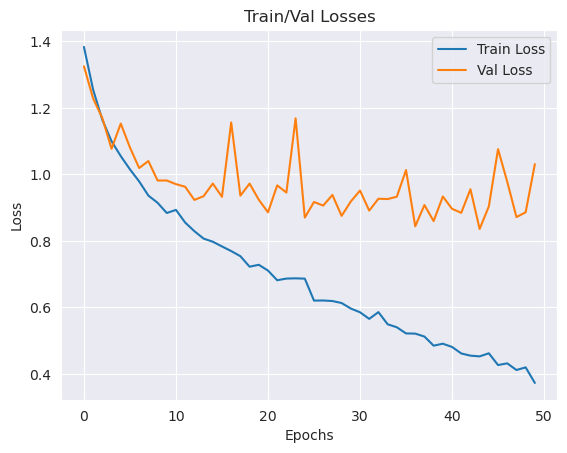

train_losses=[1.3834345171445879, 1.25445972507495, 1.1641091509479895, 1.0998290693276254, 1.055136712894804, 1.0152622710264383, 0.9790622746318508, 0.9365276085448436, 0.9147862086432645, 0.8841910540773078, 0.8933819536662044, 0.8553527918664254, 0.8294181295610555, 0.8071576969293535, 0.7977605397704108, 0.7835231628935775, 0.7696881542484629, 0.7541876171397708, 0.7226599328273237, 0.728365328794163, 0.7110106494268825, 0.6819210492767981, 0.6869284883497154, 0.6876769472527049, 0.6867488701616665, 0.6206645634478771, 0.621058334100787, 0.619434229442783, 0.6133998574106676, 0.5968380627669128, 0.585637090669896, 0.5657821241099397, 0.5860647408731797, 0.5495733036381817, 0.5404868393531848, 0.5220091993740464, 0.5214720010615191, 0.5126125561273468, 0.48521283722364816, 0.4911217094001167, 0.48137497468040213, 0.46184883737905497, 0.4551765121306184, 0.45303668065756775, 0.4622770019657999, 0.42691651131593245, 0.4320833276165983, 0.41204333765018814, 0.41993162986380106, 0.3731

100%|██████████| 126/126 [00:02<00:00, 48.90it/s]

Epoch [1 out of 50], Train --> loss: 1.3657 & accuracy: 35.96%, Validation --> loss: 1.2382 & accuracy: 50.05%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 32.97it/s]

Epoch [2 out of 50], Train --> loss: 1.2311 & accuracy: 45.34%, Validation --> loss: 1.2000 & accuracy: 54.43%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.31it/s]

Epoch [3 out of 50], Train --> loss: 1.1389 & accuracy: 52.81%, Validation --> loss: 1.1934 & accuracy: 51.54%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.33it/s]

Epoch [4 out of 50], Train --> loss: 1.1025 & accuracy: 55.47%, Validation --> loss: 1.1350 & accuracy: 51.14%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 43.87it/s]

Epoch [5 out of 50], Train --> loss: 1.0466 & accuracy: 58.60%, Validation --> loss: 1.1099 & accuracy: 52.04%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.77it/s]

Epoch [6 out of 50], Train --> loss: 0.9946 & accuracy: 61.41%, Validation --> loss: 1.1404 & accuracy: 51.24%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.23it/s]

Epoch [7 out of 50], Train --> loss: 0.9674 & accuracy: 62.34%, Validation --> loss: 1.2313 & accuracy: 45.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.15it/s]

Epoch [8 out of 50], Train --> loss: 0.9437 & accuracy: 63.38%, Validation --> loss: 0.9794 & accuracy: 62.79%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.55it/s]

Epoch [9 out of 50], Train --> loss: 0.9263 & accuracy: 64.04%, Validation --> loss: 1.0185 & accuracy: 57.71%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 37.21it/s]

Epoch [10 out of 50], Train --> loss: 0.8973 & accuracy: 65.26%, Validation --> loss: 0.9744 & accuracy: 62.99%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.59it/s]

Epoch [11 out of 50], Train --> loss: 0.8864 & accuracy: 66.46%, Validation --> loss: 1.0809 & accuracy: 57.21%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.92it/s]

Epoch [12 out of 50], Train --> loss: 0.8556 & accuracy: 67.26%, Validation --> loss: 0.9793 & accuracy: 59.90%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 32.87it/s]

Epoch [13 out of 50], Train --> loss: 0.8192 & accuracy: 69.38%, Validation --> loss: 0.9279 & accuracy: 62.59%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.27it/s]

Epoch [14 out of 50], Train --> loss: 0.8325 & accuracy: 68.37%, Validation --> loss: 0.9743 & accuracy: 59.20%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.14it/s]

Epoch [15 out of 50], Train --> loss: 0.7834 & accuracy: 71.48%, Validation --> loss: 0.9344 & accuracy: 64.18%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 41.85it/s]

Epoch [16 out of 50], Train --> loss: 0.7765 & accuracy: 71.15%, Validation --> loss: 0.9246 & accuracy: 62.29%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 38.95it/s]

Epoch [17 out of 50], Train --> loss: 0.7712 & accuracy: 71.59%, Validation --> loss: 0.9079 & accuracy: 65.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.21it/s]

Epoch [18 out of 50], Train --> loss: 0.7466 & accuracy: 72.61%, Validation --> loss: 1.1516 & accuracy: 54.23%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.80it/s]

Epoch [19 out of 50], Train --> loss: 0.7408 & accuracy: 72.49%, Validation --> loss: 0.8914 & accuracy: 64.48%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.93it/s]

Epoch [20 out of 50], Train --> loss: 0.7056 & accuracy: 74.43%, Validation --> loss: 0.9681 & accuracy: 60.30%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.95it/s]

Epoch [21 out of 50], Train --> loss: 0.6902 & accuracy: 73.98%, Validation --> loss: 0.9842 & accuracy: 60.60%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 41.21it/s]

Epoch [22 out of 50], Train --> loss: 0.6708 & accuracy: 76.31%, Validation --> loss: 0.8981 & accuracy: 65.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.21it/s]

Epoch [23 out of 50], Train --> loss: 0.6903 & accuracy: 74.25%, Validation --> loss: 0.9855 & accuracy: 61.49%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.92it/s]


Epoch [24 out of 50], Train --> loss: 0.6704 & accuracy: 75.39%, Validation --> loss: 0.9531 & accuracy: 64.48%
Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.16it/s]

Epoch [25 out of 50], Train --> loss: 0.6487 & accuracy: 76.31%, Validation --> loss: 0.9008 & accuracy: 65.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.87it/s]

Epoch [26 out of 50], Train --> loss: 0.6426 & accuracy: 77.18%, Validation --> loss: 0.9007 & accuracy: 67.46%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 29.86it/s]

Epoch [27 out of 50], Train --> loss: 0.6198 & accuracy: 77.12%, Validation --> loss: 0.9276 & accuracy: 65.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 27.63it/s]

Epoch [28 out of 50], Train --> loss: 0.6294 & accuracy: 76.73%, Validation --> loss: 0.9379 & accuracy: 59.80%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 43.32it/s]

Epoch [29 out of 50], Train --> loss: 0.5871 & accuracy: 79.15%, Validation --> loss: 0.8928 & accuracy: 65.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 36.47it/s]

Epoch [30 out of 50], Train --> loss: 0.5883 & accuracy: 78.02%, Validation --> loss: 0.8829 & accuracy: 67.36%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.20it/s]

Epoch [31 out of 50], Train --> loss: 0.5606 & accuracy: 79.84%, Validation --> loss: 0.9604 & accuracy: 62.89%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.23it/s]

Epoch [32 out of 50], Train --> loss: 0.5516 & accuracy: 80.53%, Validation --> loss: 0.8981 & accuracy: 64.38%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.04it/s]

Epoch [33 out of 50], Train --> loss: 0.5724 & accuracy: 78.55%, Validation --> loss: 0.9055 & accuracy: 68.06%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 39.17it/s]

Epoch [34 out of 50], Train --> loss: 0.5397 & accuracy: 81.18%, Validation --> loss: 0.8972 & accuracy: 68.16%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:05<00:00, 23.88it/s]

Epoch [35 out of 50], Train --> loss: 0.5547 & accuracy: 79.90%, Validation --> loss: 0.8717 & accuracy: 68.56%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:05<00:00, 23.57it/s]

Epoch [36 out of 50], Train --> loss: 0.5034 & accuracy: 81.87%, Validation --> loss: 0.8581 & accuracy: 66.17%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 31.98it/s]

Epoch [37 out of 50], Train --> loss: 0.5324 & accuracy: 81.12%, Validation --> loss: 0.8238 & accuracy: 68.26%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 28.52it/s]

Epoch [38 out of 50], Train --> loss: 0.4829 & accuracy: 83.03%, Validation --> loss: 1.1449 & accuracy: 62.79%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 31.53it/s]

Epoch [39 out of 50], Train --> loss: 0.4706 & accuracy: 83.24%, Validation --> loss: 1.0204 & accuracy: 63.18%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 29.56it/s]

Epoch [40 out of 50], Train --> loss: 0.4597 & accuracy: 84.20%, Validation --> loss: 0.8958 & accuracy: 67.26%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 25.53it/s]

Epoch [41 out of 50], Train --> loss: 0.4649 & accuracy: 83.60%, Validation --> loss: 0.8619 & accuracy: 69.55%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 26.08it/s]

Epoch [42 out of 50], Train --> loss: 0.4443 & accuracy: 84.29%, Validation --> loss: 0.8256 & accuracy: 69.95%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 26.25it/s]

Epoch [43 out of 50], Train --> loss: 0.4395 & accuracy: 84.77%, Validation --> loss: 0.9077 & accuracy: 69.65%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 31.23it/s]

Epoch [44 out of 50], Train --> loss: 0.4356 & accuracy: 84.80%, Validation --> loss: 0.8734 & accuracy: 68.76%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 31.77it/s]

Epoch [45 out of 50], Train --> loss: 0.4228 & accuracy: 85.04%, Validation --> loss: 0.9056 & accuracy: 67.96%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 28.03it/s]

Epoch [46 out of 50], Train --> loss: 0.4286 & accuracy: 85.07%, Validation --> loss: 0.9180 & accuracy: 66.87%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:05<00:00, 21.46it/s]

Epoch [47 out of 50], Train --> loss: 0.3817 & accuracy: 86.71%, Validation --> loss: 0.9019 & accuracy: 67.46%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 31.13it/s]

Epoch [48 out of 50], Train --> loss: 0.3980 & accuracy: 86.26%, Validation --> loss: 0.8600 & accuracy: 70.25%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 31.21it/s]

Epoch [49 out of 50], Train --> loss: 0.4049 & accuracy: 85.93%, Validation --> loss: 1.0161 & accuracy: 65.97%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 32.09it/s]

Epoch [50 out of 50], Train --> loss: 0.3719 & accuracy: 87.28%, Validation --> loss: 0.8946 & accuracy: 67.36%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 27.98it/s]


Test Accuracy: 72.85%


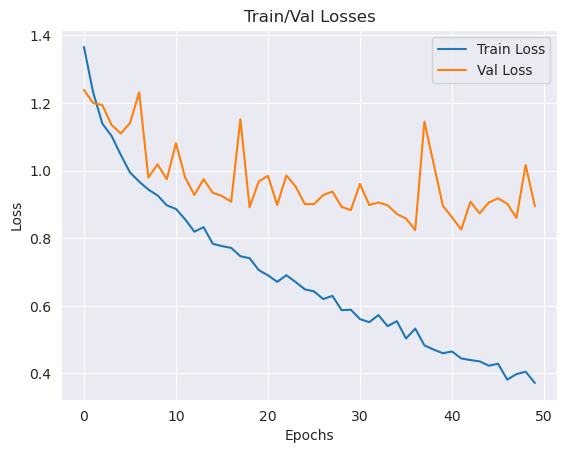

train_losses=[1.3657145182955521, 1.2310930159040738, 1.1389447910119923, 1.1024729680616703, 1.046627164456042, 0.9946155017486336, 0.967396089740471, 0.943739360869642, 0.9263205573069452, 0.897256910872061, 0.8863789736513307, 0.8555998109405536, 0.8192035113783611, 0.83251738491377, 0.7833684066528352, 0.7765113618536041, 0.7711809843351847, 0.7466133097475639, 0.7407733039632618, 0.7055627682684145, 0.6901532457096764, 0.6708384823756457, 0.6903434278963574, 0.6703977680505033, 0.6487163413040393, 0.642608129715009, 0.6197953872507114, 0.6293869417222986, 0.58710161580533, 0.5883206742902359, 0.5605678986713539, 0.5515960041513591, 0.5724397025522298, 0.5397085730155357, 0.5546743205808512, 0.5033868807134594, 0.5324144146642992, 0.4829488340454056, 0.4706297179057234, 0.45970389410533313, 0.4648565221444519, 0.4443140920420535, 0.439473549175234, 0.4356442299851512, 0.42283720272395375, 0.4286036696240555, 0.3817096103631796, 0.39802017906649584, 0.4049189164256566, 0.37187554478

100%|██████████| 126/126 [00:05<00:00, 25.19it/s]

Epoch [1 out of 50], Train --> loss: 1.6809 & accuracy: 33.24%, Validation --> loss: 1.7453 & accuracy: 23.28%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 31.17it/s]

Epoch [2 out of 50], Train --> loss: 1.3129 & accuracy: 42.38%, Validation --> loss: 1.5433 & accuracy: 31.84%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 29.65it/s]

Epoch [3 out of 50], Train --> loss: 1.2781 & accuracy: 44.32%, Validation --> loss: 1.2844 & accuracy: 38.71%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 28.37it/s]

Epoch [4 out of 50], Train --> loss: 1.2193 & accuracy: 49.22%, Validation --> loss: 1.2511 & accuracy: 42.29%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:05<00:00, 24.86it/s]

Epoch [5 out of 50], Train --> loss: 1.1324 & accuracy: 52.78%, Validation --> loss: 1.0922 & accuracy: 57.31%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:05<00:00, 24.51it/s]

Epoch [6 out of 50], Train --> loss: 1.1144 & accuracy: 52.57%, Validation --> loss: 1.3295 & accuracy: 38.71%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 27.61it/s]

Epoch [7 out of 50], Train --> loss: 1.0789 & accuracy: 56.06%, Validation --> loss: 1.4172 & accuracy: 38.91%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:05<00:00, 21.70it/s]

Epoch [8 out of 50], Train --> loss: 1.0639 & accuracy: 55.85%, Validation --> loss: 1.1200 & accuracy: 50.85%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.61it/s]

Epoch [9 out of 50], Train --> loss: 1.0403 & accuracy: 56.81%, Validation --> loss: 1.0756 & accuracy: 51.44%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.10it/s]

Epoch [10 out of 50], Train --> loss: 1.0232 & accuracy: 57.92%, Validation --> loss: 1.0496 & accuracy: 57.41%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.44it/s]

Epoch [11 out of 50], Train --> loss: 1.0047 & accuracy: 60.10%, Validation --> loss: 1.8188 & accuracy: 31.04%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 41.32it/s]

Epoch [12 out of 50], Train --> loss: 1.0000 & accuracy: 59.53%, Validation --> loss: 1.0081 & accuracy: 61.00%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.22it/s]

Epoch [13 out of 50], Train --> loss: 0.9870 & accuracy: 60.84%, Validation --> loss: 0.9910 & accuracy: 59.60%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.63it/s]

Epoch [14 out of 50], Train --> loss: 0.9625 & accuracy: 61.83%, Validation --> loss: 1.1851 & accuracy: 46.87%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 40.84it/s]

Epoch [15 out of 50], Train --> loss: 0.9669 & accuracy: 61.59%, Validation --> loss: 1.1108 & accuracy: 57.71%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.25it/s]

Epoch [16 out of 50], Train --> loss: 0.9449 & accuracy: 61.65%, Validation --> loss: 1.0051 & accuracy: 63.08%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.13it/s]

Epoch [17 out of 50], Train --> loss: 0.9456 & accuracy: 62.90%, Validation --> loss: 0.9741 & accuracy: 59.30%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.05it/s]

Epoch [18 out of 50], Train --> loss: 0.9322 & accuracy: 63.47%, Validation --> loss: 1.0765 & accuracy: 56.82%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 39.43it/s]

Epoch [19 out of 50], Train --> loss: 0.9245 & accuracy: 63.59%, Validation --> loss: 1.1058 & accuracy: 51.84%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.00it/s]

Epoch [20 out of 50], Train --> loss: 0.9156 & accuracy: 63.98%, Validation --> loss: 1.0128 & accuracy: 57.31%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:04<00:00, 31.01it/s]

Epoch [21 out of 50], Train --> loss: 0.9025 & accuracy: 64.84%, Validation --> loss: 1.0620 & accuracy: 59.00%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 39.50it/s]

Epoch [22 out of 50], Train --> loss: 0.8987 & accuracy: 64.61%, Validation --> loss: 1.1011 & accuracy: 56.52%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.81it/s]

Epoch [23 out of 50], Train --> loss: 0.9035 & accuracy: 64.87%, Validation --> loss: 1.1781 & accuracy: 54.13%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 35.91it/s]

Epoch [24 out of 50], Train --> loss: 0.8827 & accuracy: 65.50%, Validation --> loss: 1.1617 & accuracy: 54.03%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 41.17it/s]

Epoch [25 out of 50], Train --> loss: 0.8829 & accuracy: 65.62%, Validation --> loss: 1.2555 & accuracy: 44.88%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.33it/s]

Epoch [26 out of 50], Train --> loss: 0.8718 & accuracy: 66.19%, Validation --> loss: 1.4156 & accuracy: 39.90%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.88it/s]

Epoch [27 out of 50], Train --> loss: 0.8769 & accuracy: 66.91%, Validation --> loss: 1.0341 & accuracy: 56.62%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 43.38it/s]

Epoch [28 out of 50], Train --> loss: 0.8584 & accuracy: 66.28%, Validation --> loss: 1.2175 & accuracy: 48.86%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.70it/s]

Epoch [29 out of 50], Train --> loss: 0.8555 & accuracy: 67.26%, Validation --> loss: 2.1253 & accuracy: 31.04%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.42it/s]

Epoch [30 out of 50], Train --> loss: 0.8546 & accuracy: 66.64%, Validation --> loss: 1.3199 & accuracy: 47.56%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.55it/s]

Epoch [31 out of 50], Train --> loss: 0.8469 & accuracy: 67.35%, Validation --> loss: 0.9128 & accuracy: 64.68%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.51it/s]

Epoch [32 out of 50], Train --> loss: 0.8284 & accuracy: 67.38%, Validation --> loss: 0.9491 & accuracy: 61.69%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.62it/s]

Epoch [33 out of 50], Train --> loss: 0.8275 & accuracy: 68.19%, Validation --> loss: 0.9948 & accuracy: 60.10%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.97it/s]

Epoch [34 out of 50], Train --> loss: 0.8266 & accuracy: 67.44%, Validation --> loss: 1.0818 & accuracy: 56.02%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.76it/s]

Epoch [35 out of 50], Train --> loss: 0.8071 & accuracy: 69.62%, Validation --> loss: 1.0432 & accuracy: 60.80%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.48it/s]

Epoch [36 out of 50], Train --> loss: 0.8143 & accuracy: 67.86%, Validation --> loss: 0.9653 & accuracy: 61.00%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.44it/s]

Epoch [37 out of 50], Train --> loss: 0.8036 & accuracy: 69.71%, Validation --> loss: 1.0009 & accuracy: 56.92%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.90it/s]

Epoch [38 out of 50], Train --> loss: 0.7837 & accuracy: 70.31%, Validation --> loss: 1.4775 & accuracy: 44.48%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.04it/s]

Epoch [39 out of 50], Train --> loss: 0.7989 & accuracy: 69.41%, Validation --> loss: 1.1262 & accuracy: 50.95%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.60it/s]


Epoch [40 out of 50], Train --> loss: 0.7832 & accuracy: 69.12%, Validation --> loss: 1.2493 & accuracy: 49.05%
Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.91it/s]

Epoch [41 out of 50], Train --> loss: 0.7788 & accuracy: 70.28%, Validation --> loss: 1.0233 & accuracy: 57.41%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.15it/s]

Epoch [42 out of 50], Train --> loss: 0.7865 & accuracy: 69.56%, Validation --> loss: 1.7526 & accuracy: 34.53%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.66it/s]

Epoch [43 out of 50], Train --> loss: 0.7761 & accuracy: 70.25%, Validation --> loss: 0.9543 & accuracy: 66.07%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.40it/s]

Epoch [44 out of 50], Train --> loss: 0.7822 & accuracy: 69.98%, Validation --> loss: 1.0604 & accuracy: 55.22%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.65it/s]

Epoch [45 out of 50], Train --> loss: 0.7711 & accuracy: 70.19%, Validation --> loss: 0.9671 & accuracy: 59.20%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.57it/s]

Epoch [46 out of 50], Train --> loss: 0.7763 & accuracy: 71.00%, Validation --> loss: 0.9925 & accuracy: 63.38%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.16it/s]

Epoch [47 out of 50], Train --> loss: 0.7556 & accuracy: 72.19%, Validation --> loss: 0.9924 & accuracy: 58.31%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.91it/s]

Epoch [48 out of 50], Train --> loss: 0.7636 & accuracy: 71.27%, Validation --> loss: 1.1186 & accuracy: 54.83%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.80it/s]

Epoch [49 out of 50], Train --> loss: 0.7557 & accuracy: 70.85%, Validation --> loss: 0.9210 & accuracy: 64.58%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.44it/s]

Epoch [50 out of 50], Train --> loss: 0.7440 & accuracy: 72.31%, Validation --> loss: 1.0634 & accuracy: 56.32%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 49.31it/s]


Test Accuracy: 56.61%


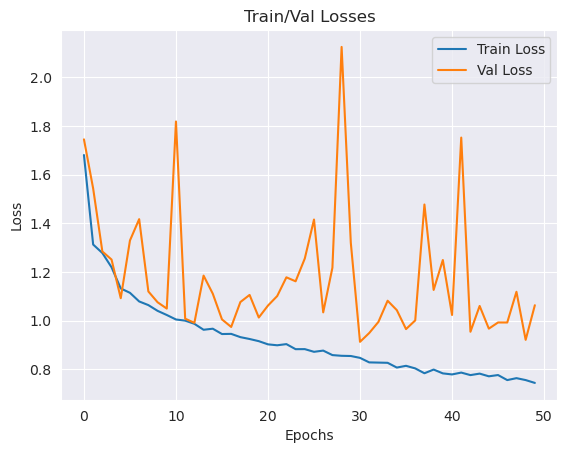

train_losses=[1.6809088516633663, 1.312886395431646, 1.2780885712059131, 1.2193498793535984, 1.132351247678224, 1.1143651877781087, 1.0789141395353758, 1.0638965053177107, 1.0403128318968706, 1.0232163617178478, 1.004727682165428, 1.0000202051210518, 0.9870240285032404, 0.9624753383150533, 0.9668695774453921, 0.9449366269931019, 0.9456139975060711, 0.9321725194949239, 0.9245412056656612, 0.9156302668172022, 0.9025216039296835, 0.8987117511773736, 0.9034852905461214, 0.8827102622973036, 0.8828821466048749, 0.8718368066808204, 0.8768552302033918, 0.8583745199626841, 0.8554758315723665, 0.8546175086839671, 0.8469407242280487, 0.8283804023464995, 0.8275376839256514, 0.8266422782706759, 0.8071042028631401, 0.8142857403630004, 0.803642803878659, 0.7837023696637666, 0.7988935494195305, 0.7831746339086701, 0.7788458699471627, 0.7864591987150097, 0.7761061038279591, 0.782212555586296, 0.7711292029422906, 0.7763169416024178, 0.7556172389901623, 0.7635644054782703, 0.7556739940990411, 0.743962057

100%|██████████| 126/126 [00:02<00:00, 54.35it/s]

Epoch [1 out of 50], Train --> loss: 1.7252 & accuracy: 32.62%, Validation --> loss: 1.9891 & accuracy: 27.66%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.39it/s]

Epoch [2 out of 50], Train --> loss: 1.3342 & accuracy: 42.32%, Validation --> loss: 1.3174 & accuracy: 43.58%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.87it/s]

Epoch [3 out of 50], Train --> loss: 1.2292 & accuracy: 48.27%, Validation --> loss: 1.4292 & accuracy: 37.01%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.99it/s]

Epoch [4 out of 50], Train --> loss: 1.2002 & accuracy: 50.84%, Validation --> loss: 1.5658 & accuracy: 42.79%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.03it/s]

Epoch [5 out of 50], Train --> loss: 1.1335 & accuracy: 52.54%, Validation --> loss: 1.3524 & accuracy: 41.79%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.24it/s]

Epoch [6 out of 50], Train --> loss: 1.0982 & accuracy: 54.06%, Validation --> loss: 1.5003 & accuracy: 35.52%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.26it/s]

Epoch [7 out of 50], Train --> loss: 1.0600 & accuracy: 56.93%, Validation --> loss: 1.0423 & accuracy: 60.10%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.50it/s]

Epoch [8 out of 50], Train --> loss: 1.0385 & accuracy: 56.39%, Validation --> loss: 1.7534 & accuracy: 40.50%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.90it/s]

Epoch [9 out of 50], Train --> loss: 1.0004 & accuracy: 59.89%, Validation --> loss: 1.0531 & accuracy: 57.01%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.18it/s]

Epoch [10 out of 50], Train --> loss: 0.9767 & accuracy: 61.38%, Validation --> loss: 1.2208 & accuracy: 47.16%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.31it/s]

Epoch [11 out of 50], Train --> loss: 0.9490 & accuracy: 61.83%, Validation --> loss: 1.6317 & accuracy: 42.69%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.69it/s]

Epoch [12 out of 50], Train --> loss: 0.9399 & accuracy: 63.23%, Validation --> loss: 1.1682 & accuracy: 50.85%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.73it/s]

Epoch [13 out of 50], Train --> loss: 0.9069 & accuracy: 63.56%, Validation --> loss: 1.2048 & accuracy: 48.96%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.88it/s]

Epoch [14 out of 50], Train --> loss: 0.9035 & accuracy: 64.99%, Validation --> loss: 1.1386 & accuracy: 54.63%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.08it/s]

Epoch [15 out of 50], Train --> loss: 0.8867 & accuracy: 65.62%, Validation --> loss: 0.9966 & accuracy: 63.68%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.86it/s]

Epoch [16 out of 50], Train --> loss: 0.8626 & accuracy: 67.23%, Validation --> loss: 0.9994 & accuracy: 58.61%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.94it/s]

Epoch [17 out of 50], Train --> loss: 0.8589 & accuracy: 66.97%, Validation --> loss: 1.0171 & accuracy: 60.10%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.65it/s]

Epoch [18 out of 50], Train --> loss: 0.8221 & accuracy: 68.91%, Validation --> loss: 1.0766 & accuracy: 53.23%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 55.20it/s]

Epoch [19 out of 50], Train --> loss: 0.8066 & accuracy: 68.28%, Validation --> loss: 0.9295 & accuracy: 60.90%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.91it/s]

Epoch [20 out of 50], Train --> loss: 0.8010 & accuracy: 68.73%, Validation --> loss: 1.0834 & accuracy: 54.53%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.02it/s]

Epoch [21 out of 50], Train --> loss: 0.7771 & accuracy: 70.16%, Validation --> loss: 1.0902 & accuracy: 58.31%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.66it/s]

Epoch [22 out of 50], Train --> loss: 0.7784 & accuracy: 69.71%, Validation --> loss: 1.0600 & accuracy: 56.42%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.88it/s]

Epoch [23 out of 50], Train --> loss: 0.7484 & accuracy: 71.59%, Validation --> loss: 0.9672 & accuracy: 58.61%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.52it/s]

Epoch [24 out of 50], Train --> loss: 0.7458 & accuracy: 71.89%, Validation --> loss: 0.9877 & accuracy: 60.30%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.86it/s]

Epoch [25 out of 50], Train --> loss: 0.7312 & accuracy: 72.22%, Validation --> loss: 1.1484 & accuracy: 55.42%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.99it/s]

Epoch [26 out of 50], Train --> loss: 0.7085 & accuracy: 72.82%, Validation --> loss: 0.9585 & accuracy: 62.79%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.26it/s]

Epoch [27 out of 50], Train --> loss: 0.6983 & accuracy: 73.21%, Validation --> loss: 0.9122 & accuracy: 64.48%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.10it/s]

Epoch [28 out of 50], Train --> loss: 0.6756 & accuracy: 74.73%, Validation --> loss: 1.0214 & accuracy: 58.51%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.59it/s]

Epoch [29 out of 50], Train --> loss: 0.6722 & accuracy: 74.64%, Validation --> loss: 1.1418 & accuracy: 57.81%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.32it/s]

Epoch [30 out of 50], Train --> loss: 0.6508 & accuracy: 75.93%, Validation --> loss: 0.9871 & accuracy: 58.51%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.16it/s]

Epoch [31 out of 50], Train --> loss: 0.6245 & accuracy: 76.64%, Validation --> loss: 0.8174 & accuracy: 69.25%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.74it/s]

Epoch [32 out of 50], Train --> loss: 0.6315 & accuracy: 76.97%, Validation --> loss: 0.7856 & accuracy: 70.25%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.66it/s]

Epoch [33 out of 50], Train --> loss: 0.6029 & accuracy: 77.60%, Validation --> loss: 0.8223 & accuracy: 67.86%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.75it/s]

Epoch [34 out of 50], Train --> loss: 0.5946 & accuracy: 78.14%, Validation --> loss: 1.0752 & accuracy: 60.60%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.52it/s]

Epoch [35 out of 50], Train --> loss: 0.5904 & accuracy: 78.05%, Validation --> loss: 0.9527 & accuracy: 63.98%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.68it/s]

Epoch [36 out of 50], Train --> loss: 0.5789 & accuracy: 78.88%, Validation --> loss: 0.7891 & accuracy: 71.34%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.02it/s]

Epoch [37 out of 50], Train --> loss: 0.5524 & accuracy: 80.11%, Validation --> loss: 0.8678 & accuracy: 65.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.25it/s]

Epoch [38 out of 50], Train --> loss: 0.5374 & accuracy: 79.63%, Validation --> loss: 0.8183 & accuracy: 68.16%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 43.76it/s]

Epoch [39 out of 50], Train --> loss: 0.5303 & accuracy: 79.84%, Validation --> loss: 0.8479 & accuracy: 67.16%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 41.13it/s]

Epoch [40 out of 50], Train --> loss: 0.5239 & accuracy: 80.85%, Validation --> loss: 0.9908 & accuracy: 63.58%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 42.80it/s]

Epoch [41 out of 50], Train --> loss: 0.5158 & accuracy: 80.91%, Validation --> loss: 0.9779 & accuracy: 63.68%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 34.30it/s]

Epoch [42 out of 50], Train --> loss: 0.4983 & accuracy: 81.93%, Validation --> loss: 0.7493 & accuracy: 74.43%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.89it/s]

Epoch [43 out of 50], Train --> loss: 0.5003 & accuracy: 81.42%, Validation --> loss: 0.7663 & accuracy: 71.74%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 41.12it/s]


Epoch [44 out of 50], Train --> loss: 0.4849 & accuracy: 82.11%, Validation --> loss: 0.8020 & accuracy: 71.24%
Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.38it/s]

Epoch [45 out of 50], Train --> loss: 0.4800 & accuracy: 82.59%, Validation --> loss: 0.7770 & accuracy: 72.64%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.43it/s]

Epoch [46 out of 50], Train --> loss: 0.4732 & accuracy: 82.71%, Validation --> loss: 0.8375 & accuracy: 68.76%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.73it/s]

Epoch [47 out of 50], Train --> loss: 0.4551 & accuracy: 83.36%, Validation --> loss: 0.7228 & accuracy: 72.84%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.69it/s]

Epoch [48 out of 50], Train --> loss: 0.4597 & accuracy: 83.54%, Validation --> loss: 0.7586 & accuracy: 70.95%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.57it/s]

Epoch [49 out of 50], Train --> loss: 0.4435 & accuracy: 84.14%, Validation --> loss: 0.6819 & accuracy: 74.23%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.94it/s]

Epoch [50 out of 50], Train --> loss: 0.4308 & accuracy: 83.93%, Validation --> loss: 0.6866 & accuracy: 74.43%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 49.01it/s]


Test Accuracy: 78.19%


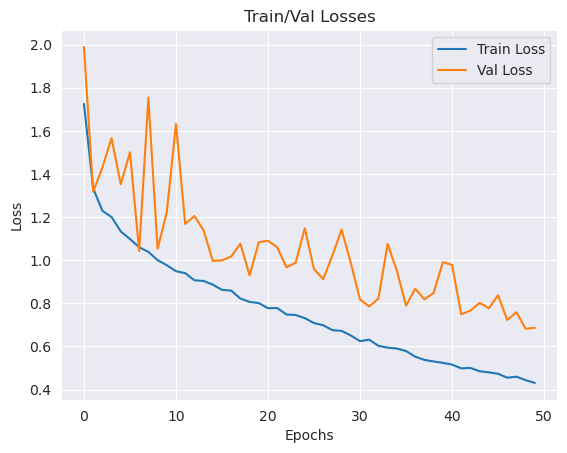

train_losses=[1.7251754455748491, 1.3342375762422785, 1.2291902830037411, 1.2002128647164685, 1.1335362452026767, 1.0981891812458813, 1.0599570713208228, 1.038453134119084, 1.0003793270178227, 0.9767285740460872, 0.9490458906265887, 0.9398613575321393, 0.9068924769723614, 0.9035401543455648, 0.8867491913297011, 0.8625608851204055, 0.8589176794865251, 0.8220512818962976, 0.8066352326289566, 0.8010450901023528, 0.777144808437773, 0.7783657953249811, 0.7483673315486362, 0.7458359906738868, 0.7312478837434887, 0.7084819183002509, 0.6982548245560013, 0.6756292688604756, 0.6722103520552127, 0.6508310226310124, 0.6245125134904516, 0.6314878736162527, 0.6029353951568536, 0.5945967814945093, 0.5904220695427324, 0.5788680892393242, 0.5524073216468451, 0.5374092479416465, 0.5302765247254212, 0.5239304540887795, 0.5157674329982168, 0.49834440524305323, 0.5002811630489861, 0.48488156234307617, 0.48000585454069344, 0.4732173717000604, 0.4550841534799209, 0.45971126598361567, 0.44354927451805454, 0.4

100%|██████████| 126/126 [00:02<00:00, 47.49it/s]

Epoch [1 out of 50], Train --> loss: 1.3761 & accuracy: 28.43%, Validation --> loss: 1.3619 & accuracy: 31.94%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.50it/s]

Epoch [2 out of 50], Train --> loss: 1.3539 & accuracy: 36.02%, Validation --> loss: 1.3458 & accuracy: 40.80%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.07it/s]

Epoch [3 out of 50], Train --> loss: 1.3340 & accuracy: 39.25%, Validation --> loss: 1.3419 & accuracy: 36.82%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.42it/s]

Epoch [4 out of 50], Train --> loss: 1.3170 & accuracy: 42.08%, Validation --> loss: 1.3179 & accuracy: 38.01%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.88it/s]

Epoch [5 out of 50], Train --> loss: 1.3025 & accuracy: 42.62%, Validation --> loss: 1.3007 & accuracy: 42.09%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.09it/s]

Epoch [6 out of 50], Train --> loss: 1.2888 & accuracy: 43.94%, Validation --> loss: 1.2908 & accuracy: 38.31%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.87it/s]

Epoch [7 out of 50], Train --> loss: 1.2756 & accuracy: 44.38%, Validation --> loss: 1.2762 & accuracy: 42.49%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.05it/s]

Epoch [8 out of 50], Train --> loss: 1.2638 & accuracy: 45.70%, Validation --> loss: 1.2667 & accuracy: 46.37%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.21it/s]

Epoch [9 out of 50], Train --> loss: 1.2504 & accuracy: 47.70%, Validation --> loss: 1.2571 & accuracy: 41.09%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.19it/s]

Epoch [10 out of 50], Train --> loss: 1.2388 & accuracy: 47.34%, Validation --> loss: 1.2474 & accuracy: 48.86%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.93it/s]

Epoch [11 out of 50], Train --> loss: 1.2286 & accuracy: 48.48%, Validation --> loss: 1.2399 & accuracy: 46.77%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.16it/s]

Epoch [12 out of 50], Train --> loss: 1.2188 & accuracy: 50.03%, Validation --> loss: 1.2325 & accuracy: 49.55%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.28it/s]

Epoch [13 out of 50], Train --> loss: 1.2095 & accuracy: 50.69%, Validation --> loss: 1.2212 & accuracy: 45.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.71it/s]

Epoch [14 out of 50], Train --> loss: 1.1988 & accuracy: 51.55%, Validation --> loss: 1.2157 & accuracy: 55.22%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.84it/s]

Epoch [15 out of 50], Train --> loss: 1.1907 & accuracy: 52.48%, Validation --> loss: 1.2099 & accuracy: 47.46%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.60it/s]

Epoch [16 out of 50], Train --> loss: 1.1800 & accuracy: 52.93%, Validation --> loss: 1.2044 & accuracy: 49.15%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.76it/s]

Epoch [17 out of 50], Train --> loss: 1.1728 & accuracy: 53.05%, Validation --> loss: 1.1925 & accuracy: 51.14%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 38.33it/s]

Epoch [18 out of 50], Train --> loss: 1.1637 & accuracy: 54.48%, Validation --> loss: 1.1859 & accuracy: 55.82%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.49it/s]

Epoch [19 out of 50], Train --> loss: 1.1551 & accuracy: 55.26%, Validation --> loss: 1.1796 & accuracy: 52.64%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.42it/s]

Epoch [20 out of 50], Train --> loss: 1.1457 & accuracy: 56.30%, Validation --> loss: 1.1732 & accuracy: 50.35%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 43.72it/s]

Epoch [21 out of 50], Train --> loss: 1.1388 & accuracy: 56.00%, Validation --> loss: 1.1805 & accuracy: 51.14%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.20it/s]

Epoch [22 out of 50], Train --> loss: 1.1328 & accuracy: 56.90%, Validation --> loss: 1.1635 & accuracy: 50.25%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.81it/s]

Epoch [23 out of 50], Train --> loss: 1.1248 & accuracy: 57.41%, Validation --> loss: 1.1526 & accuracy: 57.31%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.73it/s]

Epoch [24 out of 50], Train --> loss: 1.1154 & accuracy: 57.77%, Validation --> loss: 1.1605 & accuracy: 49.95%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.74it/s]

Epoch [25 out of 50], Train --> loss: 1.1093 & accuracy: 58.09%, Validation --> loss: 1.1429 & accuracy: 56.92%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.26it/s]

Epoch [26 out of 50], Train --> loss: 1.1029 & accuracy: 59.02%, Validation --> loss: 1.1378 & accuracy: 58.11%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.30it/s]

Epoch [27 out of 50], Train --> loss: 1.0953 & accuracy: 59.77%, Validation --> loss: 1.1391 & accuracy: 56.12%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.86it/s]

Epoch [28 out of 50], Train --> loss: 1.0887 & accuracy: 59.80%, Validation --> loss: 1.1300 & accuracy: 54.23%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.52it/s]

Epoch [29 out of 50], Train --> loss: 1.0820 & accuracy: 61.11%, Validation --> loss: 1.1297 & accuracy: 56.92%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.20it/s]

Epoch [30 out of 50], Train --> loss: 1.0746 & accuracy: 60.81%, Validation --> loss: 1.1194 & accuracy: 54.53%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 42.24it/s]

Epoch [31 out of 50], Train --> loss: 1.0683 & accuracy: 60.93%, Validation --> loss: 1.1179 & accuracy: 56.02%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.24it/s]

Epoch [32 out of 50], Train --> loss: 1.0642 & accuracy: 61.17%, Validation --> loss: 1.1067 & accuracy: 57.31%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 41.29it/s]

Epoch [33 out of 50], Train --> loss: 1.0571 & accuracy: 61.77%, Validation --> loss: 1.1049 & accuracy: 60.40%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 36.35it/s]

Epoch [34 out of 50], Train --> loss: 1.0502 & accuracy: 62.13%, Validation --> loss: 1.1109 & accuracy: 57.21%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.23it/s]

Epoch [35 out of 50], Train --> loss: 1.0450 & accuracy: 62.34%, Validation --> loss: 1.0981 & accuracy: 56.12%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.81it/s]

Epoch [36 out of 50], Train --> loss: 1.0379 & accuracy: 62.81%, Validation --> loss: 1.0895 & accuracy: 60.40%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.93it/s]

Epoch [37 out of 50], Train --> loss: 1.0339 & accuracy: 62.69%, Validation --> loss: 1.0839 & accuracy: 59.70%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.30it/s]

Epoch [38 out of 50], Train --> loss: 1.0277 & accuracy: 63.62%, Validation --> loss: 1.0811 & accuracy: 59.40%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.60it/s]

Epoch [39 out of 50], Train --> loss: 1.0225 & accuracy: 63.83%, Validation --> loss: 1.0820 & accuracy: 59.20%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.83it/s]

Epoch [40 out of 50], Train --> loss: 1.0171 & accuracy: 63.71%, Validation --> loss: 1.0716 & accuracy: 60.30%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 55.11it/s]

Epoch [41 out of 50], Train --> loss: 1.0096 & accuracy: 63.62%, Validation --> loss: 1.0821 & accuracy: 58.31%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.76it/s]

Epoch [42 out of 50], Train --> loss: 1.0076 & accuracy: 63.95%, Validation --> loss: 1.0692 & accuracy: 59.00%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.73it/s]

Epoch [43 out of 50], Train --> loss: 1.0010 & accuracy: 64.16%, Validation --> loss: 1.0600 & accuracy: 59.80%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 43.47it/s]

Epoch [44 out of 50], Train --> loss: 0.9953 & accuracy: 64.87%, Validation --> loss: 1.0562 & accuracy: 60.40%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.26it/s]

Epoch [45 out of 50], Train --> loss: 0.9893 & accuracy: 65.41%, Validation --> loss: 1.0536 & accuracy: 59.70%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.25it/s]

Epoch [46 out of 50], Train --> loss: 0.9875 & accuracy: 64.61%, Validation --> loss: 1.0519 & accuracy: 59.40%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.02it/s]

Epoch [47 out of 50], Train --> loss: 0.9834 & accuracy: 65.02%, Validation --> loss: 1.0515 & accuracy: 58.01%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 39.17it/s]

Epoch [48 out of 50], Train --> loss: 0.9768 & accuracy: 66.22%, Validation --> loss: 1.0422 & accuracy: 61.49%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.49it/s]

Epoch [49 out of 50], Train --> loss: 0.9741 & accuracy: 65.95%, Validation --> loss: 1.0383 & accuracy: 61.29%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.27it/s]

Epoch [50 out of 50], Train --> loss: 0.9690 & accuracy: 65.80%, Validation --> loss: 1.0408 & accuracy: 59.20%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 48.81it/s]


Test Accuracy: 64.27%


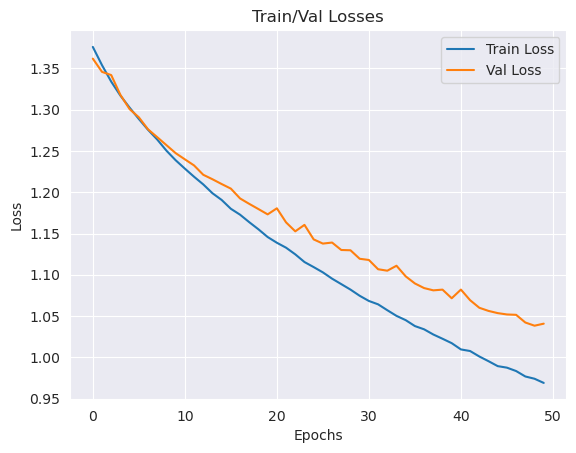

train_losses=[1.3760672750791672, 1.3539134431852646, 1.333991521013665, 1.3170183521466494, 1.302478738218048, 1.2887537217652314, 1.2756338913287069, 1.2638413102359363, 1.2503719065240573, 1.2387827606360498, 1.2286300828462569, 1.218790700014565, 1.2095117603110812, 1.1988036025111033, 1.1906668728746492, 1.1799551653975804, 1.172805432345816, 1.1637144670566113, 1.1550772888563698, 1.1457321605420625, 1.138803225143997, 1.1328132667518742, 1.1247596422072528, 1.1154457720481126, 1.1093067896679079, 1.102921233114593, 1.0952875008161995, 1.0886725029399116, 1.0820415665824543, 1.0745595134527985, 1.0682747032591153, 1.0642025692650696, 1.0570816766106144, 1.0502137686870547, 1.0450290481344329, 1.037865168154951, 1.0339292058796758, 1.0276501712195913, 1.0224984003706592, 1.017149300876836, 1.0095705638921915, 1.0076209581268147, 1.0010143694843483, 0.995304595172263, 0.9893210231546571, 0.9874787140006381, 0.9833759665489197, 0.9767869663978249, 0.9740525620649424, 0.9689819504082

In [25]:
import torch
import matplotlib.pyplot as plt
from custom_adam import Adam

best = pd.DataFrame(columns=['opt', 'best_acc', 'lr', 'weight_decay'])
num_epochs = 50
params = [(Adam, 0.0001, 0.001), (Adam, 0.0001,0.01), (optim.RMSprop,0.0001,0.010), (optim.RMSprop,0.0001,0.001), (optim.SGD, 0.0001, 0.01)]

for param in params:    
    model = AircraftNet(_input=IMAGE_HEIGHT*IMAGE_WIDTH*3,
                        hidden_size=256,
                        _output=4).to(device)

    print(f"Params lr={param[1]}, w={param[2]}, opt={param[0]}")
    train_losses, val_losses, best = train_model(model, param[0], train_data_loader, val_data_loader, num_epochs, param[1], weight_decay=param[2], df=best)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(test_data_loader)):
            images = images.view(-1, IMAGE_HEIGHT*IMAGE_WIDTH*3).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f"Test Accuracy: {100 * accuracy:.2f}%")

    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Train/Val Losses')
    plt.legend()
    plt.show()

    print(f"{train_losses=}\n{val_losses}")

In [27]:
best

,opt,best_acc,lr,weight_decay,best_accuracy
0,Adam,NaN,0.01,0.001,0.701493
0,Adam,NaN,0.01,0.010,0.702488
0,RMSprop,NaN,0.01,0.010,0.660697
0,RMSprop,NaN,0.01,0.001,0.744279
0,SGD,NaN,0.01,0.010,0.614925


Лучшие результаты у RMSprop оптимизатора:
1. lr = 0.01
2. weight_decay = 0.001

Test accuracy = 78.2%, [Train\val loss график](best_without_batch_normalization.png)

Посмотрим даёт ли нейронная сеть с batch-normalization лучшие резулутаты. 

# BatchNormalization

In [17]:
res_with_batch_norm = pd.DataFrame(columns=['opt', 'best_acc', 'lr', 'weight_decay'])

Training with learning rate: 0.01


100%|██████████| 126/126 [00:02<00:00, 44.64it/s]

Epoch [1 out of 15], Train --> loss: 1.1117 & accuracy: 52.60%, Validation --> loss: 1.0972 & accuracy: 49.45%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.83it/s]

Epoch [2 out of 15], Train --> loss: 0.8815 & accuracy: 65.83%, Validation --> loss: 0.9165 & accuracy: 67.66%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.29it/s]

Epoch [3 out of 15], Train --> loss: 0.7707 & accuracy: 70.97%, Validation --> loss: 1.8312 & accuracy: 52.94%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.40it/s]

Epoch [4 out of 15], Train --> loss: 0.6931 & accuracy: 75.39%, Validation --> loss: 37.1738 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.45it/s]

Epoch [5 out of 15], Train --> loss: 0.7506 & accuracy: 72.43%, Validation --> loss: 0.9559 & accuracy: 61.09%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.07it/s]

Epoch [6 out of 15], Train --> loss: 0.6143 & accuracy: 78.41%, Validation --> loss: 1.3475 & accuracy: 53.43%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.38it/s]

Epoch [7 out of 15], Train --> loss: 0.5754 & accuracy: 79.96%, Validation --> loss: 1.0617 & accuracy: 57.41%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:03<00:00, 38.85it/s]

Epoch [8 out of 15], Train --> loss: 0.5250 & accuracy: 81.21%, Validation --> loss: 1.6599 & accuracy: 51.24%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.13it/s]

Epoch [9 out of 15], Train --> loss: 0.4754 & accuracy: 83.81%, Validation --> loss: 0.8966 & accuracy: 66.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.20it/s]

Epoch [10 out of 15], Train --> loss: 0.4699 & accuracy: 83.51%, Validation --> loss: 1.4582 & accuracy: 57.41%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.89it/s]

Epoch [11 out of 15], Train --> loss: 0.4272 & accuracy: 85.27%, Validation --> loss: 2.7998 & accuracy: 58.01%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.60it/s]

Epoch [12 out of 15], Train --> loss: 0.4070 & accuracy: 85.96%, Validation --> loss: 1.9846 & accuracy: 41.29%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.67it/s]

Epoch [13 out of 15], Train --> loss: 0.3878 & accuracy: 86.56%, Validation --> loss: 5.3297 & accuracy: 30.05%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.90it/s]

Epoch [14 out of 15], Train --> loss: 0.4060 & accuracy: 85.36%, Validation --> loss: 1.0547 & accuracy: 68.06%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.56it/s]

Epoch [15 out of 15], Train --> loss: 0.3842 & accuracy: 86.05%, Validation --> loss: 1.0329 & accuracy: 66.77%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 41.78it/s]


Test Accuracy with learning rate 0.01: 70.30%


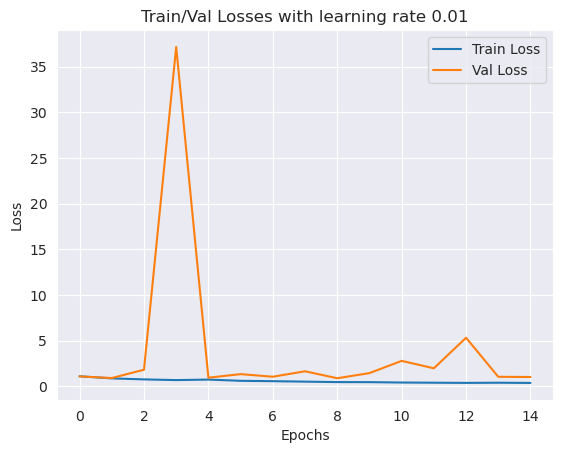

train_losses=[1.1116779833534167, 0.8815002217355378, 0.7707484863822955, 0.693063164098735, 0.750633527633683, 0.6142919808626175, 0.5753660553395037, 0.5249874543460855, 0.4754199464772083, 0.4699037957020762, 0.42718930951450773, 0.4070359884376742, 0.3878198982458695, 0.40595821442353697, 0.38415251524678845]
[1.097163213387368, 0.9165279687870116, 1.831244665951956, 37.17382086647881, 0.955930672467701, 1.3474718305090116, 1.0616504955622885, 1.6599095172825313, 0.8965552077879981, 1.4582020572963215, 2.799844868540291, 1.9846238872361561, 5.329738896044474, 1.0547190066722651, 1.0328895461464684]
Training with learning rate: 0.01


100%|██████████| 126/126 [00:02<00:00, 49.54it/s]

Epoch [1 out of 15], Train --> loss: 1.0604 & accuracy: 56.18%, Validation --> loss: 1.1875 & accuracy: 55.22%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.55it/s]

Epoch [2 out of 15], Train --> loss: 0.8358 & accuracy: 68.04%, Validation --> loss: 1.7227 & accuracy: 47.56%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.41it/s]

Epoch [3 out of 15], Train --> loss: 0.7371 & accuracy: 71.86%, Validation --> loss: 4.2422 & accuracy: 29.65%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.30it/s]

Epoch [4 out of 15], Train --> loss: 0.6621 & accuracy: 76.11%, Validation --> loss: 3.1017 & accuracy: 37.51%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.16it/s]

Epoch [5 out of 15], Train --> loss: 0.6124 & accuracy: 78.43%, Validation --> loss: 0.7902 & accuracy: 70.25%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.52it/s]

Epoch [6 out of 15], Train --> loss: 0.5793 & accuracy: 78.41%, Validation --> loss: 1.0068 & accuracy: 61.79%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.29it/s]

Epoch [7 out of 15], Train --> loss: 0.5347 & accuracy: 80.14%, Validation --> loss: 1.4914 & accuracy: 47.66%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.66it/s]

Epoch [8 out of 15], Train --> loss: 0.4943 & accuracy: 82.38%, Validation --> loss: 1.3788 & accuracy: 54.23%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.77it/s]

Epoch [9 out of 15], Train --> loss: 0.4938 & accuracy: 82.65%, Validation --> loss: 1.1032 & accuracy: 54.33%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.16it/s]

Epoch [10 out of 15], Train --> loss: 0.4207 & accuracy: 85.39%, Validation --> loss: 3.8429 & accuracy: 29.75%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.42it/s]

Epoch [11 out of 15], Train --> loss: 0.4245 & accuracy: 85.30%, Validation --> loss: 0.6900 & accuracy: 73.33%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.55it/s]

Epoch [12 out of 15], Train --> loss: 0.4011 & accuracy: 85.72%, Validation --> loss: 1.2083 & accuracy: 60.10%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.19it/s]

Epoch [13 out of 15], Train --> loss: 0.3978 & accuracy: 86.65%, Validation --> loss: 0.8293 & accuracy: 73.43%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.37it/s]

Epoch [14 out of 15], Train --> loss: 0.3687 & accuracy: 87.46%, Validation --> loss: 7.4586 & accuracy: 26.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.94it/s]

Epoch [15 out of 15], Train --> loss: 0.3658 & accuracy: 87.66%, Validation --> loss: 1.1391 & accuracy: 65.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 44.53it/s]


Test Accuracy with learning rate 0.01: 69.61%


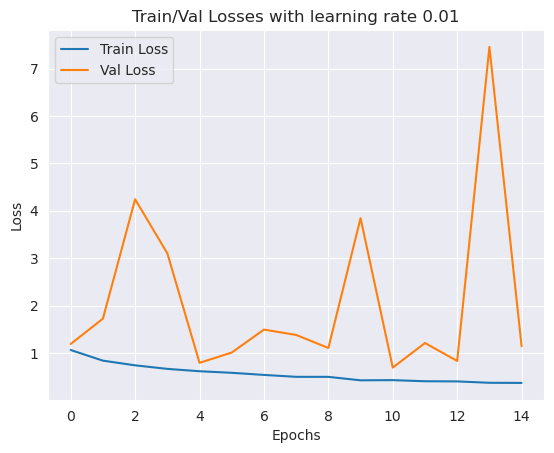

train_losses=[1.0604132568921565, 0.8357814254510374, 0.7370656487623092, 0.662083747954528, 0.6123887828611246, 0.5792798586634292, 0.5347492991811051, 0.4943148155912295, 0.49384428715435585, 0.4207480495222144, 0.42450957754204555, 0.401062423598937, 0.397821893484325, 0.36866293207415535, 0.365783307728022]
[1.187519448617148, 1.7227078808678522, 4.242151176172589, 3.101747736571327, 0.7901799475389814, 1.0068029725835437, 1.4914144216075775, 1.3787656101205992, 1.103168864571859, 3.8429421527045116, 0.6899789339374929, 1.2083355517141403, 0.8293417220314344, 7.458577089839512, 1.1391275331732773]
Training with learning rate: 0.01


100%|██████████| 126/126 [00:02<00:00, 50.15it/s]

Epoch [1 out of 15], Train --> loss: 1.0950 & accuracy: 54.57%, Validation --> loss: 2.2180 & accuracy: 36.72%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.78it/s]

Epoch [2 out of 15], Train --> loss: 0.8881 & accuracy: 65.50%, Validation --> loss: 1.7639 & accuracy: 40.50%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.38it/s]

Epoch [3 out of 15], Train --> loss: 0.7956 & accuracy: 70.52%, Validation --> loss: 1.3787 & accuracy: 48.16%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.41it/s]

Epoch [4 out of 15], Train --> loss: 0.7079 & accuracy: 74.49%, Validation --> loss: 1.3616 & accuracy: 40.50%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.04it/s]

Epoch [5 out of 15], Train --> loss: 0.6555 & accuracy: 76.25%, Validation --> loss: 1.5309 & accuracy: 47.46%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.79it/s]

Epoch [6 out of 15], Train --> loss: 0.6343 & accuracy: 77.33%, Validation --> loss: 1.2223 & accuracy: 56.72%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.33it/s]

Epoch [7 out of 15], Train --> loss: 0.5620 & accuracy: 80.91%, Validation --> loss: 1.4251 & accuracy: 50.35%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.66it/s]

Epoch [8 out of 15], Train --> loss: 0.5395 & accuracy: 81.30%, Validation --> loss: 2.0509 & accuracy: 53.53%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.89it/s]

Epoch [9 out of 15], Train --> loss: 0.5082 & accuracy: 83.03%, Validation --> loss: 0.8227 & accuracy: 66.97%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.58it/s]

Epoch [10 out of 15], Train --> loss: 0.5052 & accuracy: 82.74%, Validation --> loss: 3.8260 & accuracy: 37.01%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.46it/s]

Epoch [11 out of 15], Train --> loss: 0.5055 & accuracy: 82.38%, Validation --> loss: 2.5874 & accuracy: 35.62%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.58it/s]

Epoch [12 out of 15], Train --> loss: 0.4626 & accuracy: 85.13%, Validation --> loss: 7.8619 & accuracy: 26.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.07it/s]

Epoch [13 out of 15], Train --> loss: 0.5080 & accuracy: 82.20%, Validation --> loss: 1.1267 & accuracy: 61.19%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.35it/s]

Epoch [14 out of 15], Train --> loss: 0.4357 & accuracy: 85.51%, Validation --> loss: 1.0182 & accuracy: 59.20%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.78it/s]

Epoch [15 out of 15], Train --> loss: 0.4042 & accuracy: 87.22%, Validation --> loss: 1.0802 & accuracy: 64.58%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 46.18it/s]


Test Accuracy with learning rate 0.01: 65.20%


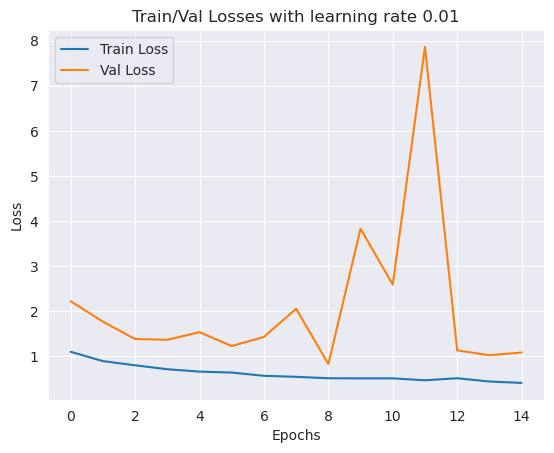

train_losses=[1.0950288313100902, 0.8881294952087584, 0.7956048732441194, 0.7079143972271666, 0.6555125171358659, 0.6342828968686534, 0.5620363443236362, 0.5395431107439118, 0.5081754489168346, 0.5051678862947269, 0.5055067757220143, 0.4625566853543739, 0.5080239381952332, 0.4357239250315971, 0.404226907202196]
[2.2179801531490826, 1.7639117751802718, 1.3787341744653763, 1.361566799500632, 1.5309082858619236, 1.2222913506012114, 1.4251145247429136, 2.0509346437359612, 0.8226965066222918, 3.826020789051813, 2.5873976219741124, 7.86191049076262, 1.126738716922109, 1.0181729588953277, 1.0801916256073922]
Training with learning rate: 0.1


100%|██████████| 126/126 [00:02<00:00, 50.45it/s]

Epoch [1 out of 15], Train --> loss: 1.1117 & accuracy: 52.75%, Validation --> loss: 1.4740 & accuracy: 44.68%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.19it/s]

Epoch [2 out of 15], Train --> loss: 0.9102 & accuracy: 63.89%, Validation --> loss: 1.5762 & accuracy: 54.43%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.18it/s]

Epoch [3 out of 15], Train --> loss: 0.7929 & accuracy: 68.85%, Validation --> loss: 11.3621 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.84it/s]

Epoch [4 out of 15], Train --> loss: 0.7119 & accuracy: 73.18%, Validation --> loss: 1.3246 & accuracy: 52.14%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.13it/s]

Epoch [5 out of 15], Train --> loss: 0.6419 & accuracy: 75.00%, Validation --> loss: 2.0945 & accuracy: 45.97%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.29it/s]

Epoch [6 out of 15], Train --> loss: 0.5779 & accuracy: 78.35%, Validation --> loss: 2.4852 & accuracy: 43.78%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.06it/s]

Epoch [7 out of 15], Train --> loss: 0.5579 & accuracy: 78.91%, Validation --> loss: 2.0077 & accuracy: 53.03%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.49it/s]

Epoch [8 out of 15], Train --> loss: 0.5117 & accuracy: 81.24%, Validation --> loss: 0.8763 & accuracy: 68.26%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.95it/s]

Epoch [9 out of 15], Train --> loss: 0.4820 & accuracy: 82.41%, Validation --> loss: 1.2898 & accuracy: 56.02%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.62it/s]

Epoch [10 out of 15], Train --> loss: 0.4482 & accuracy: 83.42%, Validation --> loss: 0.8593 & accuracy: 70.15%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.57it/s]

Epoch [11 out of 15], Train --> loss: 0.4321 & accuracy: 83.60%, Validation --> loss: 1.9755 & accuracy: 47.16%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.21it/s]

Epoch [12 out of 15], Train --> loss: 0.4049 & accuracy: 85.45%, Validation --> loss: 1.3644 & accuracy: 57.71%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.24it/s]

Epoch [13 out of 15], Train --> loss: 0.3837 & accuracy: 86.65%, Validation --> loss: 1.4824 & accuracy: 64.08%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.49it/s]

Epoch [14 out of 15], Train --> loss: 0.3846 & accuracy: 85.33%, Validation --> loss: 1.2458 & accuracy: 61.79%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.08it/s]

Epoch [15 out of 15], Train --> loss: 0.3740 & accuracy: 86.11%, Validation --> loss: 0.8703 & accuracy: 71.44%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 45.56it/s]


Test Accuracy with learning rate 0.1: 76.10%


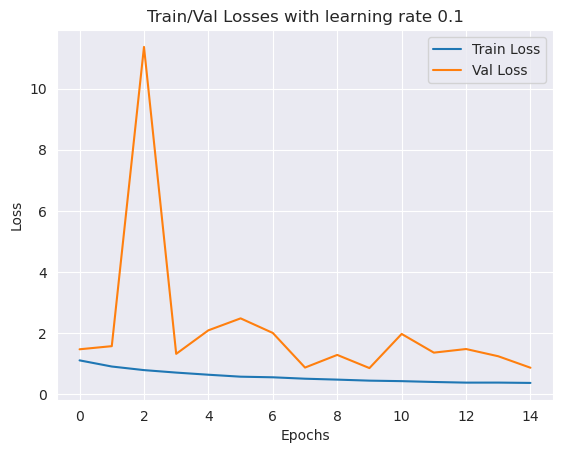

train_losses=[1.111744996329196, 0.9102188757751892, 0.7929032407612107, 0.7119112080207588, 0.6419244844795411, 0.5779419723266918, 0.5578760874939989, 0.5117081852189681, 0.48195715512644705, 0.44821976324396656, 0.43211701908871214, 0.40489801975647277, 0.3837316237914605, 0.38462870301309804, 0.3739704151053275]
[1.4739768474348007, 1.5762094784350622, 11.362124870693872, 1.3245676114918694, 2.0945087882971007, 2.4851753316701406, 2.0076870731418093, 0.8762690309021208, 1.289849993728456, 0.859320615906091, 1.9755340757824125, 1.3643602057108803, 1.482448235272415, 1.2458401560665122, 0.870341295524249]
Training with learning rate: 0.1


100%|██████████| 126/126 [00:02<00:00, 52.25it/s]

Epoch [1 out of 15], Train --> loss: 1.1141 & accuracy: 53.64%, Validation --> loss: 2.3233 & accuracy: 33.83%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.20it/s]

Epoch [2 out of 15], Train --> loss: 0.9046 & accuracy: 63.14%, Validation --> loss: 1.0903 & accuracy: 55.02%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.52it/s]

Epoch [3 out of 15], Train --> loss: 0.8133 & accuracy: 68.52%, Validation --> loss: 1.1633 & accuracy: 56.32%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.36it/s]

Epoch [4 out of 15], Train --> loss: 0.7177 & accuracy: 72.07%, Validation --> loss: 0.9917 & accuracy: 62.59%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.41it/s]

Epoch [5 out of 15], Train --> loss: 0.6530 & accuracy: 74.64%, Validation --> loss: 1.7297 & accuracy: 48.06%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.57it/s]

Epoch [6 out of 15], Train --> loss: 0.6177 & accuracy: 76.19%, Validation --> loss: 2.8990 & accuracy: 40.20%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.55it/s]

Epoch [7 out of 15], Train --> loss: 0.5341 & accuracy: 79.18%, Validation --> loss: 1.1485 & accuracy: 63.58%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.57it/s]

Epoch [8 out of 15], Train --> loss: 0.5650 & accuracy: 77.96%, Validation --> loss: 1.0892 & accuracy: 64.88%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.03it/s]

Epoch [9 out of 15], Train --> loss: 0.5230 & accuracy: 80.62%, Validation --> loss: 1.4239 & accuracy: 55.32%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.19it/s]

Epoch [10 out of 15], Train --> loss: 0.4877 & accuracy: 81.33%, Validation --> loss: 1.2749 & accuracy: 57.61%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.80it/s]

Epoch [11 out of 15], Train --> loss: 0.4629 & accuracy: 82.89%, Validation --> loss: 3.2870 & accuracy: 31.24%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.36it/s]

Epoch [12 out of 15], Train --> loss: 0.4573 & accuracy: 83.39%, Validation --> loss: 0.7986 & accuracy: 69.05%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.42it/s]

Epoch [13 out of 15], Train --> loss: 0.4415 & accuracy: 83.66%, Validation --> loss: 5.1637 & accuracy: 30.95%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.22it/s]

Epoch [14 out of 15], Train --> loss: 0.4699 & accuracy: 81.63%, Validation --> loss: 6.1421 & accuracy: 23.48%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.87it/s]

Epoch [15 out of 15], Train --> loss: 0.4243 & accuracy: 84.29%, Validation --> loss: 1.0819 & accuracy: 58.61%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 44.64it/s]


Test Accuracy with learning rate 0.1: 64.50%


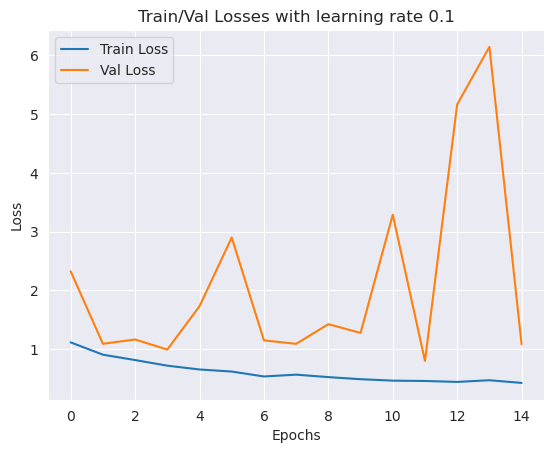

train_losses=[1.1141143179451936, 0.9046094650869437, 0.8132994589629208, 0.717722839486912, 0.6530399700551158, 0.6177457302346434, 0.5341400227605017, 0.5650476296221157, 0.5230415359423951, 0.4877050349173227, 0.4628590647317914, 0.4573085175155882, 0.4414932991340223, 0.4698583120502407, 0.42427494889903183]
[2.3233169430778142, 1.0903182041550439, 1.163260089617873, 0.9916921338391682, 1.7296899646993666, 2.899024381760567, 1.1484854862330451, 1.0892362725876628, 1.423925704662762, 1.274946590855954, 3.2869654803995103, 0.7986388957453152, 5.163668879440853, 6.142079162219214, 1.0819084662057104]
Training with learning rate: 0.1


100%|██████████| 126/126 [00:02<00:00, 51.98it/s]

Epoch [1 out of 15], Train --> loss: 1.1516 & accuracy: 50.57%, Validation --> loss: 2.2510 & accuracy: 43.08%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.17it/s]

Epoch [2 out of 15], Train --> loss: 0.9957 & accuracy: 59.47%, Validation --> loss: 1.0871 & accuracy: 57.71%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.95it/s]

Epoch [3 out of 15], Train --> loss: 0.9160 & accuracy: 63.65%, Validation --> loss: 1.6629 & accuracy: 49.85%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.04it/s]

Epoch [4 out of 15], Train --> loss: 0.8831 & accuracy: 66.97%, Validation --> loss: 1.1470 & accuracy: 43.88%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.46it/s]

Epoch [5 out of 15], Train --> loss: 0.8724 & accuracy: 66.04%, Validation --> loss: 1.4545 & accuracy: 44.58%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.79it/s]

Epoch [6 out of 15], Train --> loss: 0.8508 & accuracy: 66.64%, Validation --> loss: 3.0470 & accuracy: 29.95%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.12it/s]

Epoch [7 out of 15], Train --> loss: 0.8300 & accuracy: 68.40%, Validation --> loss: 2.1834 & accuracy: 44.98%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.73it/s]

Epoch [8 out of 15], Train --> loss: 0.8556 & accuracy: 65.68%, Validation --> loss: 1.4281 & accuracy: 48.56%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.14it/s]

Epoch [9 out of 15], Train --> loss: 0.8414 & accuracy: 66.43%, Validation --> loss: 0.9724 & accuracy: 60.40%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.91it/s]

Epoch [10 out of 15], Train --> loss: 0.8588 & accuracy: 66.88%, Validation --> loss: 2.1895 & accuracy: 37.41%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.30it/s]

Epoch [11 out of 15], Train --> loss: 0.8390 & accuracy: 66.52%, Validation --> loss: 2.5911 & accuracy: 39.80%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.10it/s]

Epoch [12 out of 15], Train --> loss: 0.8443 & accuracy: 67.41%, Validation --> loss: 1.5630 & accuracy: 45.97%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.63it/s]

Epoch [13 out of 15], Train --> loss: 0.8405 & accuracy: 67.11%, Validation --> loss: 1.1201 & accuracy: 58.91%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.28it/s]

Epoch [14 out of 15], Train --> loss: 0.8307 & accuracy: 68.16%, Validation --> loss: 0.9903 & accuracy: 55.62%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.05it/s]

Epoch [15 out of 15], Train --> loss: 0.8439 & accuracy: 67.80%, Validation --> loss: 3.2718 & accuracy: 26.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 45.14it/s]


Test Accuracy with learning rate 0.1: 24.83%


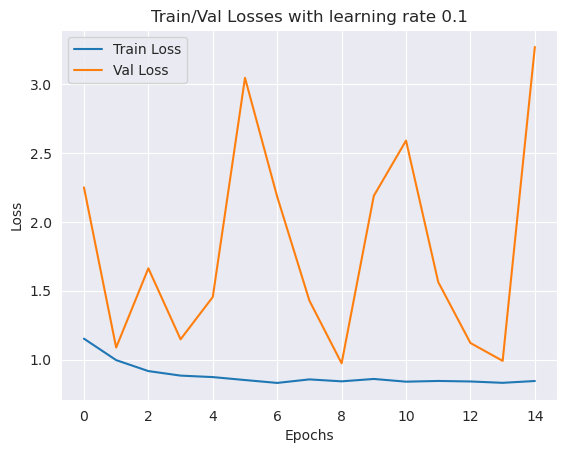

train_losses=[1.151562881924941, 0.9957108694642142, 0.9160135908314607, 0.8830984528565464, 0.8723660277865098, 0.8508378324190017, 0.829964722042152, 0.8556396740717649, 0.8414456737638942, 0.8588092926009459, 0.8390494716622664, 0.8442580689251565, 0.8404678254963959, 0.8306707905200899, 0.8439035365149059]
[2.251009270312294, 1.0870978158144724, 1.6628738476170435, 1.1469640965972627, 1.4544623092053428, 3.047022567854987, 2.183372525941758, 1.4281071824213816, 0.972434125249348, 2.1895485886978725, 2.591071785738071, 1.5629522053022233, 1.120069644044316, 0.9903229001968626, 3.271840543027908]
Training with learning rate: 0.01


100%|██████████| 126/126 [00:02<00:00, 49.26it/s]

Epoch [1 out of 15], Train --> loss: 1.2239 & accuracy: 44.65%, Validation --> loss: 1.1953 & accuracy: 44.68%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.80it/s]

Epoch [2 out of 15], Train --> loss: 1.0328 & accuracy: 56.54%, Validation --> loss: 0.9529 & accuracy: 60.00%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.14it/s]

Epoch [3 out of 15], Train --> loss: 0.8973 & accuracy: 64.67%, Validation --> loss: 0.9420 & accuracy: 63.68%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.28it/s]

Epoch [4 out of 15], Train --> loss: 0.8489 & accuracy: 66.40%, Validation --> loss: 1.0669 & accuracy: 57.71%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.88it/s]

Epoch [5 out of 15], Train --> loss: 0.7558 & accuracy: 70.37%, Validation --> loss: 1.9826 & accuracy: 46.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.49it/s]

Epoch [6 out of 15], Train --> loss: 0.6966 & accuracy: 73.57%, Validation --> loss: 0.9068 & accuracy: 59.30%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.25it/s]

Epoch [7 out of 15], Train --> loss: 0.6327 & accuracy: 76.85%, Validation --> loss: 1.2881 & accuracy: 57.51%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.81it/s]

Epoch [8 out of 15], Train --> loss: 0.6473 & accuracy: 74.67%, Validation --> loss: 2.1000 & accuracy: 47.66%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.00it/s]

Epoch [9 out of 15], Train --> loss: 0.5740 & accuracy: 78.43%, Validation --> loss: 1.8084 & accuracy: 44.68%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.18it/s]

Epoch [10 out of 15], Train --> loss: 0.5523 & accuracy: 78.79%, Validation --> loss: 1.0052 & accuracy: 64.18%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.01it/s]

Epoch [11 out of 15], Train --> loss: 0.5349 & accuracy: 80.29%, Validation --> loss: 0.9195 & accuracy: 66.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.18it/s]

Epoch [12 out of 15], Train --> loss: 0.5179 & accuracy: 80.82%, Validation --> loss: 0.9401 & accuracy: 65.67%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.21it/s]

Epoch [13 out of 15], Train --> loss: 0.5039 & accuracy: 81.90%, Validation --> loss: 1.5179 & accuracy: 50.65%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.64it/s]

Epoch [14 out of 15], Train --> loss: 0.4753 & accuracy: 82.41%, Validation --> loss: 1.8639 & accuracy: 39.40%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.46it/s]

Epoch [15 out of 15], Train --> loss: 0.4570 & accuracy: 82.65%, Validation --> loss: 0.9216 & accuracy: 70.15%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 45.52it/s]


Test Accuracy with learning rate 0.01: 71.93%


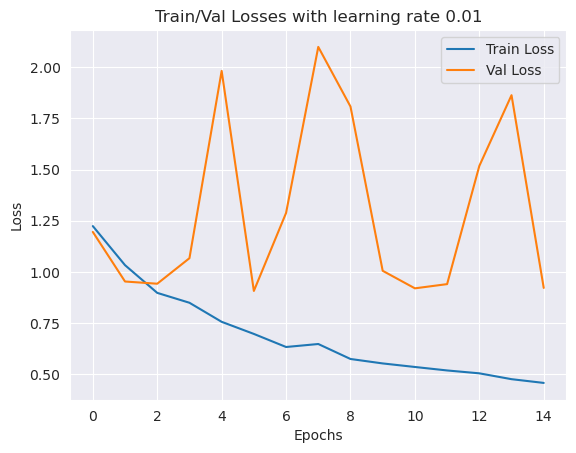

train_losses=[1.2238881043147358, 1.0327817802639736, 0.8973038769138172, 0.8489466309191788, 0.7557729904791052, 0.6965812979919529, 0.6326555507279809, 0.6472584742136958, 0.574015996283307, 0.5522890863917892, 0.5349422573047492, 0.5179483956503982, 0.503875908097319, 0.4752861718093723, 0.4569718298682307]
[1.1952929361945106, 0.9528860090270875, 0.9420485510712578, 1.0668663834295575, 1.982642971807056, 0.9067770320744741, 1.2881152393325928, 2.099999181571461, 1.808403655177071, 1.005241063970422, 0.919501139649323, 0.9401088099157999, 1.5178921008630404, 1.8639127978729824, 0.9216416822894226]
Training with learning rate: 0.01


100%|██████████| 126/126 [00:02<00:00, 51.77it/s]

Epoch [1 out of 15], Train --> loss: 1.2712 & accuracy: 43.61%, Validation --> loss: 1.1530 & accuracy: 50.05%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.37it/s]

Epoch [2 out of 15], Train --> loss: 1.0280 & accuracy: 56.93%, Validation --> loss: 1.8145 & accuracy: 43.18%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.65it/s]

Epoch [3 out of 15], Train --> loss: 0.9168 & accuracy: 62.81%, Validation --> loss: 1.1845 & accuracy: 44.38%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.30it/s]

Epoch [4 out of 15], Train --> loss: 0.8155 & accuracy: 68.58%, Validation --> loss: 0.8601 & accuracy: 67.16%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.97it/s]

Epoch [5 out of 15], Train --> loss: 0.7734 & accuracy: 69.38%, Validation --> loss: 2.2756 & accuracy: 52.44%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.62it/s]

Epoch [6 out of 15], Train --> loss: 0.7189 & accuracy: 72.82%, Validation --> loss: 0.7416 & accuracy: 72.44%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.61it/s]

Epoch [7 out of 15], Train --> loss: 0.6425 & accuracy: 75.12%, Validation --> loss: 0.9588 & accuracy: 65.37%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.53it/s]

Epoch [8 out of 15], Train --> loss: 0.6382 & accuracy: 76.14%, Validation --> loss: 1.1109 & accuracy: 61.29%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 42.95it/s]

Epoch [9 out of 15], Train --> loss: 0.5956 & accuracy: 77.00%, Validation --> loss: 1.1409 & accuracy: 59.70%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.61it/s]

Epoch [10 out of 15], Train --> loss: 0.5725 & accuracy: 78.67%, Validation --> loss: 0.9698 & accuracy: 64.78%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.43it/s]

Epoch [11 out of 15], Train --> loss: 0.5321 & accuracy: 80.59%, Validation --> loss: 0.8701 & accuracy: 68.46%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.36it/s]

Epoch [12 out of 15], Train --> loss: 0.5384 & accuracy: 79.39%, Validation --> loss: 1.2579 & accuracy: 58.71%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.04it/s]

Epoch [13 out of 15], Train --> loss: 0.4653 & accuracy: 82.77%, Validation --> loss: 0.9424 & accuracy: 64.78%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.45it/s]

Epoch [14 out of 15], Train --> loss: 0.4756 & accuracy: 82.20%, Validation --> loss: 0.9288 & accuracy: 66.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.92it/s]

Epoch [15 out of 15], Train --> loss: 0.4704 & accuracy: 82.83%, Validation --> loss: 1.2032 & accuracy: 58.61%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 41.01it/s]


Test Accuracy with learning rate 0.01: 59.63%


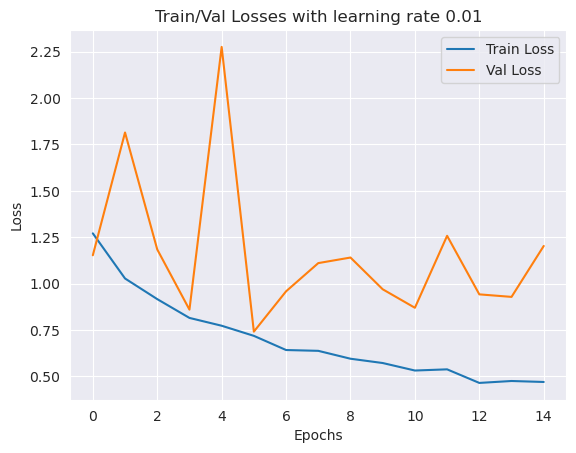

train_losses=[1.2711683057942083, 1.0279972483548458, 0.9168060680135622, 0.8155261943903629, 0.7734210832235636, 0.7188973479097385, 0.6425277470902213, 0.638168800986752, 0.5956479790031484, 0.5725017262529359, 0.5320847160260689, 0.5384089532608348, 0.46528405048895566, 0.4756369923190314, 0.4704125273465968]
[1.153018525668553, 1.81448295712471, 1.1845387454543794, 0.860149016101209, 2.275643491821866, 0.741628601910576, 0.9588252544876129, 1.1108608804643154, 1.14085524541045, 0.9698423018885983, 0.8701133269166189, 1.2579384138659826, 0.9424272431504159, 0.928837930694932, 1.2032026199121324]
Training with learning rate: 0.01


100%|██████████| 126/126 [00:02<00:00, 49.44it/s]

Epoch [1 out of 15], Train --> loss: 1.2142 & accuracy: 45.52%, Validation --> loss: 1.2871 & accuracy: 44.58%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.61it/s]

Epoch [2 out of 15], Train --> loss: 1.0448 & accuracy: 57.62%, Validation --> loss: 1.2695 & accuracy: 45.37%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.47it/s]

Epoch [3 out of 15], Train --> loss: 0.9114 & accuracy: 64.10%, Validation --> loss: 1.0197 & accuracy: 55.12%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.51it/s]

Epoch [4 out of 15], Train --> loss: 0.8333 & accuracy: 67.05%, Validation --> loss: 1.1635 & accuracy: 54.23%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.35it/s]

Epoch [5 out of 15], Train --> loss: 0.7829 & accuracy: 69.89%, Validation --> loss: 1.1532 & accuracy: 52.64%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.66it/s]

Epoch [6 out of 15], Train --> loss: 0.7181 & accuracy: 71.57%, Validation --> loss: 0.8147 & accuracy: 67.96%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.69it/s]

Epoch [7 out of 15], Train --> loss: 0.6854 & accuracy: 73.30%, Validation --> loss: 1.0617 & accuracy: 58.61%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.53it/s]

Epoch [8 out of 15], Train --> loss: 0.6246 & accuracy: 75.96%, Validation --> loss: 1.7983 & accuracy: 48.96%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.41it/s]

Epoch [9 out of 15], Train --> loss: 0.6241 & accuracy: 76.67%, Validation --> loss: 1.6288 & accuracy: 52.74%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.99it/s]

Epoch [10 out of 15], Train --> loss: 0.5764 & accuracy: 78.20%, Validation --> loss: 1.9817 & accuracy: 40.60%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.43it/s]

Epoch [11 out of 15], Train --> loss: 0.5973 & accuracy: 76.40%, Validation --> loss: 0.8105 & accuracy: 66.67%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.35it/s]


Epoch [12 out of 15], Train --> loss: 0.5565 & accuracy: 79.57%, Validation --> loss: 1.0038 & accuracy: 62.79%
Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.35it/s]

Epoch [13 out of 15], Train --> loss: 0.5699 & accuracy: 78.20%, Validation --> loss: 1.0731 & accuracy: 61.49%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.24it/s]

Epoch [14 out of 15], Train --> loss: 0.5204 & accuracy: 80.82%, Validation --> loss: 0.7967 & accuracy: 68.76%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.41it/s]

Epoch [15 out of 15], Train --> loss: 0.5161 & accuracy: 80.97%, Validation --> loss: 3.3076 & accuracy: 41.79%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 37.42it/s]


Test Accuracy with learning rate 0.01: 42.00%


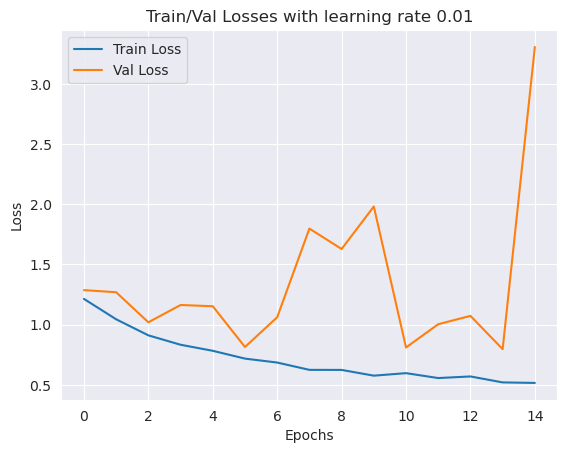

train_losses=[1.2141915009243676, 1.0448080365299326, 0.9113741325023351, 0.8332699545812493, 0.782883337225436, 0.7181105663141942, 0.6854284147160719, 0.6246376800793167, 0.62411471041973, 0.5764174604686177, 0.5972546495159372, 0.556529057570033, 0.569883609550665, 0.5204067149850804, 0.5161244182320655]
[1.2871158969780756, 1.2694824917448893, 1.0197110038901132, 1.1635164554630006, 1.153154487884234, 0.8146777365888868, 1.0616895341210895, 1.7983470967128163, 1.628809237054416, 1.9817215805015866, 0.8105421150251041, 1.0038390781671283, 1.0730888561478682, 0.796716034412384, 3.3076270288891263]
Training with learning rate: 0.1


100%|██████████| 126/126 [00:02<00:00, 50.93it/s]

Epoch [1 out of 15], Train --> loss: 1.2996 & accuracy: 39.13%, Validation --> loss: 1.2227 & accuracy: 43.38%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 43.62it/s]

Epoch [2 out of 15], Train --> loss: 1.1468 & accuracy: 50.36%, Validation --> loss: 1.3944 & accuracy: 42.89%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.72it/s]

Epoch [3 out of 15], Train --> loss: 1.0242 & accuracy: 57.32%, Validation --> loss: 1.2375 & accuracy: 45.17%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.02it/s]

Epoch [4 out of 15], Train --> loss: 0.9443 & accuracy: 62.51%, Validation --> loss: 1.0109 & accuracy: 58.41%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.47it/s]

Epoch [5 out of 15], Train --> loss: 0.8651 & accuracy: 66.01%, Validation --> loss: 1.1708 & accuracy: 57.51%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.91it/s]

Epoch [6 out of 15], Train --> loss: 0.8158 & accuracy: 68.04%, Validation --> loss: 2.0931 & accuracy: 34.23%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.21it/s]

Epoch [7 out of 15], Train --> loss: 0.7477 & accuracy: 70.79%, Validation --> loss: 1.3373 & accuracy: 55.72%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.65it/s]

Epoch [8 out of 15], Train --> loss: 0.7217 & accuracy: 71.30%, Validation --> loss: 1.3391 & accuracy: 50.55%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.04it/s]

Epoch [9 out of 15], Train --> loss: 0.6793 & accuracy: 74.13%, Validation --> loss: 0.8342 & accuracy: 67.66%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.16it/s]

Epoch [10 out of 15], Train --> loss: 0.6718 & accuracy: 75.27%, Validation --> loss: 1.2944 & accuracy: 52.34%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.47it/s]

Epoch [11 out of 15], Train --> loss: 0.6387 & accuracy: 75.75%, Validation --> loss: 1.0312 & accuracy: 59.50%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.27it/s]

Epoch [12 out of 15], Train --> loss: 0.6737 & accuracy: 74.31%, Validation --> loss: 1.3915 & accuracy: 48.96%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.31it/s]

Epoch [13 out of 15], Train --> loss: 0.6315 & accuracy: 76.22%, Validation --> loss: 1.2378 & accuracy: 52.54%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.67it/s]

Epoch [14 out of 15], Train --> loss: 0.5734 & accuracy: 78.64%, Validation --> loss: 1.4237 & accuracy: 54.23%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.44it/s]

Epoch [15 out of 15], Train --> loss: 0.5954 & accuracy: 77.84%, Validation --> loss: 0.9632 & accuracy: 64.08%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 47.51it/s]


Test Accuracy with learning rate 0.1: 66.59%


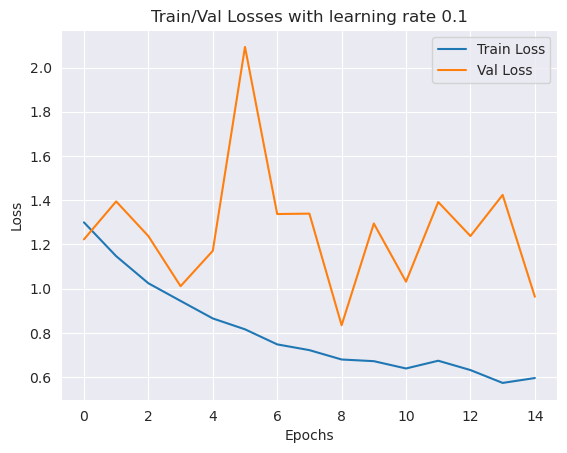

train_losses=[1.2996110352809787, 1.1467764077436953, 1.0241846390299694, 0.9443049832716193, 0.8650593751939214, 0.8158269169649247, 0.747689093478682, 0.7216564791014769, 0.6793218435706273, 0.6717553076496556, 0.6386814873870063, 0.6737377258964541, 0.631507752761067, 0.573364172041914, 0.595448544920202]
[1.2226660980118647, 1.394376635787979, 1.237490599354108, 1.0108738314537775, 1.1707933511998918, 2.0931396810781386, 1.3373021372253933, 1.3390680514867344, 0.8341728696037852, 1.294449330913642, 1.031207914271998, 1.391527821383779, 1.237757144466279, 1.4237034851832995, 0.9631592689288987]
Training with learning rate: 0.1


100%|██████████| 126/126 [00:02<00:00, 49.73it/s]

Epoch [1 out of 15], Train --> loss: 1.4142 & accuracy: 27.39%, Validation --> loss: 1.3783 & accuracy: 28.66%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.46it/s]

Epoch [2 out of 15], Train --> loss: 1.3422 & accuracy: 35.01%, Validation --> loss: 1.3690 & accuracy: 32.04%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.64it/s]

Epoch [3 out of 15], Train --> loss: 1.1437 & accuracy: 49.22%, Validation --> loss: 1.3153 & accuracy: 42.39%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.15it/s]

Epoch [4 out of 15], Train --> loss: 1.0402 & accuracy: 57.62%, Validation --> loss: 2.1595 & accuracy: 26.37%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.07it/s]

Epoch [5 out of 15], Train --> loss: 0.9698 & accuracy: 61.05%, Validation --> loss: 1.3007 & accuracy: 48.16%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.33it/s]

Epoch [6 out of 15], Train --> loss: 0.9097 & accuracy: 63.53%, Validation --> loss: 0.9482 & accuracy: 59.00%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.02it/s]

Epoch [7 out of 15], Train --> loss: 0.8710 & accuracy: 65.20%, Validation --> loss: 1.1112 & accuracy: 54.43%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.66it/s]

Epoch [8 out of 15], Train --> loss: 0.8561 & accuracy: 66.91%, Validation --> loss: 0.9622 & accuracy: 60.90%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.63it/s]

Epoch [9 out of 15], Train --> loss: 0.7910 & accuracy: 68.79%, Validation --> loss: 1.0744 & accuracy: 56.42%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.40it/s]

Epoch [10 out of 15], Train --> loss: 0.7947 & accuracy: 68.88%, Validation --> loss: 1.1257 & accuracy: 55.22%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.00it/s]

Epoch [11 out of 15], Train --> loss: 0.8266 & accuracy: 67.92%, Validation --> loss: 1.3485 & accuracy: 52.04%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.86it/s]

Epoch [12 out of 15], Train --> loss: 0.7559 & accuracy: 70.34%, Validation --> loss: 1.1125 & accuracy: 58.01%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.00it/s]

Epoch [13 out of 15], Train --> loss: 0.7295 & accuracy: 72.16%, Validation --> loss: 2.0332 & accuracy: 31.14%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.43it/s]

Epoch [14 out of 15], Train --> loss: 0.7273 & accuracy: 71.27%, Validation --> loss: 1.3208 & accuracy: 46.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.07it/s]

Epoch [15 out of 15], Train --> loss: 0.6769 & accuracy: 74.58%, Validation --> loss: 2.4180 & accuracy: 33.53%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 45.96it/s]


Test Accuracy with learning rate 0.1: 33.41%


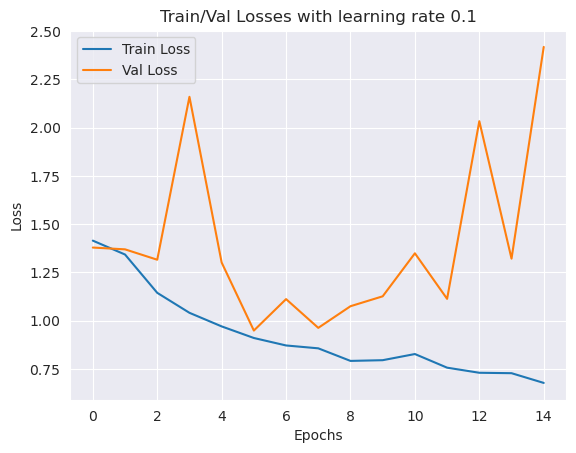

train_losses=[1.4142068120915452, 1.3422075272459972, 1.1436888488778636, 1.0402002618392499, 0.9697631140170633, 0.9096774904141847, 0.8709560075779235, 0.8561200631475676, 0.7909569604264524, 0.794656628320496, 0.8265576769813433, 0.755880576151652, 0.7294666284877531, 0.7273038846211672, 0.6768740179964068]
[1.3783151450611295, 1.3690467897861722, 1.3152771715133909, 2.159462736239509, 1.3007223823713878, 0.9482134921210152, 1.1111722479736994, 0.9621638892188905, 1.0743506999006347, 1.1256947420419208, 1.3485419345753533, 1.1125029078315174, 2.0331749192305972, 1.3207822986065396, 2.4179613524013095]
Training with learning rate: 0.1


100%|██████████| 126/126 [00:02<00:00, 52.17it/s]

Epoch [1 out of 15], Train --> loss: 1.3122 & accuracy: 38.77%, Validation --> loss: 1.1697 & accuracy: 50.35%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.65it/s]

Epoch [2 out of 15], Train --> loss: 1.1194 & accuracy: 52.09%, Validation --> loss: 1.2336 & accuracy: 39.00%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.47it/s]

Epoch [3 out of 15], Train --> loss: 1.0451 & accuracy: 56.87%, Validation --> loss: 1.3329 & accuracy: 45.87%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.46it/s]

Epoch [4 out of 15], Train --> loss: 1.0045 & accuracy: 58.84%, Validation --> loss: 1.0422 & accuracy: 53.63%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.89it/s]

Epoch [5 out of 15], Train --> loss: 0.9813 & accuracy: 59.92%, Validation --> loss: 1.2581 & accuracy: 46.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.33it/s]

Epoch [6 out of 15], Train --> loss: 0.9996 & accuracy: 59.20%, Validation --> loss: 0.9932 & accuracy: 60.30%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.19it/s]

Epoch [7 out of 15], Train --> loss: 0.9652 & accuracy: 60.13%, Validation --> loss: 1.0894 & accuracy: 50.45%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.33it/s]

Epoch [8 out of 15], Train --> loss: 0.9324 & accuracy: 62.75%, Validation --> loss: 1.7701 & accuracy: 42.29%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.10it/s]

Epoch [9 out of 15], Train --> loss: 0.9422 & accuracy: 62.40%, Validation --> loss: 1.0257 & accuracy: 59.10%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.41it/s]

Epoch [10 out of 15], Train --> loss: 0.9209 & accuracy: 63.05%, Validation --> loss: 2.2050 & accuracy: 33.53%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.01it/s]

Epoch [11 out of 15], Train --> loss: 0.9102 & accuracy: 63.83%, Validation --> loss: 1.2111 & accuracy: 55.22%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.21it/s]

Epoch [12 out of 15], Train --> loss: 0.9099 & accuracy: 62.84%, Validation --> loss: 1.8916 & accuracy: 34.53%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.59it/s]

Epoch [13 out of 15], Train --> loss: 0.8895 & accuracy: 64.13%, Validation --> loss: 1.7139 & accuracy: 38.21%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.88it/s]

Epoch [14 out of 15], Train --> loss: 0.9048 & accuracy: 63.26%, Validation --> loss: 2.0332 & accuracy: 39.20%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.08it/s]

Epoch [15 out of 15], Train --> loss: 0.9117 & accuracy: 62.81%, Validation --> loss: 1.4119 & accuracy: 52.04%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 46.79it/s]


Test Accuracy with learning rate 0.1: 52.90%


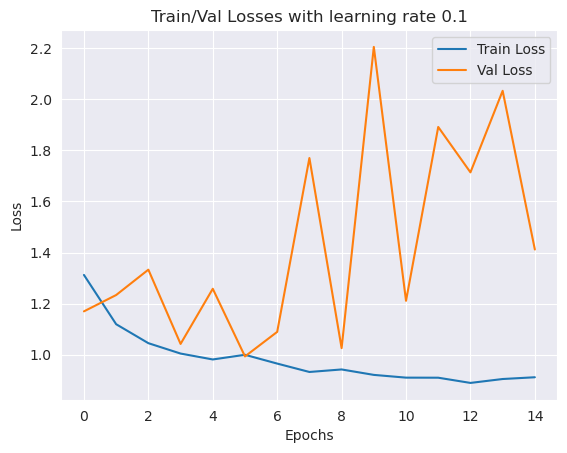

train_losses=[1.3122493648870464, 1.119355687947148, 1.0450997876808013, 1.004455522022839, 0.9813406018624726, 0.99961519319573, 0.9652115608029832, 0.9323502886409122, 0.942213433170091, 0.9209327130158363, 0.9101758779233281, 0.9099122539767217, 0.8894892514534384, 0.9048019055819454, 0.9116753331943457]
[1.169696863681551, 1.233625982015852, 1.3329329750840626, 1.0421722006230127, 1.2581287835325514, 0.9931900186671151, 1.0894065428347814, 1.7700642680837995, 1.0257075374561644, 2.205030148464536, 1.2110553473707228, 1.8916340827468843, 1.7139228409717953, 2.033151494132148, 1.411857840619863]
Training with learning rate: 0.01


100%|██████████| 126/126 [00:02<00:00, 51.16it/s]

Epoch [1 out of 15], Train --> loss: 1.2728 & accuracy: 40.44%, Validation --> loss: 1.3408 & accuracy: 31.84%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.52it/s]

Epoch [2 out of 15], Train --> loss: 1.1250 & accuracy: 51.28%, Validation --> loss: 1.0028 & accuracy: 63.18%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.09it/s]

Epoch [3 out of 15], Train --> loss: 0.9600 & accuracy: 61.23%, Validation --> loss: 2.3620 & accuracy: 29.15%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.96it/s]

Epoch [4 out of 15], Train --> loss: 0.8187 & accuracy: 67.80%, Validation --> loss: 1.0783 & accuracy: 53.83%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.13it/s]

Epoch [5 out of 15], Train --> loss: 0.7345 & accuracy: 71.95%, Validation --> loss: 1.2128 & accuracy: 48.46%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.08it/s]

Epoch [6 out of 15], Train --> loss: 0.6466 & accuracy: 74.34%, Validation --> loss: 1.0291 & accuracy: 57.91%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.03it/s]

Epoch [7 out of 15], Train --> loss: 0.6148 & accuracy: 76.37%, Validation --> loss: 6.8115 & accuracy: 27.06%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.39it/s]

Epoch [8 out of 15], Train --> loss: 0.5604 & accuracy: 78.91%, Validation --> loss: 4.1281 & accuracy: 27.56%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.44it/s]

Epoch [9 out of 15], Train --> loss: 0.5494 & accuracy: 79.48%, Validation --> loss: 1.0517 & accuracy: 60.30%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.41it/s]

Epoch [10 out of 15], Train --> loss: 0.5124 & accuracy: 81.27%, Validation --> loss: 1.6278 & accuracy: 54.63%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.39it/s]

Epoch [11 out of 15], Train --> loss: 0.4769 & accuracy: 82.35%, Validation --> loss: 3.4675 & accuracy: 39.60%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.28it/s]

Epoch [12 out of 15], Train --> loss: 0.4357 & accuracy: 84.59%, Validation --> loss: 4.6440 & accuracy: 42.19%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.37it/s]

Epoch [13 out of 15], Train --> loss: 0.4659 & accuracy: 82.47%, Validation --> loss: 1.9410 & accuracy: 54.13%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.37it/s]

Epoch [14 out of 15], Train --> loss: 0.4311 & accuracy: 84.44%, Validation --> loss: 1.4937 & accuracy: 56.82%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.28it/s]

Epoch [15 out of 15], Train --> loss: 0.3794 & accuracy: 86.08%, Validation --> loss: 0.7522 & accuracy: 74.03%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 39.70it/s]


Test Accuracy with learning rate 0.01: 76.10%


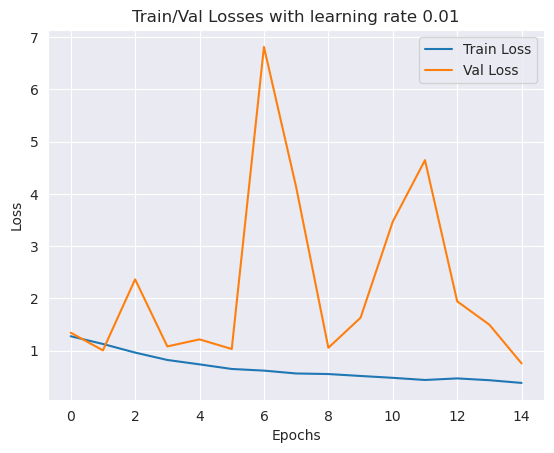

train_losses=[1.2727838357763814, 1.1250270873948327, 0.960031052762398, 0.8187109276047755, 0.7345174703933743, 0.646563838731702, 0.6148008659197494, 0.5603591608581509, 0.5493606896381958, 0.5123847163769112, 0.47689821845840724, 0.4356986362851605, 0.4659034158492145, 0.4311454089398458, 0.37939451017410347]
[1.3407675534013719, 1.0028392942178816, 2.3620385660065546, 1.0783230246059479, 1.2127817999275903, 1.0290943792178517, 6.8114983855731905, 4.128145500781044, 1.05173091720494, 1.6277677190918771, 3.4675104066966074, 4.644045922254759, 1.9410293993968812, 1.4936908942366403, 0.7521911306631943]
Training with learning rate: 0.01


100%|██████████| 126/126 [00:02<00:00, 50.29it/s]

Epoch [1 out of 15], Train --> loss: 1.2540 & accuracy: 43.07%, Validation --> loss: 1.4466 & accuracy: 38.91%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.81it/s]

Epoch [2 out of 15], Train --> loss: 1.2330 & accuracy: 45.13%, Validation --> loss: 4.4054 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.35it/s]

Epoch [3 out of 15], Train --> loss: 1.2470 & accuracy: 43.31%, Validation --> loss: 1.4577 & accuracy: 38.71%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.42it/s]

Epoch [4 out of 15], Train --> loss: 1.2251 & accuracy: 44.15%, Validation --> loss: 2.3863 & accuracy: 26.17%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.16it/s]

Epoch [5 out of 15], Train --> loss: 1.2182 & accuracy: 44.92%, Validation --> loss: 1.6708 & accuracy: 29.35%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.01it/s]

Epoch [6 out of 15], Train --> loss: 1.2224 & accuracy: 44.98%, Validation --> loss: 1.8915 & accuracy: 35.82%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.66it/s]

Epoch [7 out of 15], Train --> loss: 1.2137 & accuracy: 44.53%, Validation --> loss: 1.2431 & accuracy: 39.00%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.79it/s]

Epoch [8 out of 15], Train --> loss: 1.2091 & accuracy: 45.88%, Validation --> loss: 1.4345 & accuracy: 27.16%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.76it/s]

Epoch [9 out of 15], Train --> loss: 1.2057 & accuracy: 46.57%, Validation --> loss: 1.6172 & accuracy: 34.13%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.54it/s]

Epoch [10 out of 15], Train --> loss: 1.2112 & accuracy: 45.19%, Validation --> loss: 1.7753 & accuracy: 25.97%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.72it/s]

Epoch [11 out of 15], Train --> loss: 1.2109 & accuracy: 45.28%, Validation --> loss: 2.6215 & accuracy: 22.69%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.40it/s]

Epoch [12 out of 15], Train --> loss: 1.2107 & accuracy: 45.64%, Validation --> loss: 1.4913 & accuracy: 30.95%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.76it/s]

Epoch [13 out of 15], Train --> loss: 1.2081 & accuracy: 45.91%, Validation --> loss: 1.5358 & accuracy: 26.67%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.17it/s]

Epoch [14 out of 15], Train --> loss: 1.2085 & accuracy: 45.76%, Validation --> loss: 1.4205 & accuracy: 32.44%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.64it/s]

Epoch [15 out of 15], Train --> loss: 1.2062 & accuracy: 45.25%, Validation --> loss: 3.5613 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 44.26it/s]


Test Accuracy with learning rate 0.01: 24.13%


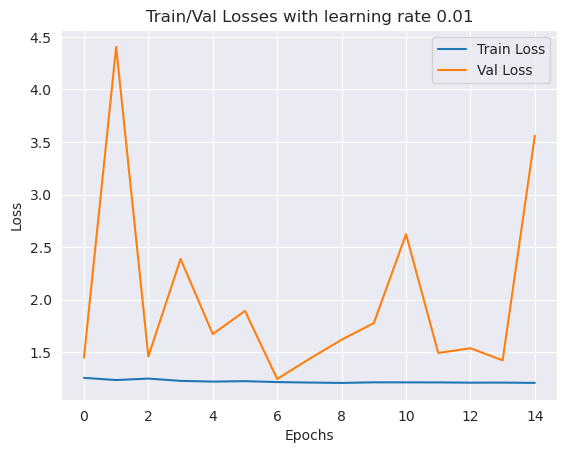

train_losses=[1.2539899120182867, 1.2329709815808299, 1.2470189045607902, 1.2250535367212319, 1.2182429166853002, 1.2224085695134712, 1.213671872041106, 1.2091194337193891, 1.2056691766069727, 1.2112454813249356, 1.2108894146996636, 1.210690264627871, 1.2080853535907081, 1.2085400585058481, 1.206156361643625]
[1.4465503001969957, 4.405378258417523, 1.4577024820305051, 2.386333605126729, 1.670752378210189, 1.8914601433844793, 1.2430671089225345, 1.43447706292546, 1.6172231587152632, 1.7753039068645902, 2.6215091972124007, 1.4913179997413877, 1.5357662836710613, 1.4205461939175923, 3.561258460794176]
Training with learning rate: 0.01


100%|██████████| 126/126 [00:02<00:00, 51.88it/s]

Epoch [1 out of 15], Train --> loss: 1.3073 & accuracy: 38.47%, Validation --> loss: 1.5558 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.11it/s]

Epoch [2 out of 15], Train --> loss: 1.3163 & accuracy: 37.51%, Validation --> loss: 1.5521 & accuracy: 27.86%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.96it/s]

Epoch [3 out of 15], Train --> loss: 1.3288 & accuracy: 36.32%, Validation --> loss: 1.8239 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.47it/s]

Epoch [4 out of 15], Train --> loss: 1.3155 & accuracy: 37.31%, Validation --> loss: 1.5827 & accuracy: 22.69%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.49it/s]

Epoch [5 out of 15], Train --> loss: 1.3125 & accuracy: 38.26%, Validation --> loss: 2.1719 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.50it/s]

Epoch [6 out of 15], Train --> loss: 1.3121 & accuracy: 37.75%, Validation --> loss: 2.6046 & accuracy: 26.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.39it/s]

Epoch [7 out of 15], Train --> loss: 1.3151 & accuracy: 36.89%, Validation --> loss: 1.6067 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.01it/s]

Epoch [8 out of 15], Train --> loss: 1.3197 & accuracy: 37.57%, Validation --> loss: 1.5796 & accuracy: 25.37%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.83it/s]

Epoch [9 out of 15], Train --> loss: 1.3400 & accuracy: 34.50%, Validation --> loss: 1.4070 & accuracy: 30.35%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.69it/s]

Epoch [10 out of 15], Train --> loss: 1.3251 & accuracy: 36.53%, Validation --> loss: 3.0837 & accuracy: 26.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.60it/s]

Epoch [11 out of 15], Train --> loss: 1.3214 & accuracy: 37.40%, Validation --> loss: 2.2798 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.64it/s]

Epoch [12 out of 15], Train --> loss: 1.3188 & accuracy: 36.41%, Validation --> loss: 1.4127 & accuracy: 26.17%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.70it/s]

Epoch [13 out of 15], Train --> loss: 1.3218 & accuracy: 36.35%, Validation --> loss: 6.1553 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.29it/s]

Epoch [14 out of 15], Train --> loss: 1.3242 & accuracy: 36.74%, Validation --> loss: 2.2503 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.41it/s]

Epoch [15 out of 15], Train --> loss: 1.3109 & accuracy: 37.69%, Validation --> loss: 2.4994 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 48.40it/s]


Test Accuracy with learning rate 0.01: 24.13%


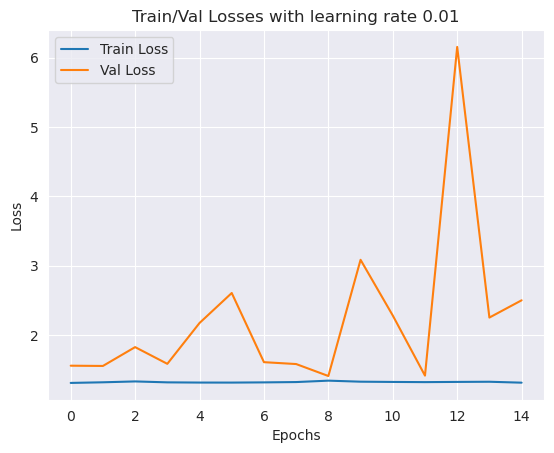

train_losses=[1.3072691317958878, 1.3163344444693699, 1.3288236375640285, 1.315453959251076, 1.3124566203370014, 1.3121084091486965, 1.3150768479185628, 1.319682388715357, 1.3399860395167493, 1.3251081064948034, 1.3214021059095433, 1.318789537880472, 1.3217834954045553, 1.324155445599613, 1.3108881771706737]
[1.555811623732249, 1.5521231132840354, 1.8238769537872739, 1.5826741542134966, 2.171940186194011, 2.6046227211990054, 1.6067082134504167, 1.5795971136244515, 1.4069626463784113, 3.08366046254597, 2.2798485211909765, 1.412724073444094, 6.155327482829018, 2.2503361782384297, 2.4994210998217263]
Training with learning rate: 0.1


100%|██████████| 126/126 [00:02<00:00, 52.84it/s]

Epoch [1 out of 15], Train --> loss: 1.2905 & accuracy: 39.55%, Validation --> loss: 1.3797 & accuracy: 36.62%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.04it/s]

Epoch [2 out of 15], Train --> loss: 1.1588 & accuracy: 48.75%, Validation --> loss: 1.2999 & accuracy: 39.30%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.92it/s]

Epoch [3 out of 15], Train --> loss: 1.0292 & accuracy: 57.50%, Validation --> loss: 1.1008 & accuracy: 53.83%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.96it/s]

Epoch [4 out of 15], Train --> loss: 0.9150 & accuracy: 63.17%, Validation --> loss: 3.2986 & accuracy: 34.53%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.43it/s]

Epoch [5 out of 15], Train --> loss: 0.8493 & accuracy: 66.82%, Validation --> loss: 1.5465 & accuracy: 46.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.76it/s]

Epoch [6 out of 15], Train --> loss: 0.7801 & accuracy: 69.15%, Validation --> loss: 1.4406 & accuracy: 50.35%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.45it/s]

Epoch [7 out of 15], Train --> loss: 0.7108 & accuracy: 73.03%, Validation --> loss: 2.0243 & accuracy: 47.86%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.82it/s]

Epoch [8 out of 15], Train --> loss: 0.6646 & accuracy: 75.06%, Validation --> loss: 1.3001 & accuracy: 55.02%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.81it/s]

Epoch [9 out of 15], Train --> loss: 0.6154 & accuracy: 76.67%, Validation --> loss: 5.7872 & accuracy: 27.06%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 54.19it/s]

Epoch [10 out of 15], Train --> loss: 0.5881 & accuracy: 77.69%, Validation --> loss: 1.9248 & accuracy: 43.38%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.54it/s]

Epoch [11 out of 15], Train --> loss: 0.5511 & accuracy: 78.82%, Validation --> loss: 1.6237 & accuracy: 58.41%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.94it/s]

Epoch [12 out of 15], Train --> loss: 0.5126 & accuracy: 80.70%, Validation --> loss: 1.5067 & accuracy: 61.79%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.67it/s]

Epoch [13 out of 15], Train --> loss: 0.5494 & accuracy: 79.15%, Validation --> loss: 2.3454 & accuracy: 49.25%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.06it/s]

Epoch [14 out of 15], Train --> loss: 0.5064 & accuracy: 80.65%, Validation --> loss: 3.3256 & accuracy: 40.90%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.78it/s]

Epoch [15 out of 15], Train --> loss: 0.4707 & accuracy: 82.29%, Validation --> loss: 4.1352 & accuracy: 28.16%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 48.44it/s]


Test Accuracy with learning rate 0.1: 27.61%


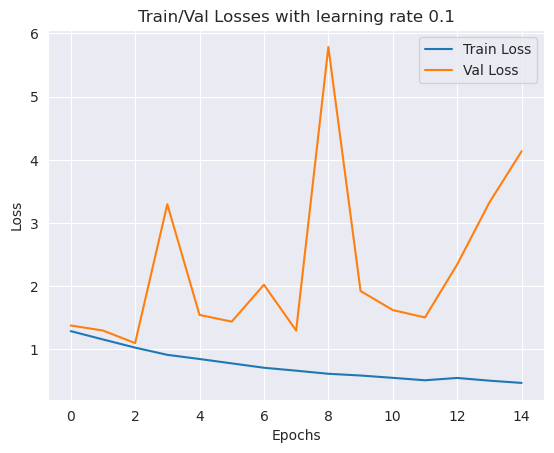

train_losses=[1.2904821100838144, 1.1588003715069026, 1.0292046088591964, 0.9150067295407908, 0.8493435573819713, 0.7800921117064492, 0.7107845392247089, 0.664631250863428, 0.6154213623634955, 0.5880813531773187, 0.551144938044659, 0.5126275408719633, 0.5493972269386977, 0.5063502037706552, 0.4707442171213735]
[1.3796585372516088, 1.299863125123675, 1.1008084686029525, 3.2985511015331936, 1.5465227897678102, 1.4406184814279042, 2.0242931392221224, 1.300100747318495, 5.787234880148419, 1.9248298595822046, 1.6237150344347198, 1.5066606479268225, 2.3453932654053444, 3.325581491703079, 4.135212354243747]
Training with learning rate: 0.1


100%|██████████| 126/126 [00:02<00:00, 52.81it/s]

Epoch [1 out of 15], Train --> loss: 1.3543 & accuracy: 34.41%, Validation --> loss: 7.5228 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.74it/s]

Epoch [2 out of 15], Train --> loss: 1.3672 & accuracy: 32.97%, Validation --> loss: 1.3924 & accuracy: 33.73%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.72it/s]

Epoch [3 out of 15], Train --> loss: 1.3865 & accuracy: 30.65%, Validation --> loss: 22.5212 & accuracy: 26.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.46it/s]

Epoch [4 out of 15], Train --> loss: 1.3749 & accuracy: 32.41%, Validation --> loss: 1.9334 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.89it/s]

Epoch [5 out of 15], Train --> loss: 1.3887 & accuracy: 30.29%, Validation --> loss: 1.9457 & accuracy: 22.69%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.22it/s]

Epoch [6 out of 15], Train --> loss: 1.3878 & accuracy: 30.14%, Validation --> loss: 1.6021 & accuracy: 25.87%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.66it/s]

Epoch [7 out of 15], Train --> loss: 1.3776 & accuracy: 31.60%, Validation --> loss: 5.1243 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.01it/s]

Epoch [8 out of 15], Train --> loss: 1.3878 & accuracy: 31.78%, Validation --> loss: 1.4066 & accuracy: 27.16%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.98it/s]

Epoch [9 out of 15], Train --> loss: 1.3888 & accuracy: 30.23%, Validation --> loss: 1.4510 & accuracy: 27.26%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.15it/s]

Epoch [10 out of 15], Train --> loss: 1.3921 & accuracy: 30.44%, Validation --> loss: 3.1465 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.95it/s]

Epoch [11 out of 15], Train --> loss: 1.3792 & accuracy: 31.36%, Validation --> loss: 1.5635 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.79it/s]

Epoch [12 out of 15], Train --> loss: 1.3872 & accuracy: 30.56%, Validation --> loss: 1.7559 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.96it/s]

Epoch [13 out of 15], Train --> loss: 1.3830 & accuracy: 30.79%, Validation --> loss: 1.4112 & accuracy: 32.84%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.49it/s]

Epoch [14 out of 15], Train --> loss: 1.3769 & accuracy: 32.23%, Validation --> loss: 1.6586 & accuracy: 22.69%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.72it/s]

Epoch [15 out of 15], Train --> loss: 1.3775 & accuracy: 31.60%, Validation --> loss: 2.0003 & accuracy: 26.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 47.35it/s]


Test Accuracy with learning rate 0.1: 27.15%


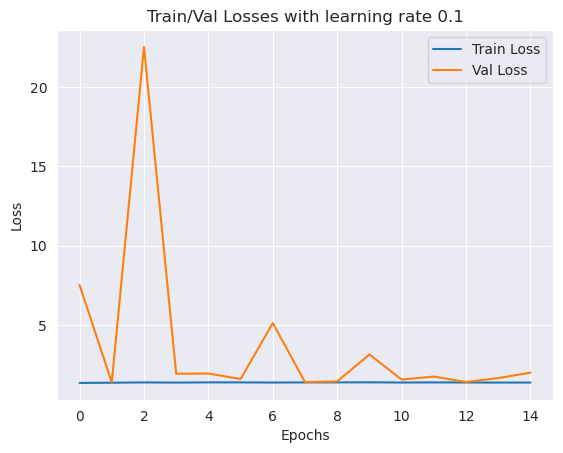

train_losses=[1.35434186501264, 1.3671768593617442, 1.3865296418171793, 1.3748941077252845, 1.3886810925240163, 1.3877782963909795, 1.3776339384991685, 1.3878431044216657, 1.388824186063325, 1.3920749872567262, 1.3791770957819318, 1.3872121310746186, 1.3829731002343297, 1.3769077034155908, 1.3774576148725068]
[7.522783296448844, 1.3923767133364602, 22.521177768707275, 1.9333808346400185, 1.9456785742252591, 1.602119645429036, 5.12427830885327, 1.4066216150919597, 1.4510263251879858, 3.146540200899518, 1.5634690840092917, 1.7558919285971022, 1.4111833572387695, 1.6586393704490057, 2.000301225317849]
Training with learning rate: 0.1


100%|██████████| 126/126 [00:02<00:00, 52.44it/s]

Epoch [1 out of 15], Train --> loss: 1.4102 & accuracy: 29.51%, Validation --> loss: 1.5413 & accuracy: 26.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.88it/s]

Epoch [2 out of 15], Train --> loss: 1.4155 & accuracy: 26.08%, Validation --> loss: 1.4335 & accuracy: 22.79%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.06it/s]

Epoch [3 out of 15], Train --> loss: 1.4142 & accuracy: 26.31%, Validation --> loss: 2.0486 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.60it/s]

Epoch [4 out of 15], Train --> loss: 1.4161 & accuracy: 24.55%, Validation --> loss: 1.5302 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.06it/s]

Epoch [5 out of 15], Train --> loss: 1.4151 & accuracy: 24.91%, Validation --> loss: 2.2125 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.46it/s]

Epoch [6 out of 15], Train --> loss: 1.4180 & accuracy: 24.58%, Validation --> loss: 1.4282 & accuracy: 26.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.02it/s]

Epoch [7 out of 15], Train --> loss: 1.4158 & accuracy: 24.82%, Validation --> loss: 1.4211 & accuracy: 25.07%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.52it/s]

Epoch [8 out of 15], Train --> loss: 1.4096 & accuracy: 26.85%, Validation --> loss: 1.3953 & accuracy: 22.29%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.89it/s]

Epoch [9 out of 15], Train --> loss: 1.4123 & accuracy: 25.18%, Validation --> loss: 1.4014 & accuracy: 26.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.51it/s]

Epoch [10 out of 15], Train --> loss: 1.4125 & accuracy: 25.21%, Validation --> loss: 1.4167 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.72it/s]

Epoch [11 out of 15], Train --> loss: 1.4114 & accuracy: 26.82%, Validation --> loss: 2.4271 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.35it/s]

Epoch [12 out of 15], Train --> loss: 1.4152 & accuracy: 24.91%, Validation --> loss: 1.9492 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.71it/s]

Epoch [13 out of 15], Train --> loss: 1.4132 & accuracy: 25.78%, Validation --> loss: 1.3932 & accuracy: 25.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.53it/s]

Epoch [14 out of 15], Train --> loss: 1.4134 & accuracy: 26.16%, Validation --> loss: 1.8738 & accuracy: 25.37%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.16it/s]

Epoch [15 out of 15], Train --> loss: 1.4167 & accuracy: 25.45%, Validation --> loss: 1.4073 & accuracy: 25.77%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 46.01it/s]


Test Accuracy with learning rate 0.1: 25.99%


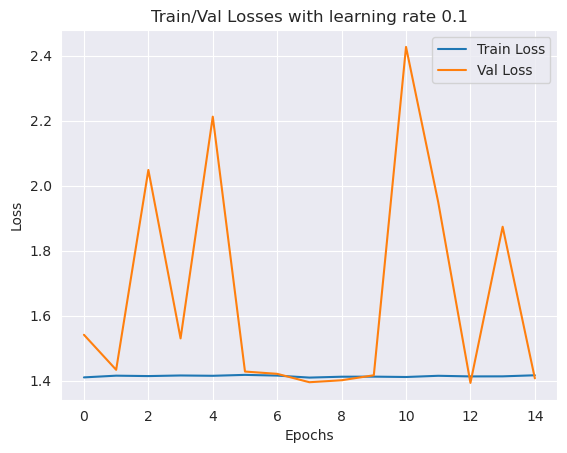

train_losses=[1.410238418345804, 1.4155137234485236, 1.4142489034975911, 1.4161007105592895, 1.4151403388999813, 1.4179514879827568, 1.4157693206837183, 1.4095925274782932, 1.4122738203740632, 1.4125259980950549, 1.4114111761489176, 1.4151549467323503, 1.4132235661895862, 1.413423455131367, 1.4167325556420483]
[1.5413011198952085, 1.433545690680307, 2.0485908852683172, 1.5302226060912723, 2.212485870671651, 1.4281704444733878, 1.4211481639317103, 1.3953190531049455, 1.4014212867570301, 1.4167267103043815, 2.4271052181720734, 1.9492242728906966, 1.3931987512679327, 1.8737803035312228, 1.4072866931794181]


In [18]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from custom_adam import Adam

num_epochs = 15
weight_decay_list = [0, 0.001, 0.01]
learning_rates = [0.01, 0.1]
optimizers = [optim.SGD, Adam, optim.RMSprop]

for opt in optimizers:
    for lr in learning_rates:
        for w in weight_decay_list:
            model = AircraftNet(_input=IMAGE_HEIGHT*IMAGE_WIDTH*3, hidden_size=256, _output=4, batch_normalization=True).to(device)

            print(f"Training with learning rate: {lr}")
            train_losses, val_losses, res_with_batch_norm = train_model(model, opt, train_data_loader, val_data_loader, num_epochs, lr, weight_decay=w, df=res_with_batch_norm)

            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for batch_idx, (images, labels) in enumerate(tqdm(test_data_loader)):
                    images = images.view(-1, IMAGE_HEIGHT*IMAGE_WIDTH*3).to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            accuracy = correct / total
            print(f"Test Accuracy with learning rate {lr}: {100 * accuracy:.2f}%")

            plt.plot(range(num_epochs), train_losses, label='Train Loss')
            plt.plot(range(num_epochs), val_losses, label='Val Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title(f'Train/Val Losses with learning rate {lr}')
            plt.legend()
            plt.show()

            print(f"{train_losses=}\n{val_losses}")

In [19]:
res_with_batch_norm

,opt,best_acc,lr,weight_decay,best_accuracy
0,SGD,NaN,0.01,0,0.680597
0,SGD,NaN,0.01,0.001,0.734328
0,SGD,NaN,0.01,0.01,0.669652
0,SGD,NaN,0.10,0,0.714428
0,SGD,NaN,0.10,0.001,0.690547
0,SGD,NaN,0.10,0.01,0.603980
0,Adam,NaN,0.01,0,0.701493
0,Adam,NaN,0.01,0.001,0.724378
0,Adam,NaN,0.01,0.01,0.687562
0,Adam,NaN,0.10,0,0.676617


## Fine Tuning

Обучим модели с пятью лучшими параметрами и возьмем лучший. Так как мы видим, что на графике train/val loss, нейронная сеть как с batch-normalization, так и без нее может достичь лучших результатов.

Params lr=0.01, w=0, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 126/126 [00:02<00:00, 50.06it/s]

Epoch [1 out of 50], Train --> loss: 1.2432 & accuracy: 43.76%, Validation --> loss: 1.7201 & accuracy: 35.02%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.76it/s]

Epoch [2 out of 50], Train --> loss: 1.0292 & accuracy: 58.39%, Validation --> loss: 1.6820 & accuracy: 39.00%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.05it/s]

Epoch [3 out of 50], Train --> loss: 0.9238 & accuracy: 63.86%, Validation --> loss: 1.0150 & accuracy: 53.43%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.13it/s]

Epoch [4 out of 50], Train --> loss: 0.8000 & accuracy: 69.09%, Validation --> loss: 1.5774 & accuracy: 46.77%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.14it/s]

Epoch [5 out of 50], Train --> loss: 0.7430 & accuracy: 71.03%, Validation --> loss: 0.9011 & accuracy: 65.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.36it/s]

Epoch [6 out of 50], Train --> loss: 0.6627 & accuracy: 74.79%, Validation --> loss: 1.3201 & accuracy: 49.35%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.42it/s]

Epoch [7 out of 50], Train --> loss: 0.5991 & accuracy: 77.06%, Validation --> loss: 1.1312 & accuracy: 59.70%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.32it/s]

Epoch [8 out of 50], Train --> loss: 0.5699 & accuracy: 78.64%, Validation --> loss: 1.0539 & accuracy: 59.70%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.52it/s]

Epoch [9 out of 50], Train --> loss: 0.5334 & accuracy: 79.87%, Validation --> loss: 4.1934 & accuracy: 34.93%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.75it/s]

Epoch [10 out of 50], Train --> loss: 0.5166 & accuracy: 81.15%, Validation --> loss: 4.9042 & accuracy: 33.03%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.10it/s]

Epoch [11 out of 50], Train --> loss: 0.4561 & accuracy: 83.48%, Validation --> loss: 3.9150 & accuracy: 43.58%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.97it/s]

Epoch [12 out of 50], Train --> loss: 0.4484 & accuracy: 83.27%, Validation --> loss: 1.9000 & accuracy: 47.46%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.98it/s]

Epoch [13 out of 50], Train --> loss: 0.4329 & accuracy: 84.29%, Validation --> loss: 1.4162 & accuracy: 61.29%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.79it/s]

Epoch [14 out of 50], Train --> loss: 0.4044 & accuracy: 85.39%, Validation --> loss: 2.2637 & accuracy: 43.28%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.42it/s]

Epoch [15 out of 50], Train --> loss: 0.3892 & accuracy: 84.47%, Validation --> loss: 0.8047 & accuracy: 69.65%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.17it/s]

Epoch [16 out of 50], Train --> loss: 0.3969 & accuracy: 85.48%, Validation --> loss: 0.9186 & accuracy: 70.85%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.01it/s]

Epoch [17 out of 50], Train --> loss: 0.3743 & accuracy: 86.50%, Validation --> loss: 1.7150 & accuracy: 58.91%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.56it/s]

Epoch [18 out of 50], Train --> loss: 0.3651 & accuracy: 86.92%, Validation --> loss: 1.3223 & accuracy: 62.09%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.27it/s]

Epoch [19 out of 50], Train --> loss: 0.3318 & accuracy: 88.17%, Validation --> loss: 0.8091 & accuracy: 73.93%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.75it/s]

Epoch [20 out of 50], Train --> loss: 0.3174 & accuracy: 88.35%, Validation --> loss: 2.3367 & accuracy: 48.46%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.32it/s]

Epoch [21 out of 50], Train --> loss: 0.3379 & accuracy: 87.25%, Validation --> loss: 1.7295 & accuracy: 55.82%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.96it/s]

Epoch [22 out of 50], Train --> loss: 0.2986 & accuracy: 89.87%, Validation --> loss: 4.4668 & accuracy: 35.82%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.83it/s]

Epoch [23 out of 50], Train --> loss: 0.3174 & accuracy: 88.20%, Validation --> loss: 1.1423 & accuracy: 68.86%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.86it/s]

Epoch [24 out of 50], Train --> loss: 0.3278 & accuracy: 89.13%, Validation --> loss: 1.0101 & accuracy: 67.06%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.04it/s]

Epoch [25 out of 50], Train --> loss: 0.3028 & accuracy: 89.31%, Validation --> loss: 5.9260 & accuracy: 34.13%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.54it/s]

Epoch [26 out of 50], Train --> loss: 0.2928 & accuracy: 89.31%, Validation --> loss: 2.2314 & accuracy: 48.86%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.82it/s]

Epoch [27 out of 50], Train --> loss: 0.2933 & accuracy: 89.87%, Validation --> loss: 8.3072 & accuracy: 26.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.80it/s]

Epoch [28 out of 50], Train --> loss: 0.2733 & accuracy: 90.35%, Validation --> loss: 2.7321 & accuracy: 42.79%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.47it/s]

Epoch [29 out of 50], Train --> loss: 0.2924 & accuracy: 89.46%, Validation --> loss: 2.4113 & accuracy: 47.36%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.18it/s]

Epoch [30 out of 50], Train --> loss: 0.2884 & accuracy: 90.17%, Validation --> loss: 2.4588 & accuracy: 50.75%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.89it/s]

Epoch [31 out of 50], Train --> loss: 0.2616 & accuracy: 90.92%, Validation --> loss: 1.7682 & accuracy: 58.91%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.64it/s]

Epoch [32 out of 50], Train --> loss: 0.2420 & accuracy: 91.46%, Validation --> loss: 2.2213 & accuracy: 48.96%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.93it/s]

Epoch [33 out of 50], Train --> loss: 0.2440 & accuracy: 91.10%, Validation --> loss: 1.2684 & accuracy: 66.17%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.46it/s]

Epoch [34 out of 50], Train --> loss: 0.2664 & accuracy: 90.80%, Validation --> loss: 13.4145 & accuracy: 25.97%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.84it/s]

Epoch [35 out of 50], Train --> loss: 0.2540 & accuracy: 90.77%, Validation --> loss: 3.0713 & accuracy: 49.85%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.39it/s]

Epoch [36 out of 50], Train --> loss: 0.2538 & accuracy: 91.40%, Validation --> loss: 1.1075 & accuracy: 70.65%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.38it/s]

Epoch [37 out of 50], Train --> loss: 0.2458 & accuracy: 91.34%, Validation --> loss: 1.9293 & accuracy: 49.75%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.11it/s]

Epoch [38 out of 50], Train --> loss: 0.2138 & accuracy: 92.32%, Validation --> loss: 2.7950 & accuracy: 37.71%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.02it/s]

Epoch [39 out of 50], Train --> loss: 0.2398 & accuracy: 91.76%, Validation --> loss: 1.9891 & accuracy: 51.74%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.50it/s]

Epoch [40 out of 50], Train --> loss: 0.2499 & accuracy: 91.13%, Validation --> loss: 1.4600 & accuracy: 60.40%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.98it/s]

Epoch [41 out of 50], Train --> loss: 0.2131 & accuracy: 92.50%, Validation --> loss: 0.8423 & accuracy: 73.23%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.72it/s]

Epoch [42 out of 50], Train --> loss: 0.2138 & accuracy: 92.29%, Validation --> loss: 1.5173 & accuracy: 62.79%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.97it/s]

Epoch [43 out of 50], Train --> loss: 0.2077 & accuracy: 92.71%, Validation --> loss: 1.7390 & accuracy: 59.60%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.77it/s]

Epoch [44 out of 50], Train --> loss: 0.2113 & accuracy: 92.74%, Validation --> loss: 0.8907 & accuracy: 75.22%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.19it/s]

Epoch [45 out of 50], Train --> loss: 0.2154 & accuracy: 92.71%, Validation --> loss: 3.8046 & accuracy: 38.91%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.52it/s]

Epoch [46 out of 50], Train --> loss: 0.2157 & accuracy: 92.03%, Validation --> loss: 1.1111 & accuracy: 66.97%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.52it/s]

Epoch [47 out of 50], Train --> loss: 0.2416 & accuracy: 91.37%, Validation --> loss: 3.5927 & accuracy: 39.80%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.80it/s]

Epoch [48 out of 50], Train --> loss: 0.2328 & accuracy: 91.64%, Validation --> loss: 1.7313 & accuracy: 56.62%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.52it/s]

Epoch [49 out of 50], Train --> loss: 0.2000 & accuracy: 93.31%, Validation --> loss: 1.1219 & accuracy: 71.14%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.83it/s]

Epoch [50 out of 50], Train --> loss: 0.2280 & accuracy: 91.91%, Validation --> loss: 0.7405 & accuracy: 77.61%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 47.25it/s]


Test Accuracy: 78.65%


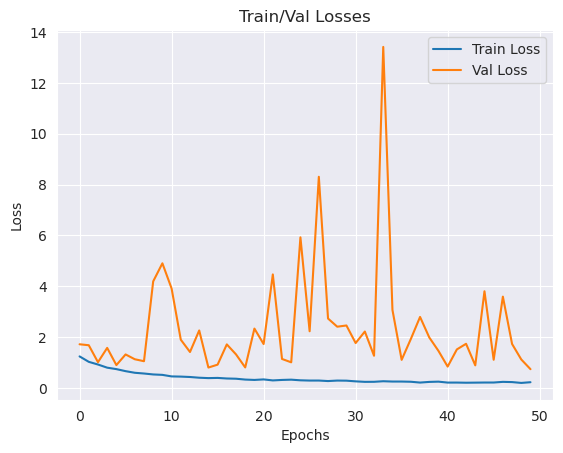

train_losses=[1.243202272633664, 1.0292050929513352, 0.9238265722918909, 0.799961844997076, 0.742960177095238, 0.6626625364037289, 0.5991197668353812, 0.5698915853349577, 0.5333640350113336, 0.5166251409380987, 0.45609617542679953, 0.448404679070438, 0.4329404355446877, 0.4044469306890037, 0.38916801623022074, 0.39687674942032963, 0.3743105438673482, 0.3651028366932792, 0.33179587260253174, 0.3174422861283605, 0.3379160235735959, 0.2985752757131911, 0.3174466984235373, 0.32783767599656927, 0.3027625659742973, 0.2927705197481701, 0.2933196123624954, 0.27326800538613716, 0.2924217642762816, 0.2884120274099537, 0.2616194932763787, 0.2419792513267486, 0.2439913740248235, 0.2663803890476399, 0.25404756452592625, 0.2538269508834528, 0.24580438785101588, 0.21382885785697825, 0.2398271608057483, 0.2499125632490776, 0.21311954587146748, 0.21378591076997697, 0.20774300393664005, 0.2112787368536209, 0.21542577828538464, 0.21567125026934594, 0.24160192149629048, 0.23282549872901068, 0.199962571897

100%|██████████| 126/126 [00:02<00:00, 50.69it/s]

Epoch [1 out of 50], Train --> loss: 1.0987 & accuracy: 55.20%, Validation --> loss: 0.9856 & accuracy: 59.40%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.15it/s]

Epoch [2 out of 50], Train --> loss: 0.8479 & accuracy: 67.11%, Validation --> loss: 2.2010 & accuracy: 34.23%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.10it/s]

Epoch [3 out of 50], Train --> loss: 0.7611 & accuracy: 71.51%, Validation --> loss: 0.8004 & accuracy: 68.86%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.07it/s]

Epoch [4 out of 50], Train --> loss: 0.6819 & accuracy: 76.08%, Validation --> loss: 0.8057 & accuracy: 69.35%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.93it/s]

Epoch [5 out of 50], Train --> loss: 0.6080 & accuracy: 78.46%, Validation --> loss: 1.9180 & accuracy: 39.90%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.65it/s]

Epoch [6 out of 50], Train --> loss: 0.5771 & accuracy: 79.63%, Validation --> loss: 2.1228 & accuracy: 39.80%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.16it/s]

Epoch [7 out of 50], Train --> loss: 0.5333 & accuracy: 82.32%, Validation --> loss: 0.8421 & accuracy: 67.26%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.22it/s]

Epoch [8 out of 50], Train --> loss: 0.4870 & accuracy: 83.27%, Validation --> loss: 1.9975 & accuracy: 39.00%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.03it/s]

Epoch [9 out of 50], Train --> loss: 0.4643 & accuracy: 84.23%, Validation --> loss: 4.8850 & accuracy: 32.34%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.54it/s]

Epoch [10 out of 50], Train --> loss: 0.4600 & accuracy: 83.99%, Validation --> loss: 1.5556 & accuracy: 42.39%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.43it/s]

Epoch [11 out of 50], Train --> loss: 0.4036 & accuracy: 86.80%, Validation --> loss: 1.7234 & accuracy: 45.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.15it/s]

Epoch [12 out of 50], Train --> loss: 0.4150 & accuracy: 85.69%, Validation --> loss: 1.1919 & accuracy: 59.80%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.38it/s]

Epoch [13 out of 50], Train --> loss: 0.4010 & accuracy: 85.69%, Validation --> loss: 6.5252 & accuracy: 25.97%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.12it/s]

Epoch [14 out of 50], Train --> loss: 0.3639 & accuracy: 87.49%, Validation --> loss: 1.1803 & accuracy: 67.66%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.14it/s]

Epoch [15 out of 50], Train --> loss: 0.3642 & accuracy: 87.37%, Validation --> loss: 1.5448 & accuracy: 49.05%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.93it/s]

Epoch [16 out of 50], Train --> loss: 0.3568 & accuracy: 88.29%, Validation --> loss: 6.5738 & accuracy: 30.05%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.27it/s]

Epoch [17 out of 50], Train --> loss: 0.3816 & accuracy: 86.68%, Validation --> loss: 0.7695 & accuracy: 71.24%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.77it/s]

Epoch [18 out of 50], Train --> loss: 0.3321 & accuracy: 89.10%, Validation --> loss: 0.8141 & accuracy: 72.94%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.97it/s]

Epoch [19 out of 50], Train --> loss: 0.3085 & accuracy: 89.87%, Validation --> loss: 0.7546 & accuracy: 71.04%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.30it/s]

Epoch [20 out of 50], Train --> loss: 0.3038 & accuracy: 89.99%, Validation --> loss: 2.2079 & accuracy: 39.20%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.49it/s]

Epoch [21 out of 50], Train --> loss: 0.3165 & accuracy: 89.16%, Validation --> loss: 0.7369 & accuracy: 71.64%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.31it/s]

Epoch [22 out of 50], Train --> loss: 0.3176 & accuracy: 89.22%, Validation --> loss: 2.9737 & accuracy: 35.22%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.14it/s]

Epoch [23 out of 50], Train --> loss: 0.2921 & accuracy: 90.02%, Validation --> loss: 2.2452 & accuracy: 56.02%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.79it/s]

Epoch [24 out of 50], Train --> loss: 0.2826 & accuracy: 90.41%, Validation --> loss: 0.8732 & accuracy: 69.45%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.03it/s]

Epoch [25 out of 50], Train --> loss: 0.2776 & accuracy: 90.08%, Validation --> loss: 0.8794 & accuracy: 63.78%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.69it/s]

Epoch [26 out of 50], Train --> loss: 0.2836 & accuracy: 89.93%, Validation --> loss: 0.8472 & accuracy: 70.55%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.63it/s]

Epoch [27 out of 50], Train --> loss: 0.2802 & accuracy: 90.38%, Validation --> loss: 0.9903 & accuracy: 71.04%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.76it/s]

Epoch [28 out of 50], Train --> loss: 0.2429 & accuracy: 92.00%, Validation --> loss: 0.7186 & accuracy: 76.02%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.69it/s]

Epoch [29 out of 50], Train --> loss: 0.2496 & accuracy: 91.64%, Validation --> loss: 0.7420 & accuracy: 74.63%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.71it/s]

Epoch [30 out of 50], Train --> loss: 0.2588 & accuracy: 90.98%, Validation --> loss: 2.7146 & accuracy: 45.97%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.16it/s]


Epoch [31 out of 50], Train --> loss: 0.2524 & accuracy: 91.31%, Validation --> loss: 0.6543 & accuracy: 78.61%
Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.98it/s]

Epoch [32 out of 50], Train --> loss: 0.2750 & accuracy: 91.13%, Validation --> loss: 1.2753 & accuracy: 58.41%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.35it/s]

Epoch [33 out of 50], Train --> loss: 0.2143 & accuracy: 93.22%, Validation --> loss: 2.4172 & accuracy: 51.14%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.50it/s]


Epoch [34 out of 50], Train --> loss: 0.2479 & accuracy: 91.64%, Validation --> loss: 0.9115 & accuracy: 70.95%
Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.11it/s]

Epoch [35 out of 50], Train --> loss: 0.2347 & accuracy: 92.05%, Validation --> loss: 0.8090 & accuracy: 70.05%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.80it/s]

Epoch [36 out of 50], Train --> loss: 0.2280 & accuracy: 92.14%, Validation --> loss: 1.9910 & accuracy: 52.04%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.12it/s]

Epoch [37 out of 50], Train --> loss: 0.2422 & accuracy: 92.14%, Validation --> loss: 0.7053 & accuracy: 77.61%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.92it/s]

Epoch [38 out of 50], Train --> loss: 0.2120 & accuracy: 92.68%, Validation --> loss: 2.0506 & accuracy: 47.76%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.64it/s]

Epoch [39 out of 50], Train --> loss: 0.2307 & accuracy: 92.77%, Validation --> loss: 6.8574 & accuracy: 27.26%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.11it/s]

Epoch [40 out of 50], Train --> loss: 0.2326 & accuracy: 93.01%, Validation --> loss: 1.3890 & accuracy: 62.89%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.71it/s]

Epoch [41 out of 50], Train --> loss: 0.2260 & accuracy: 92.41%, Validation --> loss: 0.8253 & accuracy: 72.24%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.81it/s]

Epoch [42 out of 50], Train --> loss: 0.2103 & accuracy: 93.19%, Validation --> loss: 6.0401 & accuracy: 26.87%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.65it/s]

Epoch [43 out of 50], Train --> loss: 0.2299 & accuracy: 91.85%, Validation --> loss: 0.7015 & accuracy: 74.43%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.91it/s]

Epoch [44 out of 50], Train --> loss: 0.2266 & accuracy: 92.14%, Validation --> loss: 1.7213 & accuracy: 57.71%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.86it/s]

Epoch [45 out of 50], Train --> loss: 0.2206 & accuracy: 92.95%, Validation --> loss: 0.9646 & accuracy: 70.05%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.42it/s]

Epoch [46 out of 50], Train --> loss: 0.1987 & accuracy: 94.21%, Validation --> loss: 6.3653 & accuracy: 29.05%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.59it/s]

Epoch [47 out of 50], Train --> loss: 0.2202 & accuracy: 92.92%, Validation --> loss: 0.6724 & accuracy: 74.73%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.23it/s]

Epoch [48 out of 50], Train --> loss: 0.2140 & accuracy: 93.28%, Validation --> loss: 0.7244 & accuracy: 75.82%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.84it/s]

Epoch [49 out of 50], Train --> loss: 0.1868 & accuracy: 94.12%, Validation --> loss: 2.3123 & accuracy: 35.72%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.38it/s]

Epoch [50 out of 50], Train --> loss: 0.1986 & accuracy: 94.09%, Validation --> loss: 1.7882 & accuracy: 46.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 42.49it/s]


Test Accuracy: 52.90%


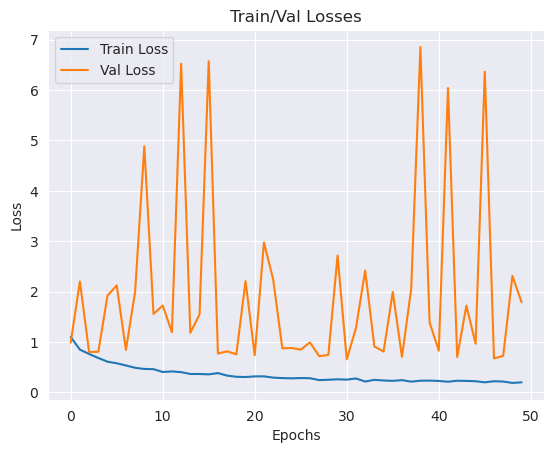

train_losses=[1.0986848521915427, 0.8478519137690915, 0.7611090069312184, 0.6818674564503827, 0.6079513401433221, 0.5770622549449629, 0.5333369185787966, 0.4870127268793475, 0.4643104292968008, 0.46003324799862, 0.40363331069738595, 0.41501905358349794, 0.400970996190796, 0.3639123511449534, 0.36419310272273414, 0.3567851835723993, 0.381647937079816, 0.3321050064980557, 0.3084812830769077, 0.3038317032140593, 0.3164872418964606, 0.3176183274864866, 0.2921216526204333, 0.2826331837862943, 0.2776404674651728, 0.2835579335084963, 0.2801583365521667, 0.24291434278155996, 0.24960287532331266, 0.2587609141220412, 0.25236076409517294, 0.27503066397936643, 0.21432018948181006, 0.24786111548418505, 0.2346929045247363, 0.22802706026785555, 0.24223380082849244, 0.21201065130674043, 0.2307036723741519, 0.23259916215654916, 0.22600521826516473, 0.2102729131340945, 0.22992443750103433, 0.22656622766194806, 0.22055875838940922, 0.19867019406864353, 0.22018486724806358, 0.21402777610279994, 0.18676677

100%|██████████| 126/126 [00:02<00:00, 52.74it/s]

Epoch [1 out of 50], Train --> loss: 1.2213 & accuracy: 46.09%, Validation --> loss: 1.5091 & accuracy: 32.84%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.01it/s]

Epoch [2 out of 50], Train --> loss: 1.0420 & accuracy: 56.99%, Validation --> loss: 1.0458 & accuracy: 59.70%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.28it/s]

Epoch [3 out of 50], Train --> loss: 0.9078 & accuracy: 63.71%, Validation --> loss: 1.0312 & accuracy: 57.81%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.69it/s]

Epoch [4 out of 50], Train --> loss: 0.8152 & accuracy: 67.98%, Validation --> loss: 0.9993 & accuracy: 62.49%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.57it/s]

Epoch [5 out of 50], Train --> loss: 0.7602 & accuracy: 70.13%, Validation --> loss: 1.3280 & accuracy: 43.88%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.07it/s]

Epoch [6 out of 50], Train --> loss: 0.7065 & accuracy: 72.85%, Validation --> loss: 1.2715 & accuracy: 51.54%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.16it/s]

Epoch [7 out of 50], Train --> loss: 0.6838 & accuracy: 73.78%, Validation --> loss: 0.9325 & accuracy: 64.58%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.74it/s]

Epoch [8 out of 50], Train --> loss: 0.6266 & accuracy: 76.22%, Validation --> loss: 0.9601 & accuracy: 64.58%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.00it/s]

Epoch [9 out of 50], Train --> loss: 0.5789 & accuracy: 78.35%, Validation --> loss: 2.0772 & accuracy: 38.81%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.17it/s]

Epoch [10 out of 50], Train --> loss: 0.5607 & accuracy: 78.85%, Validation --> loss: 2.3499 & accuracy: 43.48%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.73it/s]

Epoch [11 out of 50], Train --> loss: 0.5481 & accuracy: 79.93%, Validation --> loss: 1.1982 & accuracy: 58.61%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.77it/s]

Epoch [12 out of 50], Train --> loss: 0.5115 & accuracy: 80.97%, Validation --> loss: 1.0254 & accuracy: 62.39%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.88it/s]

Epoch [13 out of 50], Train --> loss: 0.4846 & accuracy: 81.78%, Validation --> loss: 1.3006 & accuracy: 53.53%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.09it/s]

Epoch [14 out of 50], Train --> loss: 0.4733 & accuracy: 82.74%, Validation --> loss: 0.8930 & accuracy: 70.75%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.09it/s]

Epoch [15 out of 50], Train --> loss: 0.4499 & accuracy: 83.69%, Validation --> loss: 1.4691 & accuracy: 59.10%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.19it/s]

Epoch [16 out of 50], Train --> loss: 0.4504 & accuracy: 83.39%, Validation --> loss: 1.9149 & accuracy: 42.59%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.49it/s]

Epoch [17 out of 50], Train --> loss: 0.4201 & accuracy: 84.47%, Validation --> loss: 1.0005 & accuracy: 65.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.30it/s]

Epoch [18 out of 50], Train --> loss: 0.4218 & accuracy: 84.62%, Validation --> loss: 1.2374 & accuracy: 61.09%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.47it/s]

Epoch [19 out of 50], Train --> loss: 0.4075 & accuracy: 85.51%, Validation --> loss: 1.5506 & accuracy: 56.32%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.07it/s]

Epoch [20 out of 50], Train --> loss: 0.4150 & accuracy: 84.62%, Validation --> loss: 2.8096 & accuracy: 43.28%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.67it/s]

Epoch [21 out of 50], Train --> loss: 0.4038 & accuracy: 85.84%, Validation --> loss: 0.7823 & accuracy: 70.55%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.61it/s]

Epoch [22 out of 50], Train --> loss: 0.3850 & accuracy: 86.32%, Validation --> loss: 1.0086 & accuracy: 66.87%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.61it/s]

Epoch [23 out of 50], Train --> loss: 0.3678 & accuracy: 86.86%, Validation --> loss: 0.7058 & accuracy: 76.22%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.75it/s]

Epoch [24 out of 50], Train --> loss: 0.3729 & accuracy: 85.75%, Validation --> loss: 1.0157 & accuracy: 67.16%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.84it/s]

Epoch [25 out of 50], Train --> loss: 0.3441 & accuracy: 87.72%, Validation --> loss: 0.8398 & accuracy: 72.54%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.28it/s]

Epoch [26 out of 50], Train --> loss: 0.3597 & accuracy: 87.34%, Validation --> loss: 1.4230 & accuracy: 54.63%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.59it/s]

Epoch [27 out of 50], Train --> loss: 0.3354 & accuracy: 87.66%, Validation --> loss: 1.5445 & accuracy: 55.22%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.02it/s]

Epoch [28 out of 50], Train --> loss: 0.3294 & accuracy: 88.02%, Validation --> loss: 1.1349 & accuracy: 66.07%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.31it/s]

Epoch [29 out of 50], Train --> loss: 0.3556 & accuracy: 87.78%, Validation --> loss: 0.8064 & accuracy: 69.35%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.42it/s]

Epoch [30 out of 50], Train --> loss: 0.3096 & accuracy: 88.47%, Validation --> loss: 0.9826 & accuracy: 69.55%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.47it/s]

Epoch [31 out of 50], Train --> loss: 0.3054 & accuracy: 88.92%, Validation --> loss: 1.2215 & accuracy: 64.68%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.98it/s]

Epoch [32 out of 50], Train --> loss: 0.2949 & accuracy: 89.49%, Validation --> loss: 1.5732 & accuracy: 55.22%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.30it/s]

Epoch [33 out of 50], Train --> loss: 0.3350 & accuracy: 88.11%, Validation --> loss: 2.0481 & accuracy: 49.85%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.26it/s]

Epoch [34 out of 50], Train --> loss: 0.2862 & accuracy: 89.87%, Validation --> loss: 0.9009 & accuracy: 69.95%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.06it/s]

Epoch [35 out of 50], Train --> loss: 0.2821 & accuracy: 89.43%, Validation --> loss: 2.0115 & accuracy: 45.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.06it/s]

Epoch [36 out of 50], Train --> loss: 0.3091 & accuracy: 89.07%, Validation --> loss: 1.5214 & accuracy: 56.22%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.31it/s]

Epoch [37 out of 50], Train --> loss: 0.2776 & accuracy: 89.87%, Validation --> loss: 0.7991 & accuracy: 72.64%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.06it/s]

Epoch [38 out of 50], Train --> loss: 0.2829 & accuracy: 90.74%, Validation --> loss: 1.2928 & accuracy: 61.59%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.95it/s]

Epoch [39 out of 50], Train --> loss: 0.2872 & accuracy: 90.17%, Validation --> loss: 1.5738 & accuracy: 56.12%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.67it/s]

Epoch [40 out of 50], Train --> loss: 0.2796 & accuracy: 89.90%, Validation --> loss: 1.1373 & accuracy: 68.76%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.85it/s]

Epoch [41 out of 50], Train --> loss: 0.2911 & accuracy: 90.08%, Validation --> loss: 0.9023 & accuracy: 70.95%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.67it/s]

Epoch [42 out of 50], Train --> loss: 0.2512 & accuracy: 90.95%, Validation --> loss: 1.4265 & accuracy: 55.92%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.59it/s]

Epoch [43 out of 50], Train --> loss: 0.2444 & accuracy: 91.37%, Validation --> loss: 1.0264 & accuracy: 67.26%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.50it/s]

Epoch [44 out of 50], Train --> loss: 0.3289 & accuracy: 88.32%, Validation --> loss: 0.8009 & accuracy: 74.33%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.10it/s]

Epoch [45 out of 50], Train --> loss: 0.2595 & accuracy: 90.59%, Validation --> loss: 1.0825 & accuracy: 66.87%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.52it/s]

Epoch [46 out of 50], Train --> loss: 0.2307 & accuracy: 91.88%, Validation --> loss: 2.2998 & accuracy: 46.37%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.92it/s]

Epoch [47 out of 50], Train --> loss: 0.2758 & accuracy: 90.29%, Validation --> loss: 1.5390 & accuracy: 59.60%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.93it/s]

Epoch [48 out of 50], Train --> loss: 0.2485 & accuracy: 91.52%, Validation --> loss: 1.0104 & accuracy: 69.45%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.27it/s]

Epoch [49 out of 50], Train --> loss: 0.2589 & accuracy: 90.71%, Validation --> loss: 1.6608 & accuracy: 63.98%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.70it/s]

Epoch [50 out of 50], Train --> loss: 0.2442 & accuracy: 91.52%, Validation --> loss: 3.0450 & accuracy: 41.29%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 44.10it/s]


Test Accuracy: 40.60%


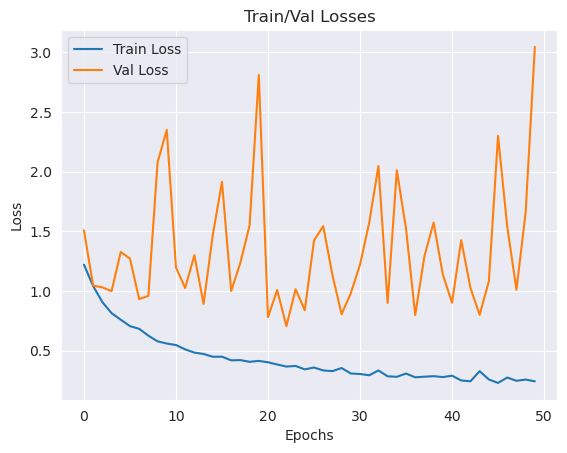

train_losses=[1.2212682867107072, 1.0420141887266483, 0.9077869790977396, 0.8152483524599052, 0.7601581606702759, 0.706479663851722, 0.6838298336489388, 0.6266381132254168, 0.5788856439630286, 0.5606767730276169, 0.5480619243175004, 0.5115367494843598, 0.4845934997986211, 0.4733393464886488, 0.44994039158725796, 0.45042668592389273, 0.42006566219458574, 0.4218117980317597, 0.40752727403205447, 0.4150403771184936, 0.4038287652989845, 0.38499558299139747, 0.3678108313140906, 0.3728601824101016, 0.344054473488456, 0.35970907485854936, 0.3354318414710302, 0.3294054609245503, 0.3555536459162298, 0.3096463293601761, 0.3053633208233232, 0.2948509754261851, 0.3350475694926407, 0.2862240502250721, 0.28212560376992585, 0.3090822169677241, 0.27763021973946395, 0.28288564777673003, 0.28723545997294647, 0.2795910978576431, 0.29113214978001356, 0.251219832987429, 0.24441742074513598, 0.3288885415676172, 0.25947358901445755, 0.23072570642269702, 0.2757633683785156, 0.2485169590104078, 0.2588619644295

100%|██████████| 126/126 [00:02<00:00, 52.81it/s]

Epoch [1 out of 50], Train --> loss: 1.1006 & accuracy: 54.30%, Validation --> loss: 1.3358 & accuracy: 47.36%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 43.12it/s]

Epoch [2 out of 50], Train --> loss: 0.8969 & accuracy: 64.61%, Validation --> loss: 0.8696 & accuracy: 65.67%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.47it/s]

Epoch [3 out of 50], Train --> loss: 0.7910 & accuracy: 68.64%, Validation --> loss: 1.9101 & accuracy: 44.68%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.71it/s]

Epoch [4 out of 50], Train --> loss: 0.6979 & accuracy: 73.39%, Validation --> loss: 0.9496 & accuracy: 65.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.74it/s]

Epoch [5 out of 50], Train --> loss: 0.6458 & accuracy: 75.93%, Validation --> loss: 2.1655 & accuracy: 45.67%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.51it/s]

Epoch [6 out of 50], Train --> loss: 0.5769 & accuracy: 78.67%, Validation --> loss: 1.3876 & accuracy: 50.35%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.04it/s]

Epoch [7 out of 50], Train --> loss: 0.5333 & accuracy: 80.14%, Validation --> loss: 0.9789 & accuracy: 67.96%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.37it/s]

Epoch [8 out of 50], Train --> loss: 0.5204 & accuracy: 80.70%, Validation --> loss: 4.7500 & accuracy: 51.74%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.06it/s]

Epoch [9 out of 50], Train --> loss: 0.4996 & accuracy: 82.02%, Validation --> loss: 1.7051 & accuracy: 41.19%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.16it/s]

Epoch [10 out of 50], Train --> loss: 0.4446 & accuracy: 83.69%, Validation --> loss: 1.2224 & accuracy: 63.08%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.48it/s]

Epoch [11 out of 50], Train --> loss: 0.4160 & accuracy: 84.80%, Validation --> loss: 1.5372 & accuracy: 61.49%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.99it/s]

Epoch [12 out of 50], Train --> loss: 0.3997 & accuracy: 85.87%, Validation --> loss: 1.9400 & accuracy: 52.84%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.22it/s]

Epoch [13 out of 50], Train --> loss: 0.3570 & accuracy: 86.41%, Validation --> loss: 1.8162 & accuracy: 53.63%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.18it/s]

Epoch [14 out of 50], Train --> loss: 0.3818 & accuracy: 85.84%, Validation --> loss: 1.5310 & accuracy: 57.41%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.18it/s]

Epoch [15 out of 50], Train --> loss: 0.3603 & accuracy: 87.22%, Validation --> loss: 3.0162 & accuracy: 42.79%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.45it/s]

Epoch [16 out of 50], Train --> loss: 0.3601 & accuracy: 86.65%, Validation --> loss: 0.9866 & accuracy: 70.35%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.41it/s]

Epoch [17 out of 50], Train --> loss: 0.3302 & accuracy: 88.02%, Validation --> loss: 1.4377 & accuracy: 59.20%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.75it/s]

Epoch [18 out of 50], Train --> loss: 0.3482 & accuracy: 87.07%, Validation --> loss: 10.1355 & accuracy: 23.18%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 53.44it/s]

Epoch [19 out of 50], Train --> loss: 0.3197 & accuracy: 88.32%, Validation --> loss: 1.0842 & accuracy: 64.58%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.47it/s]

Epoch [20 out of 50], Train --> loss: 0.2983 & accuracy: 89.10%, Validation --> loss: 26.0969 & accuracy: 25.47%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.91it/s]

Epoch [21 out of 50], Train --> loss: 0.2949 & accuracy: 89.43%, Validation --> loss: 1.4969 & accuracy: 62.89%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.86it/s]

Epoch [22 out of 50], Train --> loss: 0.3149 & accuracy: 88.23%, Validation --> loss: 4.1729 & accuracy: 33.63%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.89it/s]

Epoch [23 out of 50], Train --> loss: 0.3040 & accuracy: 88.92%, Validation --> loss: 2.1959 & accuracy: 48.76%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.17it/s]

Epoch [24 out of 50], Train --> loss: 0.2908 & accuracy: 89.49%, Validation --> loss: 0.9012 & accuracy: 69.55%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.72it/s]

Epoch [25 out of 50], Train --> loss: 0.2704 & accuracy: 90.74%, Validation --> loss: 3.1852 & accuracy: 35.42%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.04it/s]

Epoch [26 out of 50], Train --> loss: 0.2834 & accuracy: 89.49%, Validation --> loss: 1.1319 & accuracy: 64.08%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.36it/s]

Epoch [27 out of 50], Train --> loss: 0.2467 & accuracy: 91.46%, Validation --> loss: 3.0604 & accuracy: 54.13%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.23it/s]

Epoch [28 out of 50], Train --> loss: 0.2486 & accuracy: 90.68%, Validation --> loss: 0.7129 & accuracy: 79.50%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.35it/s]

Epoch [29 out of 50], Train --> loss: 0.2578 & accuracy: 91.10%, Validation --> loss: 6.2070 & accuracy: 30.95%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.77it/s]

Epoch [30 out of 50], Train --> loss: 0.2661 & accuracy: 89.81%, Validation --> loss: 0.6027 & accuracy: 79.70%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.97it/s]

Epoch [31 out of 50], Train --> loss: 0.2484 & accuracy: 91.01%, Validation --> loss: 0.7094 & accuracy: 76.82%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.81it/s]

Epoch [32 out of 50], Train --> loss: 0.2369 & accuracy: 91.94%, Validation --> loss: 1.0883 & accuracy: 65.97%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.92it/s]

Epoch [33 out of 50], Train --> loss: 0.2175 & accuracy: 92.14%, Validation --> loss: 1.8512 & accuracy: 54.93%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.78it/s]

Epoch [34 out of 50], Train --> loss: 0.2324 & accuracy: 91.64%, Validation --> loss: 1.1725 & accuracy: 66.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.04it/s]

Epoch [35 out of 50], Train --> loss: 0.2356 & accuracy: 91.94%, Validation --> loss: 1.1685 & accuracy: 63.28%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.27it/s]


Epoch [36 out of 50], Train --> loss: 0.2440 & accuracy: 91.58%, Validation --> loss: 1.9751 & accuracy: 51.14%
Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.43it/s]

Epoch [37 out of 50], Train --> loss: 0.2161 & accuracy: 92.35%, Validation --> loss: 1.6920 & accuracy: 61.49%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.74it/s]

Epoch [38 out of 50], Train --> loss: 0.2271 & accuracy: 92.32%, Validation --> loss: 2.8400 & accuracy: 44.78%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.65it/s]

Epoch [39 out of 50], Train --> loss: 0.2190 & accuracy: 92.62%, Validation --> loss: 1.0320 & accuracy: 69.65%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.40it/s]

Epoch [40 out of 50], Train --> loss: 0.1844 & accuracy: 93.43%, Validation --> loss: 1.5755 & accuracy: 62.49%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.85it/s]

Epoch [41 out of 50], Train --> loss: 0.2010 & accuracy: 93.04%, Validation --> loss: 1.6447 & accuracy: 59.70%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.09it/s]

Epoch [42 out of 50], Train --> loss: 0.1935 & accuracy: 92.83%, Validation --> loss: 4.2322 & accuracy: 39.50%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.82it/s]

Epoch [43 out of 50], Train --> loss: 0.2323 & accuracy: 92.65%, Validation --> loss: 0.7242 & accuracy: 79.40%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.81it/s]

Epoch [44 out of 50], Train --> loss: 0.2191 & accuracy: 92.53%, Validation --> loss: 0.8908 & accuracy: 74.73%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.09it/s]

Epoch [45 out of 50], Train --> loss: 0.2235 & accuracy: 92.44%, Validation --> loss: 2.1720 & accuracy: 53.43%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.07it/s]

Epoch [46 out of 50], Train --> loss: 0.2154 & accuracy: 92.41%, Validation --> loss: 3.2354 & accuracy: 37.51%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.06it/s]

Epoch [47 out of 50], Train --> loss: 0.1947 & accuracy: 93.01%, Validation --> loss: 0.7407 & accuracy: 76.12%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.47it/s]

Epoch [48 out of 50], Train --> loss: 0.1866 & accuracy: 93.67%, Validation --> loss: 1.1565 & accuracy: 66.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.36it/s]

Epoch [49 out of 50], Train --> loss: 0.2038 & accuracy: 92.50%, Validation --> loss: 1.4327 & accuracy: 65.37%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.38it/s]

Epoch [50 out of 50], Train --> loss: 0.1921 & accuracy: 93.52%, Validation --> loss: 1.0235 & accuracy: 74.43%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 46.98it/s]


Test Accuracy: 75.17%


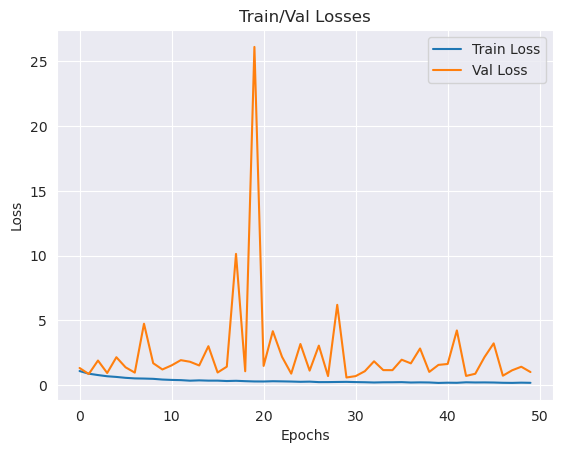

train_losses=[1.100632326984178, 0.8968622494568973, 0.7910124535065562, 0.6978604122462876, 0.6458495585581283, 0.576856213477318, 0.5332550023969147, 0.5204330710494148, 0.49964918510939454, 0.44460212585109515, 0.4160441375095264, 0.3997098170487579, 0.3570104827971013, 0.3818264613661533, 0.3603298422171421, 0.3600541196834643, 0.3301973153741448, 0.3481728684241597, 0.31966629841304905, 0.298326372740199, 0.2948945370504993, 0.31489277533244403, 0.3039656775183353, 0.2907662716336317, 0.2703885515409395, 0.28341627630865235, 0.24669901950858303, 0.2485747531340913, 0.2577954112009761, 0.2661020043417189, 0.2484467565948877, 0.2369107841391801, 0.217542918153365, 0.2324034883085025, 0.23561497777144744, 0.2440363732144361, 0.21611578815654453, 0.22706497281174085, 0.21899069945976973, 0.18442955436651776, 0.2010486115693717, 0.19345419606313927, 0.2323295541106543, 0.2191016594979352, 0.2234723644635611, 0.21541042311610498, 0.19466042750779547, 0.18664768944507762, 0.2038348740286

100%|██████████| 126/126 [00:02<00:00, 51.12it/s]

Epoch [1 out of 50], Train --> loss: 1.1094 & accuracy: 52.87%, Validation --> loss: 1.5042 & accuracy: 38.81%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.19it/s]

Epoch [2 out of 50], Train --> loss: 0.9015 & accuracy: 64.87%, Validation --> loss: 1.0370 & accuracy: 57.21%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.11it/s]

Epoch [3 out of 50], Train --> loss: 0.8170 & accuracy: 70.70%, Validation --> loss: 1.2101 & accuracy: 46.27%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.64it/s]

Epoch [4 out of 50], Train --> loss: 0.7494 & accuracy: 74.46%, Validation --> loss: 1.1115 & accuracy: 54.03%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 49.09it/s]

Epoch [5 out of 50], Train --> loss: 0.7091 & accuracy: 76.79%, Validation --> loss: 0.9948 & accuracy: 61.39%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.16it/s]

Epoch [6 out of 50], Train --> loss: 0.6621 & accuracy: 79.36%, Validation --> loss: 1.6515 & accuracy: 48.36%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.14it/s]

Epoch [7 out of 50], Train --> loss: 0.6356 & accuracy: 80.65%, Validation --> loss: 1.1280 & accuracy: 53.83%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.31it/s]

Epoch [8 out of 50], Train --> loss: 0.6284 & accuracy: 80.59%, Validation --> loss: 0.9128 & accuracy: 62.09%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.02it/s]

Epoch [9 out of 50], Train --> loss: 0.5867 & accuracy: 83.15%, Validation --> loss: 2.0103 & accuracy: 38.31%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.61it/s]

Epoch [10 out of 50], Train --> loss: 0.5725 & accuracy: 83.42%, Validation --> loss: 1.0511 & accuracy: 59.40%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.34it/s]

Epoch [11 out of 50], Train --> loss: 0.5533 & accuracy: 84.02%, Validation --> loss: 1.1407 & accuracy: 58.11%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.37it/s]

Epoch [12 out of 50], Train --> loss: 0.5197 & accuracy: 86.53%, Validation --> loss: 0.8865 & accuracy: 66.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.41it/s]

Epoch [13 out of 50], Train --> loss: 0.5157 & accuracy: 85.60%, Validation --> loss: 0.9612 & accuracy: 61.69%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.71it/s]

Epoch [14 out of 50], Train --> loss: 0.4917 & accuracy: 87.57%, Validation --> loss: 1.3540 & accuracy: 47.76%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.12it/s]

Epoch [15 out of 50], Train --> loss: 0.4793 & accuracy: 88.08%, Validation --> loss: 0.8091 & accuracy: 70.05%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.43it/s]

Epoch [16 out of 50], Train --> loss: 0.4661 & accuracy: 87.49%, Validation --> loss: 0.7904 & accuracy: 73.43%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.60it/s]

Epoch [17 out of 50], Train --> loss: 0.4582 & accuracy: 87.46%, Validation --> loss: 1.0081 & accuracy: 62.09%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.45it/s]

Epoch [18 out of 50], Train --> loss: 0.4464 & accuracy: 88.38%, Validation --> loss: 1.6154 & accuracy: 47.46%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.98it/s]

Epoch [19 out of 50], Train --> loss: 0.4359 & accuracy: 88.56%, Validation --> loss: 0.8367 & accuracy: 65.07%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.90it/s]

Epoch [20 out of 50], Train --> loss: 0.4227 & accuracy: 89.55%, Validation --> loss: 0.9851 & accuracy: 60.90%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.74it/s]

Epoch [21 out of 50], Train --> loss: 0.4262 & accuracy: 89.19%, Validation --> loss: 1.0953 & accuracy: 62.89%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.31it/s]

Epoch [22 out of 50], Train --> loss: 0.4147 & accuracy: 89.19%, Validation --> loss: 1.2662 & accuracy: 43.98%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 48.96it/s]

Epoch [23 out of 50], Train --> loss: 0.4055 & accuracy: 89.84%, Validation --> loss: 0.8798 & accuracy: 66.37%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.63it/s]

Epoch [24 out of 50], Train --> loss: 0.3887 & accuracy: 89.78%, Validation --> loss: 1.2286 & accuracy: 55.62%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 46.30it/s]

Epoch [25 out of 50], Train --> loss: 0.3786 & accuracy: 90.50%, Validation --> loss: 0.9668 & accuracy: 61.29%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.75it/s]

Epoch [26 out of 50], Train --> loss: 0.3566 & accuracy: 91.16%, Validation --> loss: 0.8827 & accuracy: 64.38%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.41it/s]

Epoch [27 out of 50], Train --> loss: 0.3796 & accuracy: 90.17%, Validation --> loss: 0.8217 & accuracy: 66.07%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.28it/s]

Epoch [28 out of 50], Train --> loss: 0.3561 & accuracy: 90.89%, Validation --> loss: 0.7659 & accuracy: 73.23%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.99it/s]

Epoch [29 out of 50], Train --> loss: 0.3678 & accuracy: 90.44%, Validation --> loss: 0.9478 & accuracy: 61.39%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.02it/s]

Epoch [30 out of 50], Train --> loss: 0.3311 & accuracy: 91.61%, Validation --> loss: 1.0871 & accuracy: 52.44%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.62it/s]

Epoch [31 out of 50], Train --> loss: 0.3409 & accuracy: 92.03%, Validation --> loss: 1.0513 & accuracy: 62.29%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.87it/s]

Epoch [32 out of 50], Train --> loss: 0.3456 & accuracy: 91.70%, Validation --> loss: 0.9534 & accuracy: 65.87%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.84it/s]

Epoch [33 out of 50], Train --> loss: 0.3400 & accuracy: 91.52%, Validation --> loss: 1.1166 & accuracy: 54.13%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.81it/s]

Epoch [34 out of 50], Train --> loss: 0.3220 & accuracy: 91.49%, Validation --> loss: 1.5211 & accuracy: 45.57%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.87it/s]

Epoch [35 out of 50], Train --> loss: 0.3107 & accuracy: 92.11%, Validation --> loss: 0.8740 & accuracy: 69.85%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 52.00it/s]

Epoch [36 out of 50], Train --> loss: 0.3163 & accuracy: 91.88%, Validation --> loss: 1.5838 & accuracy: 47.36%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 47.24it/s]

Epoch [37 out of 50], Train --> loss: 0.3204 & accuracy: 91.85%, Validation --> loss: 0.9010 & accuracy: 69.55%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.16it/s]

Epoch [38 out of 50], Train --> loss: 0.3067 & accuracy: 92.05%, Validation --> loss: 1.1941 & accuracy: 48.76%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.81it/s]

Epoch [39 out of 50], Train --> loss: 0.2950 & accuracy: 93.13%, Validation --> loss: 0.9485 & accuracy: 64.18%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 43.78it/s]

Epoch [40 out of 50], Train --> loss: 0.2932 & accuracy: 92.62%, Validation --> loss: 1.0821 & accuracy: 58.51%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.86it/s]

Epoch [41 out of 50], Train --> loss: 0.2882 & accuracy: 93.10%, Validation --> loss: 0.9817 & accuracy: 62.49%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.21it/s]

Epoch [42 out of 50], Train --> loss: 0.2926 & accuracy: 92.29%, Validation --> loss: 0.7697 & accuracy: 75.52%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 45.69it/s]

Epoch [43 out of 50], Train --> loss: 0.2874 & accuracy: 92.56%, Validation --> loss: 0.9388 & accuracy: 63.88%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.85it/s]

Epoch [44 out of 50], Train --> loss: 0.2770 & accuracy: 92.86%, Validation --> loss: 0.9369 & accuracy: 63.88%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.93it/s]

Epoch [45 out of 50], Train --> loss: 0.2665 & accuracy: 93.31%, Validation --> loss: 0.7460 & accuracy: 72.54%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 44.78it/s]

Epoch [46 out of 50], Train --> loss: 0.2856 & accuracy: 92.59%, Validation --> loss: 0.6856 & accuracy: 77.61%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.89it/s]

Epoch [47 out of 50], Train --> loss: 0.2688 & accuracy: 93.64%, Validation --> loss: 0.8763 & accuracy: 67.06%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 51.15it/s]

Epoch [48 out of 50], Train --> loss: 0.2676 & accuracy: 93.40%, Validation --> loss: 0.8194 & accuracy: 69.45%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.73it/s]

Epoch [49 out of 50], Train --> loss: 0.2840 & accuracy: 92.03%, Validation --> loss: 0.7239 & accuracy: 74.73%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 126/126 [00:02<00:00, 50.34it/s]

Epoch [50 out of 50], Train --> loss: 0.2707 & accuracy: 92.83%, Validation --> loss: 0.7458 & accuracy: 74.73%


Checking gradient for parameter: model.fc1.weight
Checking gradient for parameter: model.fc1.bias
Checking gradient for parameter: model.bn1.weight
Checking gradient for parameter: model.bn1.bias
Checking gradient for parameter: model.fc2.weight
Checking gradient for parameter: model.fc2.bias
Checking gradient for parameter: model.bn2.weight
Checking gradient for parameter: model.bn2.bias
Gradients check passed!


100%|██████████| 54/54 [00:01<00:00, 44.35it/s]


Test Accuracy: 77.73%


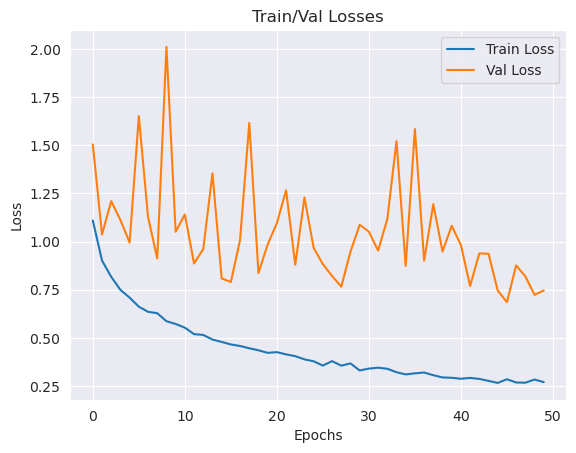

train_losses=[1.1093796341544404, 0.901501056118057, 0.8170342609677508, 0.7493703476284455, 0.7090960507745675, 0.6621359648596415, 0.6356114615688461, 0.6284423327531337, 0.5867292674742906, 0.5724540302320995, 0.5532866741990702, 0.5196734317233853, 0.5156925179082056, 0.49172634729195325, 0.47926835697988907, 0.46606854717458346, 0.45820013090505807, 0.44637593957717775, 0.4359019633409232, 0.4226748421966034, 0.4262251371700041, 0.41466242313242757, 0.40546109802967606, 0.3886932194375195, 0.3786448187645978, 0.3565905429156128, 0.3795764425631639, 0.3561106045021362, 0.3678133621954121, 0.33113324535490507, 0.3409361410041413, 0.34555681697081836, 0.33999231968048366, 0.32200417738754594, 0.3107111877395031, 0.3162944172297856, 0.32035824944551916, 0.30666344002920576, 0.2949818476927878, 0.2932268019436652, 0.28821718838590427, 0.29257087859376235, 0.2874287648353201, 0.2770034431308721, 0.26652868799776336, 0.2855662937522788, 0.26879021656968427, 0.2676109901689402, 0.28404634

In [20]:
import torch
import matplotlib.pyplot as plt
from custom_adam import Adam

best_with_batch_normalization = pd.DataFrame(columns=['opt', 'best_acc', 'lr', 'weight_decay'])
num_epochs = 50
params = [(optim.RMSprop, 0.01, 0), (optim.SGD, 0.01, 0.001), (Adam, 0.01, 0.001), (optim.SGD, 0.1, 0), (Adam, 0.0001, 0.001)]

for param in params:    
    model = AircraftNet(_input=IMAGE_HEIGHT*IMAGE_WIDTH*3,
                        hidden_size=256,
                        _output=4,
                        batch_normalization=True).to(device)

    print(f"Params lr={param[1]}, w={param[2]}, opt={param[0]}")
    train_losses, val_losses, best_with_batch_normalization = train_model(model, param[0], train_data_loader, val_data_loader, num_epochs, param[1], weight_decay=param[2], df=best_with_batch_normalization)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(test_data_loader)):
            images = images.view(-1, IMAGE_HEIGHT*IMAGE_WIDTH*3).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f"Test Accuracy: {100 * accuracy:.2f}%")

    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Train/Val Losses')
    plt.legend()
    plt.show()

    print(f"{train_losses=}\n{val_losses}")

In [21]:
best_with_batch_normalization

,opt,best_acc,lr,weight_decay,best_accuracy
0,RMSprop,NaN,0.1,0,0.776119
0,SGD,NaN,0.1,0.001,0.786070
0,Adam,NaN,0.1,0.001,0.762189
0,SGD,NaN,0.1,0,0.797015
0,Adam,NaN,0.1,0.001,0.776119


Наилучших результатов на валидационном множестве добился SGD с lr=0.1 и weight_decay=0, а на тестовом множестве optim.RMSprop с lr=0.01 и weight_decay=0 получил наилучшие результаты: test accuracy = 78.65%. [Train/val loss график](best_with_batch_normalization.png)

# Conclusion

Таким образом, на наборе данных по самолетам с 4 классами и вышеупомянутой простой нейронной сети с 256 скрытыми слоями удалось достичь точности 78,65 с помощью слоев с BatchNormalization.

Однако, как видно из графиков обучения, можно добиться гораздо лучших результатов, если увеличить размер скрытого слоя или изменить архитектуру сети, добавив еще несколько полностью связанных слоев для лучшей обобщающей способности.